In [3]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
sns.set_style('white')
sns.set(rc={'figure.figsize':(11, 4)})

from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.forecasting.trend import PolynomialTrendForecaster
from sktime.forecasting.compose import TransformedTargetForecaster
from sktime.transformations.series.detrend import Deseasonalizer
from sktime.utils.plotting import plot_series
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.utils.plotting import plot_series
from sklearn.ensemble import VotingRegressor
from sktime.forecasting.model_selection import ForecastingGridSearchCV, SlidingWindowSplitter
from sktime.forecasting.sarimax import SARIMAX as sktime_sarimax
from sktime.forecasting.arima import AutoARIMA
from sktime.utils.plotting import plot_series

from sktime.performance_metrics.forecasting import  MeanAbsolutePercentageError, MeanSquaredError
smape = MeanAbsolutePercentageError(symmetric = True)
rmse  = MeanSquaredError(square_root=True)

from sklearn.neighbors import LocalOutlierFactor
import itertools

import warnings
warnings.filterwarnings('ignore')

# Загрузка и предобработка данных

In [602]:
datafile = 'test_task_1.xlsx'
df = pd.read_excel(datafile, parse_dates=['report_dt'], index_col='report_dt')
df.head()

territ_subdiv_1  territ_subdiv_2  val
report_dt                                        
2015-01-31                1                1  1.0
2015-01-31                1                2  1.0
2015-01-31                1                3  1.0
2015-01-31                1                4  1.0
2015-01-31                1                5  1.0

In [603]:
df = df.sort_values(by=['report_dt', 'territ_subdiv_1', 'territ_subdiv_2'])

In [604]:
df

territ_subdiv_1  territ_subdiv_2       val
report_dt                                             
2015-01-31                1                1  1.000000
2015-01-31                1                2  1.000000
2015-01-31                1                3  1.000000
2015-01-31                1                4  1.000000
2015-01-31                1                5  1.000000
...                     ...              ...       ...
2019-12-31               11                4  2.881561
2019-12-31               11                5  2.876725
2019-12-31               11                6  2.979735
2019-12-31               11                7  1.810171
2019-12-31               11                8  2.701395

[5367 rows x 3 columns]

Набор представляет собой ежедневный комиссионный доход в разных подраздилениях первого и второго уровня Набор включает следующие временные ряды в виде колонок:

•	report_dt: отчётная дата (конец месяца для месячных данных и день для дневных);  
•	territ_subdiv_1: первый уровень дробления по территориям;  
•	territ_subdiv_2: второй уровень дробления по территориям.  
Обратите внимание на нумерацию: в разных подразделениях первого уровня содержится разное число подразделений второго уровня;  
•	val: комиссионный доход, млн. руб.  

In [605]:
# Размер набора данных
print(df.shape)

(5367, 3)


In [606]:
# Информация о колонках в наборе
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5367 entries, 2015-01-31 to 2019-12-31
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   territ_subdiv_1  5367 non-null   int64  
 1   territ_subdiv_2  5367 non-null   int64  
 2   val              5367 non-null   float64
dtypes: float64(1), int64(2)
memory usage: 167.7 KB


In [607]:
df.describe()

territ_subdiv_1  territ_subdiv_2          val
count      5367.000000      5367.000000  5367.000000
mean          6.435998         5.382337     2.046112
std           3.020608         3.252553     0.830536
min           1.000000         1.000000     0.009468
25%           5.000000         3.000000     1.404189
50%           7.000000         5.000000     1.989685
75%           9.000000         8.000000     2.540447
max          11.000000        15.000000    10.413210

In [608]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5367 entries, 2015-01-31 to 2019-12-31
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   territ_subdiv_1  5367 non-null   int64  
 1   territ_subdiv_2  5367 non-null   int64  
 2   val              5367 non-null   float64
dtypes: float64(1), int64(2)
memory usage: 167.7 KB


# Визуализация временного ряда

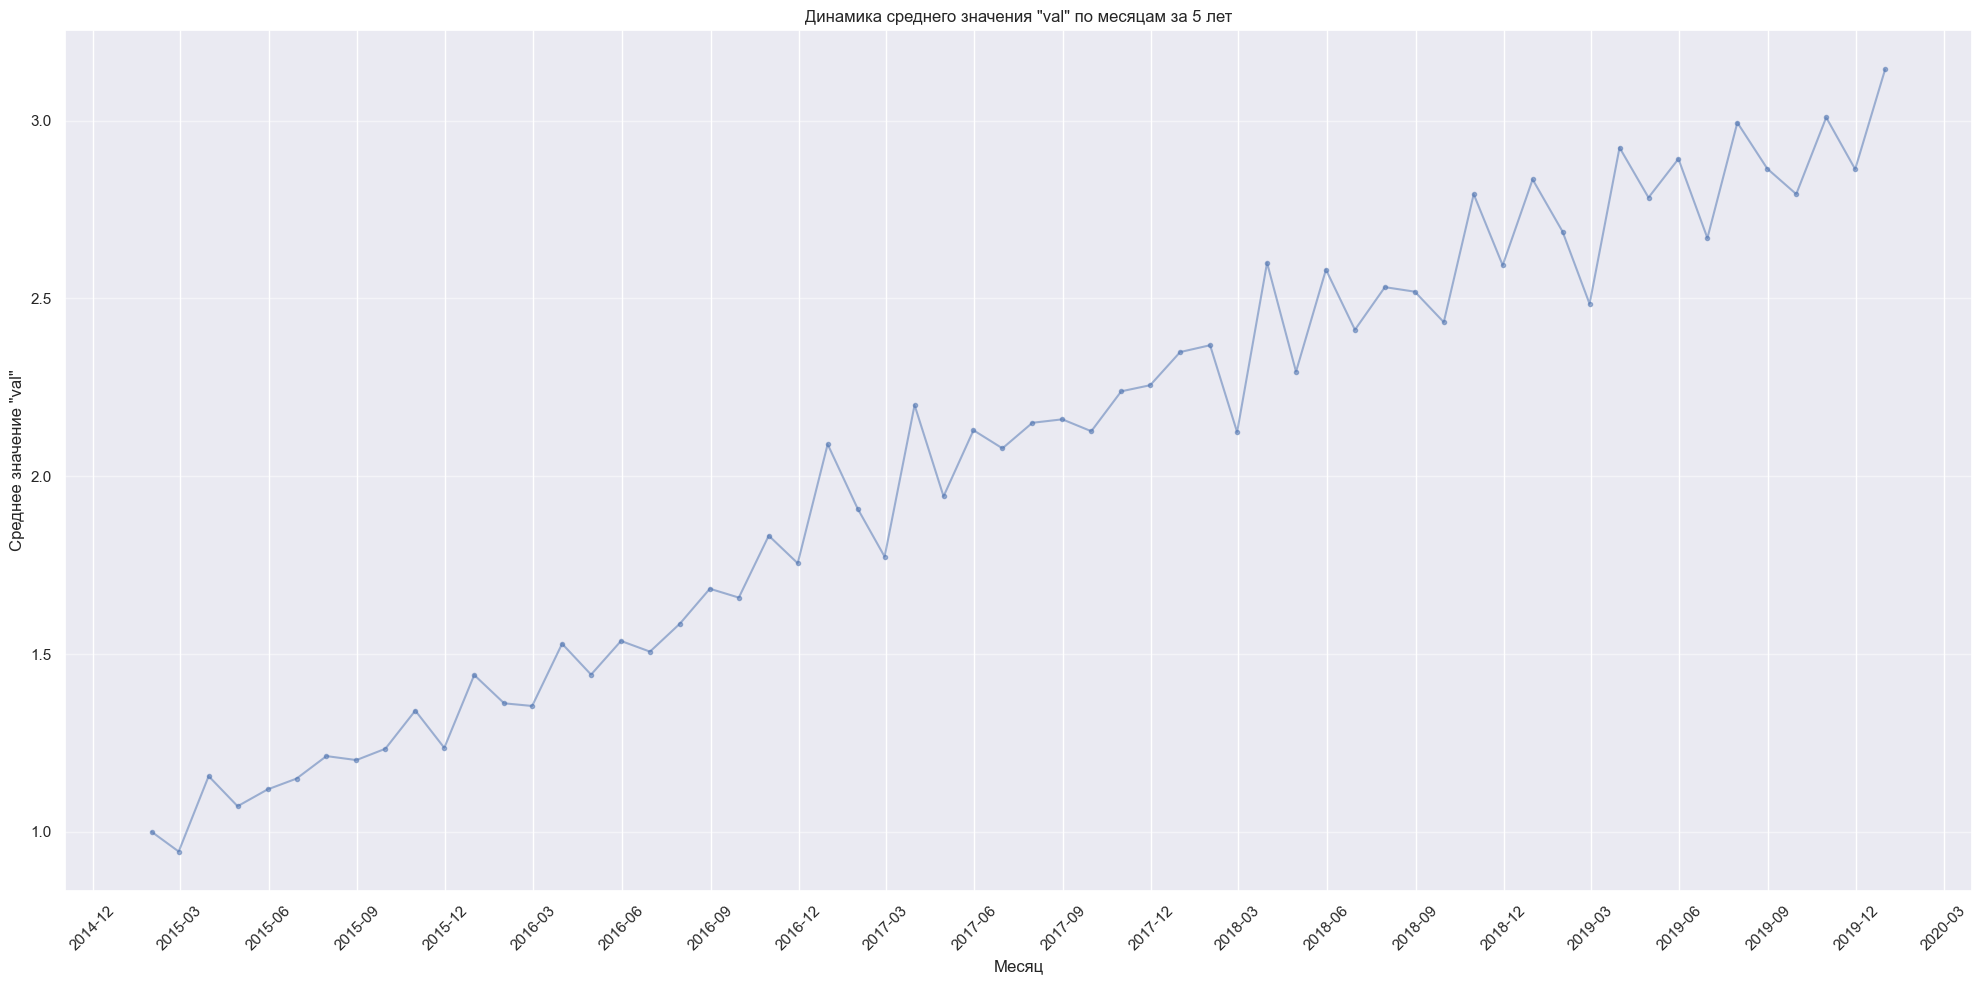

In [609]:
df_monthly = df.resample('M')['val'].mean()

fig, ax = plt.subplots(figsize=(20, 10))

ax.plot(df_monthly, marker='.', alpha=0.5, linestyle='-')

ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xticks(rotation=45)

ax.set_title('Динамика среднего значения "val" по месяцам за 5 лет')
ax.set_xlabel('Месяц')
ax.set_ylabel('Среднее значение "val"')

ax.grid(axis='y', alpha=0.5)

plt.tight_layout()
plt.show()

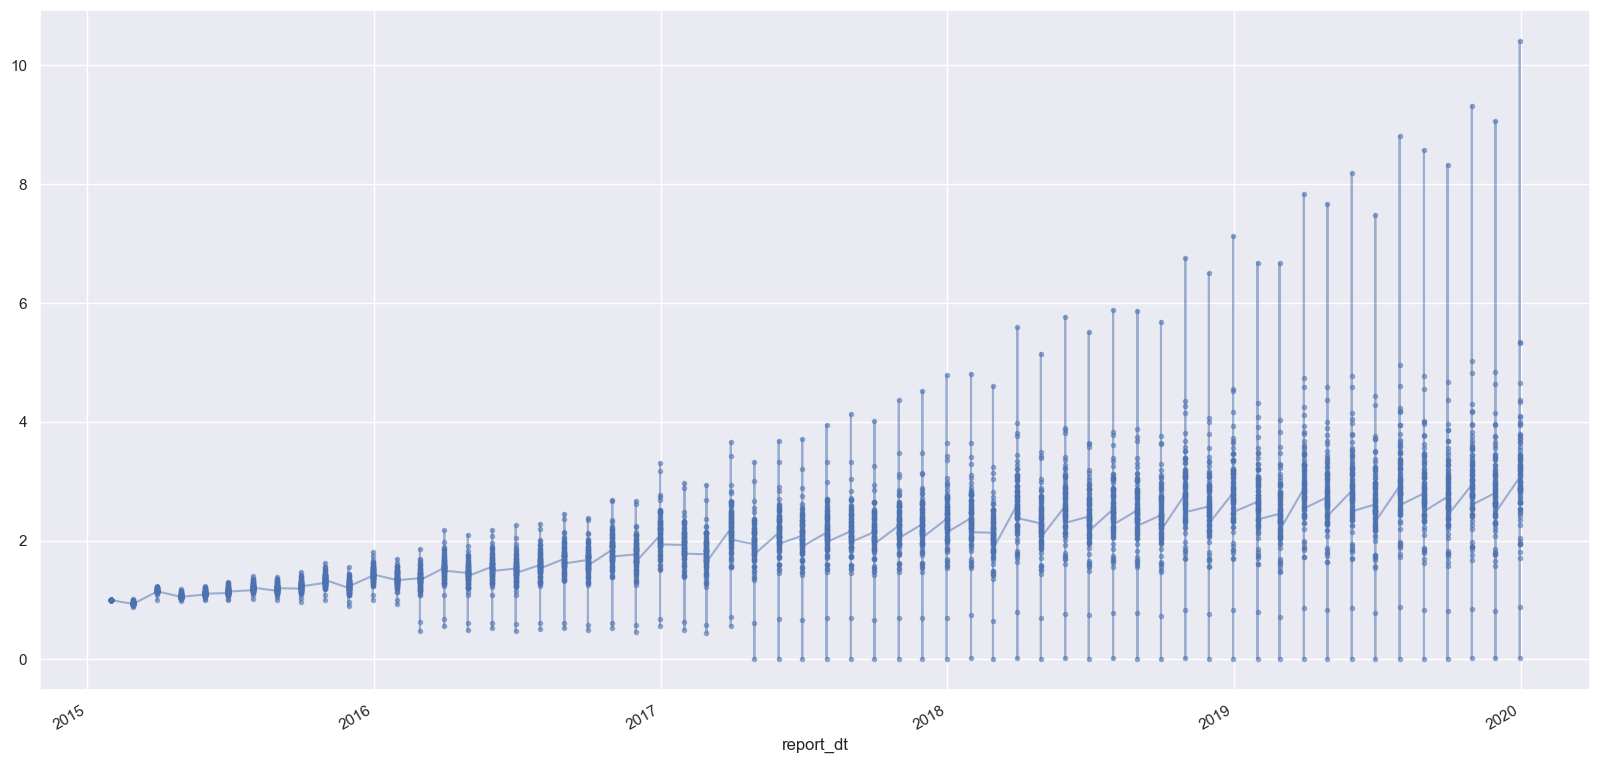

In [610]:
df['val'].plot(marker='.', alpha=0.5, linestyle='-', figsize=(20, 10), subplots=True)
plt.show()

В среднем от месяца к месяцу прослеживается сезонность. Особенно в феврале происходит спад, март, май выделяются ростом. Гипотеза 1. Разница вызвана числом дней в месяце.
Во второй половине года тоже наблюдается сезонность, но из-за возрастающего тренда в ноябре (30 календарных дней) комиссионные доходы в среднем выше, чем даже в марте, июле и августе

Мы можем наюлюдать сильный возрастающий тренд - от года к году комиссионный доход в млн. рублей растет

In [611]:
df['territ_subdiv_2'].value_counts()

territ_subdiv_2
2     660
3     600
4     600
1     567
5     540
6     540
7     480
8     480
9     300
10    240
11    120
12     60
13     60
14     60
15     60
Name: count, dtype: int64

In [612]:
df['territ_subdiv_1'].value_counts()

territ_subdiv_1
5     900
8     660
10    600
6     567
2     540
7     480
9     480
11    480
1     360
3     240
4      60
Name: count, dtype: int64

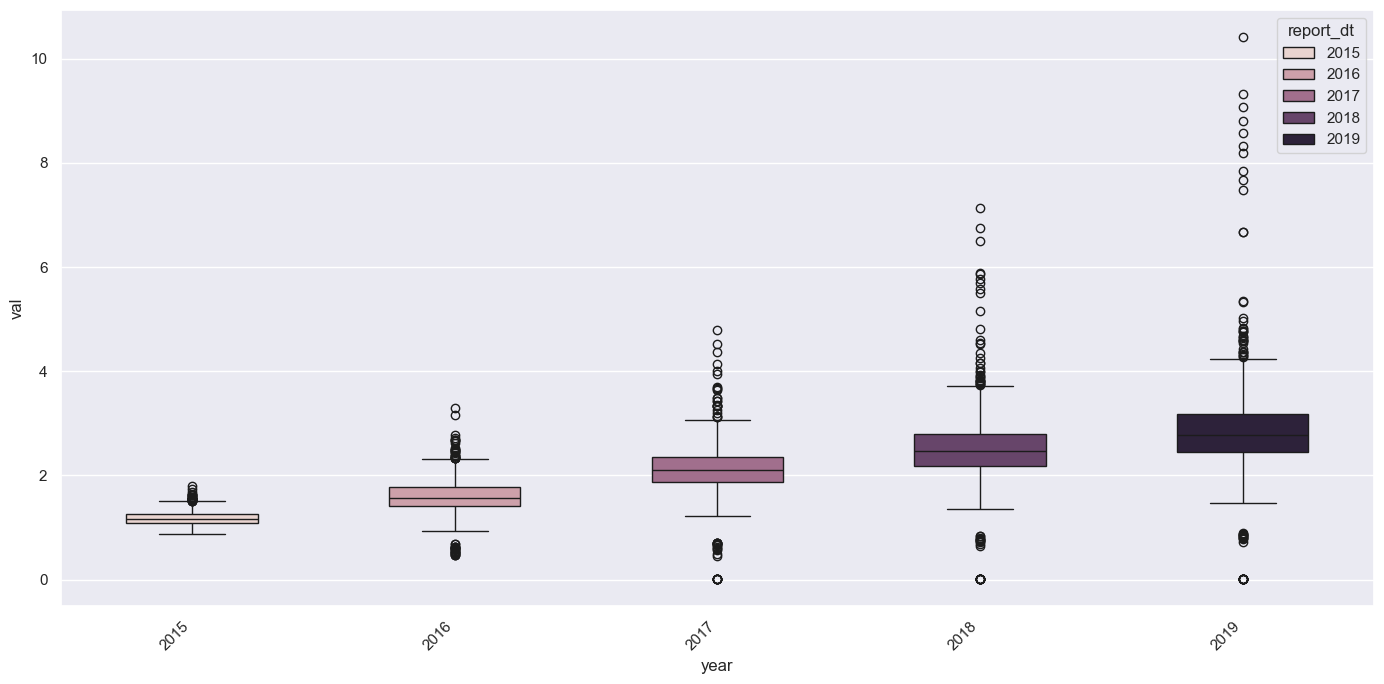

In [613]:
plt.figure(figsize=(14, 7))  # Увеличиваем размер фигуры
g = sns.boxplot(data=df, x=df.index.year, y='val', hue=df.index.year, width=0.5, dodge=False)

# Улучшаем визуализацию
g.set_xticklabels(g.get_xticklabels(), rotation=45, horizontalalignment='right')
g.set_ylabel('val')
g.set_xlabel('year')
plt.tight_layout()  # Подгоняем размеры фигуры под содержимое
plt.show()

## Поиск аномалий

In [614]:
def plot_an(data,  anomalies =None, column = 'val', figsize = (18,6), ax=None,
             fill_an = False, score_column=None, anomaly_column = None):

    if ax == None:
        fig, ax = plt.subplots(figsize=figsize)

    y = data[column].values.reshape(-1, 1)
    ax.plot(data.index, y, c='k', label = column, zorder=10)

    if  anomalies is not None:
        if anomaly_column is None:
            anomaly_column = column

        anomalies = pd.DataFrame(anomalies, columns=[anomaly_column, score_column])

        idxs = pd.DataFrame(anomalies).loc[anomalies[anomaly_column] ==True].index
        an_data = pd.DataFrame(data.loc[idxs,column] )

        y_an = an_data.values.reshape(-1, 1)

        if fill_an:
            idx = data.index
            points = [{'fp':idx[i-1], 'lp':idx[i+1]} for i in range(1,len(idx)-1) if anomalies.iloc[i].Consumption==True]
            points = pd.DataFrame(points)
            [ax.axvspan(points.fp[i], points.lp[i], alpha=.5, color='green', zorder=2) for i in range(len(points))];

        an_size = 20
        if score_column is not None:
            score_ = anomalies.loc[anomalies[score_column] !=0,score_column].values.squeeze()
            an_size = 40*np.abs(score_)

        ax.scatter(an_data.index, y_an, marker='o', s=an_size, color = 'red', label = 'Anomaly', zorder=100 )
    l = plt.legend()
    l.set_zorder(2000)

    return ax

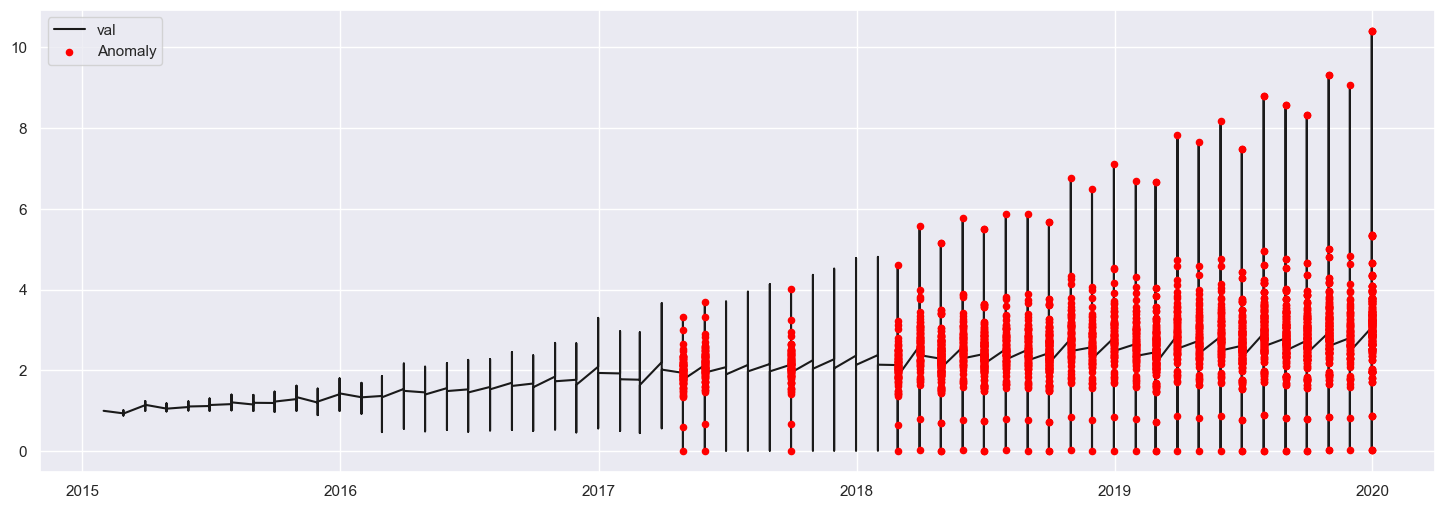

In [615]:
from sklearn.ensemble import IsolationForest

y = df.val.values.reshape(-1, 1)


outliers_fraction = 0.007

model =  IsolationForest(contamination=outliers_fraction)
df['anomaly'] = model.fit_predict(y)
an = pd.DataFrame(df['anomaly']==-1).rename(columns={'anomaly':'val'})

plot_an(df, an);

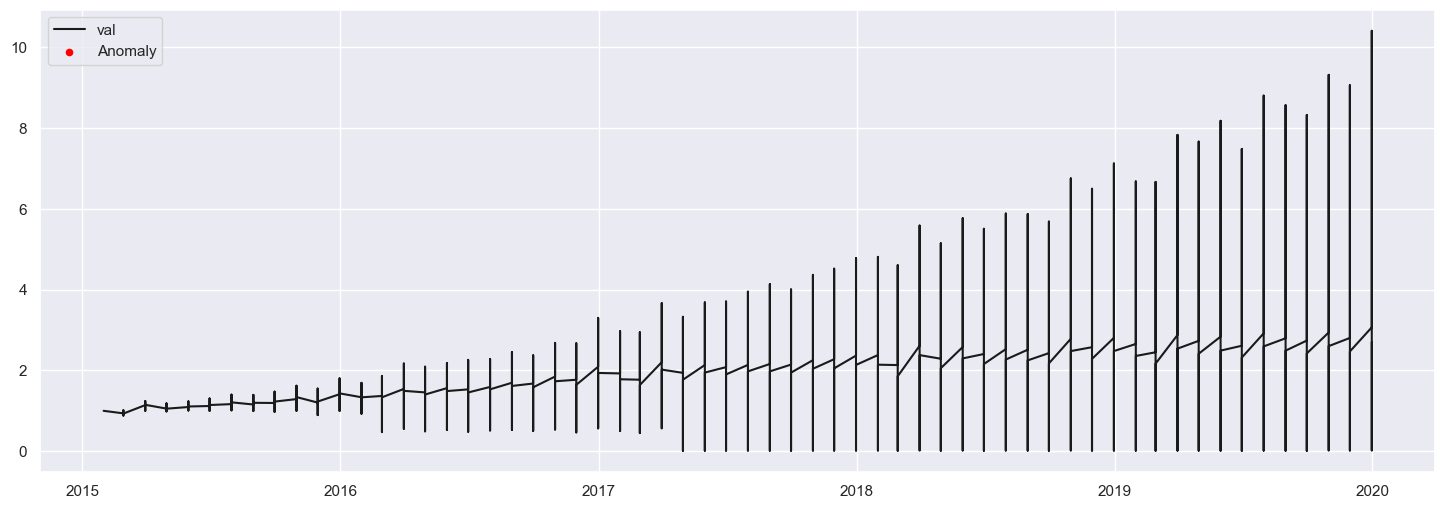

In [616]:
model = LocalOutlierFactor(novelty=True)
model.fit(y)
df['anomaly'] = model.predict(y)
an = pd.DataFrame(df['anomaly']==-1).rename(columns={'anomaly':'Consumption'})

plot_an(df, an);

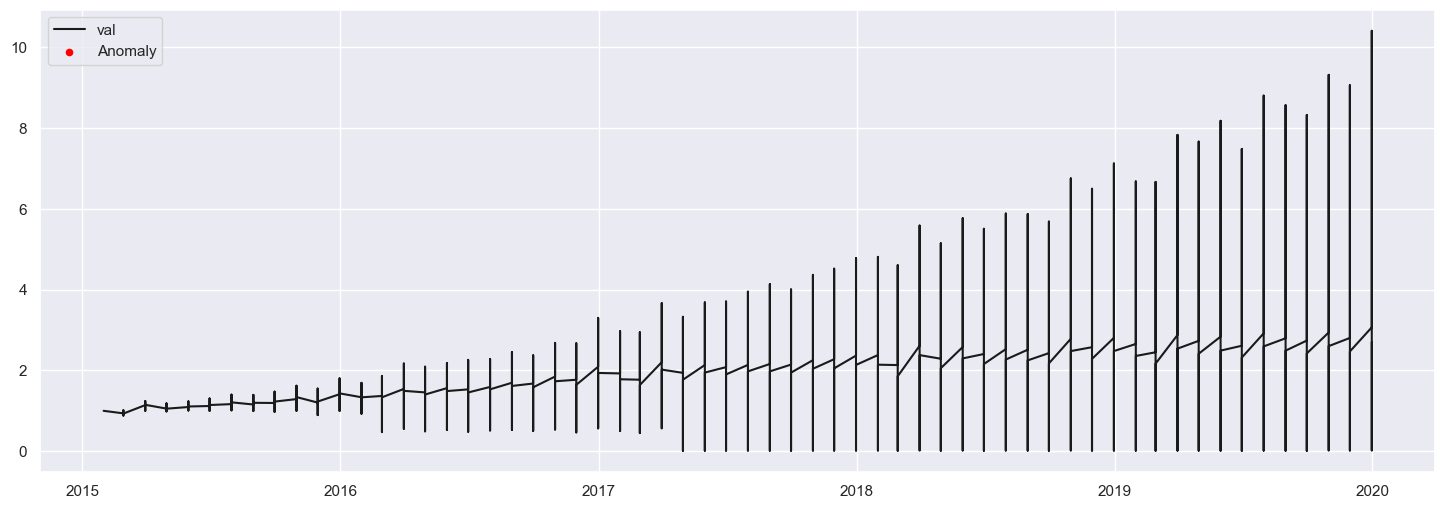

In [617]:
from sklearn.cluster import KMeans
model = KMeans(n_clusters=10)
model.fit(y)
df['anomaly'] = model.fit_predict(y)
an = pd.DataFrame(df['anomaly']==-1).rename(columns={'anomaly':'Consumption'})
plot_an(df, an);

Мы не знаем по какой именно статье доходов идет анализ данных, однако можно выдвинуть гипотизу о том, что промежутке времени в 5 лет есть еще внешние факторы, которые могут влиять. В финансах это в первую очередь - ключевая ставка в экономике. Я взял данные по ключевой ставке с 2015г. по 2024г. на сайте ЦБ рф. Данные занес в тяблицу по принципу - ключевая ставка на последний календарный день месяца. Добавим ее в таблицу для анализа

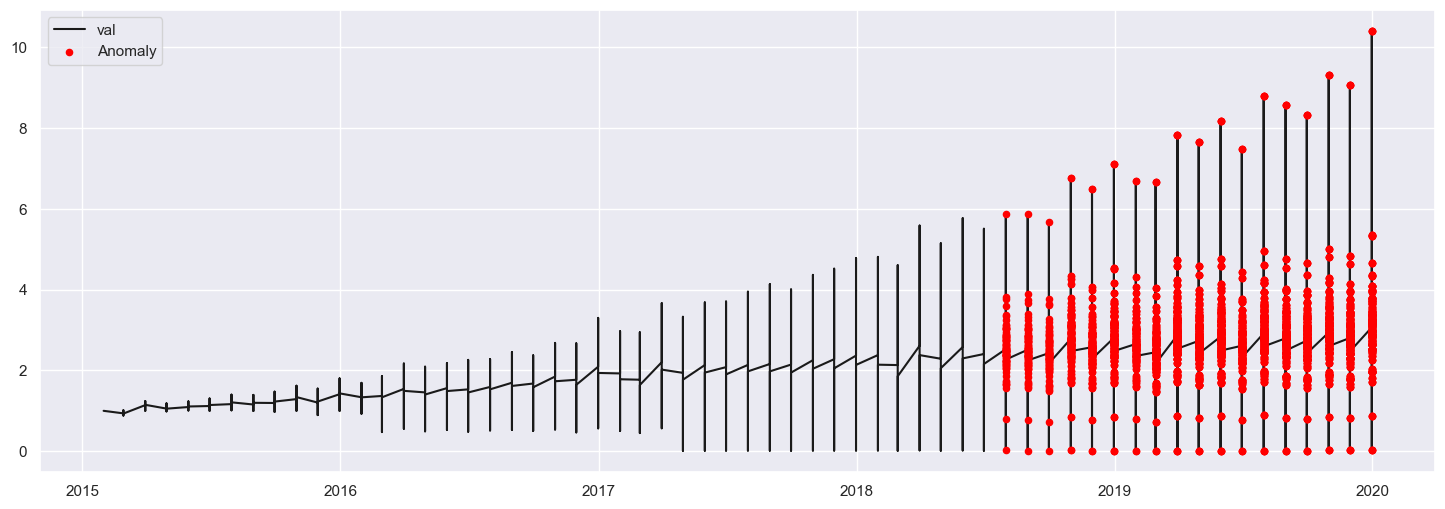

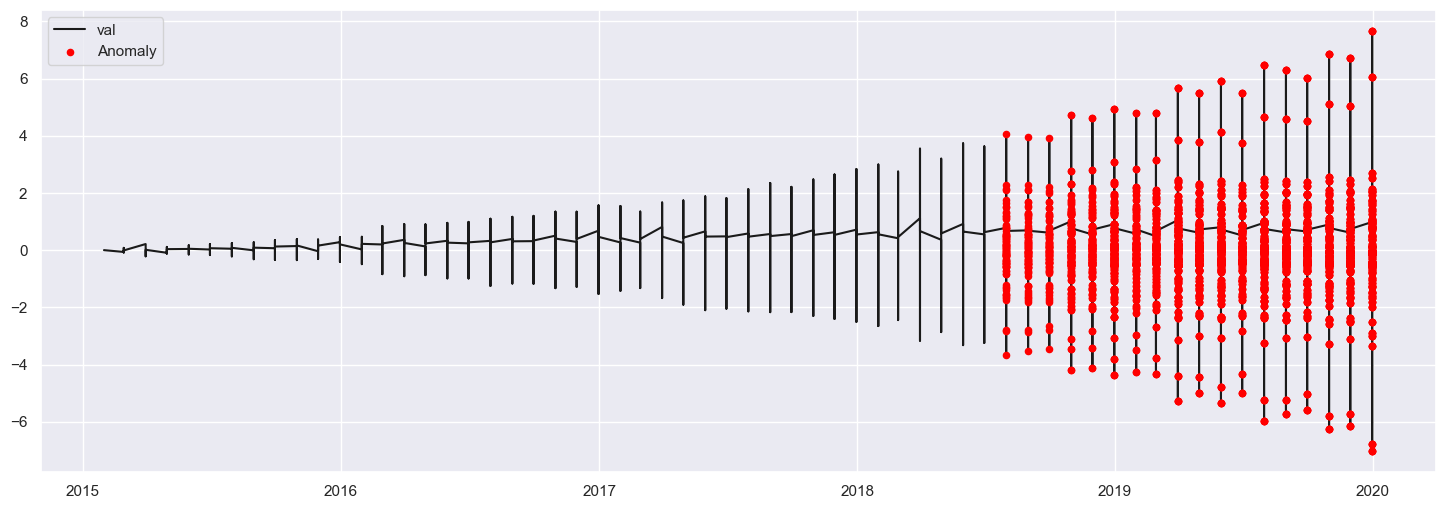

In [618]:
from adtk.detector import QuantileAD

quantile_ad = QuantileAD(high=0.995, low=0.005)
anomalies = quantile_ad.fit_detect(df.val.diff(1).diff(24))
plot_an(df, anomalies);
plot_an(pd.DataFrame(df.val.diff(1).diff(24)).dropna(), anomalies);

Анализируя весь датасет целиком мы не можем понять есть анамалии в данных или нет. В некоторых отделах комиссиионный доход может быть кратно выше, чем в других. Пропущенных значений в данных у нас также нет. В каком-либо конкретном отделе могут быть аномалии, но поскольку, у нас мало данных для каждого конкретного отдела и в целом, разбег не очень большой между самыми низкими и высокимыми показателями VAL мы не будем обрабатывать эти случаи.

Так как нам необходимо сформировать прогноз по всем подразделеням сделаем столбец division_name в котором сконкатенируем название из столбцов  
•	territ_subdiv_1: первый уровень дробления по территориям  
•	territ_subdiv_2: второй уровень дробления по территориям


In [619]:
df['division_name'] = df['territ_subdiv_1'].astype(str) + '-' + df['territ_subdiv_2'].astype(str)
df

territ_subdiv_1  territ_subdiv_2       val  anomaly division_name
report_dt                                                                    
2015-01-31                1                1  1.000000        7           1-1
2015-01-31                1                2  1.000000        7           1-2
2015-01-31                1                3  1.000000        7           1-3
2015-01-31                1                4  1.000000        7           1-4
2015-01-31                1                5  1.000000        7           1-5
...                     ...              ...       ...      ...           ...
2019-12-31               11                4  2.881561        8          11-4
2019-12-31               11                5  2.876725        8          11-5
2019-12-31               11                6  2.979735        8          11-6
2019-12-31               11                7  1.810171        9          11-7
2019-12-31               11                8  2.701395        8          11-8

[5367 rows x 5 columns]

In [620]:
df.division_name.value_counts()

division_name
1-1     60
9-4     60
9-2     60
9-1     60
8-11    60
        ..
5-8     60
5-7     60
5-6     60
11-8    60
6-1     27
Name: count, Length: 90, dtype: int64

In [621]:
df.division_name.value_counts().values

array([60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60,
       60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60,
       60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60,
       60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60,
       60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60,
       60, 60, 60, 60, 27], dtype=int64)

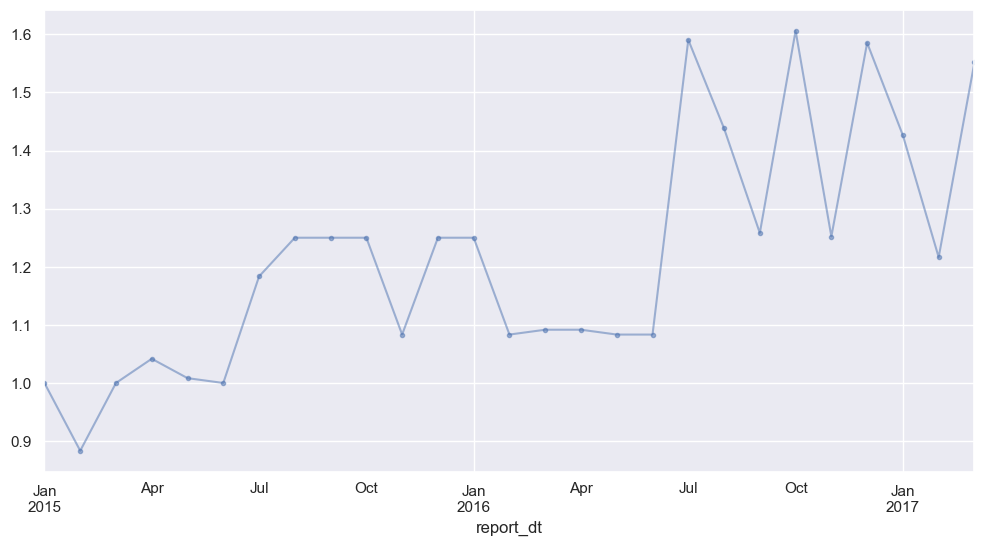

In [622]:
df[df.division_name == '6-1']['val'].plot(marker='.', alpha=0.5, linestyle='-', figsize=(12, 6), subplots=True)
plt.show()

Всего у нас 90 подразделений. Во всех подразделениях данные присутсвуют за весь период, кроме 1, в нем есть данные только за 27 месяцев. Здесь может быть 2 варианта, или филлиал закрылся и нам нет смысла делать прогноз, или данные утеряны. В последнем случае мы можем восстановить временной ряд. Для этого мы сможем использовать сезонную компоненту и компоненту тренда, которую мы вычислим по остальным подразделеням датасета.

Попробуем сделать предсказания разными методами для всех данных, исключая подразделение 6-1 с неполными данными. Выделим сегзонную компоненту и компоненту тренда, а также выберем самый эффективный способ предсказания и подберем ждя него оптимальные параметры

In [656]:
df = df[['division_name', 'val']]

In [657]:
df.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 5367 entries, 2015-01 to 2019-12
Freq: M
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   division_name  5367 non-null   object 
 1   val            5367 non-null   float64
dtypes: float64(1), object(1)
memory usage: 125.8+ KB


In [658]:
y = df[df.division_name != '6-1']['val']

In [659]:
y.info()

<class 'pandas.core.series.Series'>
PeriodIndex: 5340 entries, 2015-01 to 2019-12
Freq: M
Series name: val
Non-Null Count  Dtype  
--------------  -----  
5340 non-null   float64
dtypes: float64(1)
memory usage: 83.4 KB


In [660]:
y_mean = df.groupby(df.index)['val'].mean().reset_index()

y_mean.columns = ['date', 'mean']

y_mean.set_index('date', inplace=True)

Check splitted data size: Train: 36, Test: 24


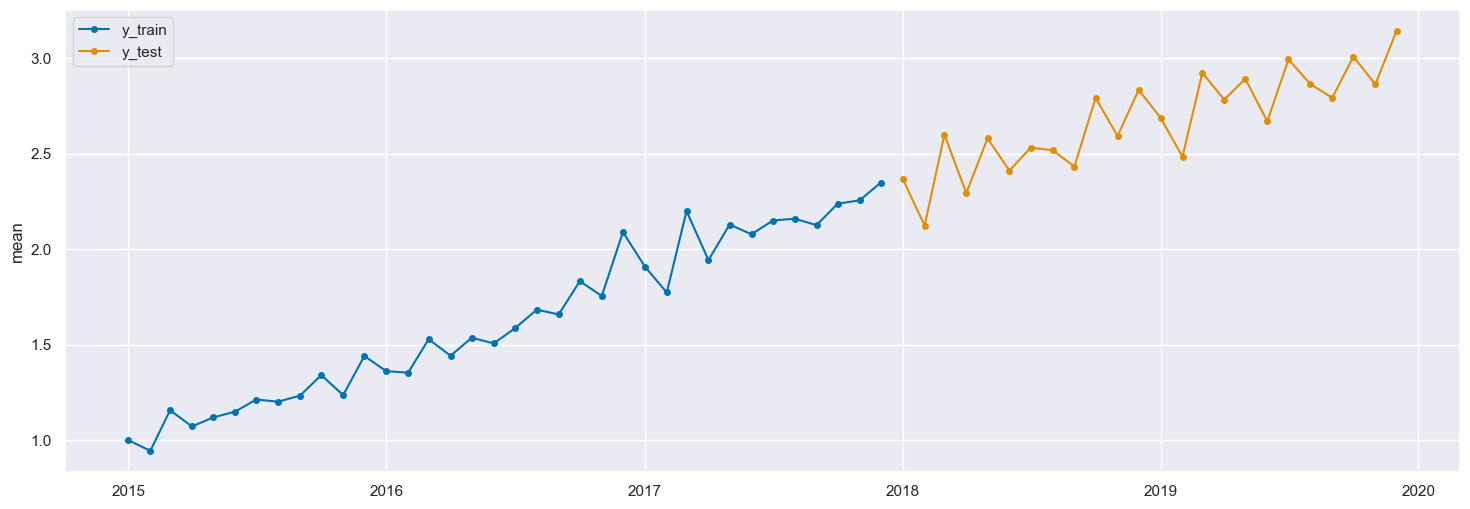

In [661]:
TEST_SIZE = int(0.4*y_mean.shape[0])
y_train, y_test = temporal_train_test_split(y_mean, test_size=TEST_SIZE)
print(f'Check splitted data size: Train: {y_train.shape[0]}, Test: {y_test.shape[0]}')
fig, ax = plt.subplots(figsize=(18, 6))
plot_series(y_train, y_test, labels=["y_train", "y_test"], ax=ax)
plt.show()

Сделаем прогноз коммиссионного дохода по SARIMAX для тестовой выборки

In [ ]:
y_train.index.freq = 'M'
y_test.index.freq = 'M'

y_train.index = pd.PeriodIndex(y_train.index, freq='M')
y_test.index = pd.PeriodIndex(y_test.index, freq='M')

In [ ]:
param_grid = {
    'order': [(1, 0, 0), (2, 0, 0), (1, 0, 1), (0, 0, 1), (1, 1, 1), (0, 1, 1), (0, 0, 0), 
              (1, 1, 0), (2, 1, 0), (2, 1, 1), (2, 2, 1), (1, 1, 2), (1, 2, 2), (0, 1, 2), 
              (2, 0, 1), (2, 1, 2), (2, 0, 2), (1, 2, 1), (0, 2, 1), (1, 2, 0), (1, 1, 3), (0, 1, 4)],
    'seasonal_order': [((0, 0, 0, 0),), ((1, 1, 0, 12),), ((1, 1, 1, 12), ), ((0, 1, 2, 4),), ((0, 1, 2, 6),)]
}

sarimax_model = sktime_sarimax(order=(1, 0, 0), seasonal_order=(1, 0, 0, 12))

sarimax_model.fit(y_train)

gscv = ForecastingGridSearchCV(
    forecaster=sarimax_model, 
    param_grid=param_grid, 
    cv=SlidingWindowSplitter(initial_window=int(len(y_train) * 0.5)),
    scoring=smape,
)

gscv.fit(y_train)

best_model = gscv.best_estimator_

best_params = gscv.best_params_

In [745]:
best_params = {
    'order': (0, 1, 4),
    'seasonal_order': (0, 1, 2, 6)
}

sMAPE = 0.021


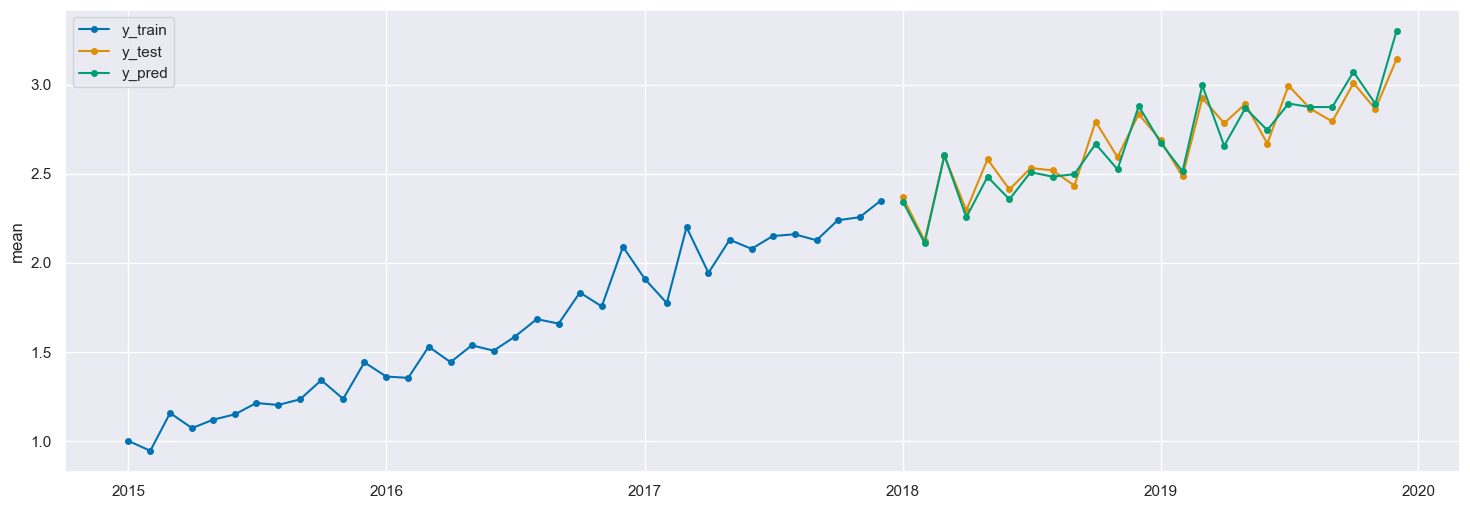

In [665]:
forecaster = TransformedTargetForecaster([
    ("deseasonalise", Deseasonalizer(model="multiplicative", sp=12)),
    ("forecast", sktime_sarimax(order=best_params['order'], seasonal_order=best_params['seasonal_order'])),
])

forecaster.fit(y_train)

fh = ForecastingHorizon(y_test.index, is_relative=False)

y_pred = forecaster.predict(fh)

fig, ax = plt.subplots(figsize=(18, 6))
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"], ax=ax)

print(f'sMAPE = {smape(y_pred.values, y_test.values):.3f}')

In [ ]:
y_6_1 = df[df.division_name == '6-1']['val']

y_6_1.index.freq = 'M'

y_6_1.index = pd.PeriodIndex(y_6_1.index, freq='M')


forecaster = TransformedTargetForecaster([
    ("deseasonalise", Deseasonalizer(model="multiplicative", sp=12)),
    ("forecast", sktime_sarimax(order=best_params['order'], seasonal_order=best_params['seasonal_order'])),
])

forecaster.fit(y_6_1)

last_period = y_6_1.index[-1]
fh = ForecastingHorizon(pd.period_range(start=last_period + 1, periods=33, freq='M'))

y_pred = forecaster.predict(fh)

fig, ax = plt.subplots(figsize=(18, 6))
plot_series(y_6_1, y_pred, labels=["Historical data ('6-1')", "Forecast"], ax=ax)

plt.show()

In [639]:
df_6_1 = pd.concat([y_6_1, y_pred], axis=1)
df_6_1.columns = ['Historical Data', 'Forecast']

In [640]:
df_6_1['val'] = df_6_1.apply(lambda x: x['Historical Data'] if pd.isna(x['Forecast']) else x['Forecast'], axis=1)
df_6_1 = df_6_1.drop(['Historical Data','Forecast'], axis=1)

In [644]:
df_6_1['division_name'] = '6-1'

In [646]:
df_6_1['val'], df_6_1['division_name'] = df_6_1['division_name'].copy(), df_6_1['val'].copy()

In [647]:
df_6_1 = df_6_1.rename(columns={'val': 'division_name', 'division_name': 'val'})

In [648]:
df.index = df.index.to_period('M')

In [649]:
df_6_1.index.name = 'report_dt'

In [650]:
df.head()

division_name  val
report_dt                   
2015-01             1-1  1.0
2015-01             1-2  1.0
2015-01             1-3  1.0
2015-01             1-4  1.0
2015-01             1-5  1.0

In [651]:
df_6_1.head()

division_name       val
report_dt                        
2015-01             6-1  1.000000
2015-02             6-1  0.883333
2015-03             6-1  1.000000
2015-04             6-1  1.041666
2015-05             6-1  1.008333

In [652]:
df_6_1.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 60 entries, 2015-01 to 2019-12
Freq: M
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   division_name  60 non-null     object 
 1   val            60 non-null     float64
dtypes: float64(1), object(1)
memory usage: 1.4+ KB


In [653]:
df_merged = df.merge(df_6_1.reset_index(), left_on=['report_dt', 'division_name'], right_on=['report_dt', 'division_name'], how='outer')

In [654]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5400 entries, 0 to 5399
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype    
---  ------         --------------  -----    
 0   report_dt      5400 non-null   period[M]
 1   division_name  5400 non-null   object   
 2   val_x          5367 non-null   float64  
 3   val_y          60 non-null     float64  
dtypes: float64(2), object(1), period[M](1)
memory usage: 168.9+ KB


In [468]:
df_merged.sample(10)

report_dt division_name     val_x     val_y
145    2015-02           6-2  0.938587       NaN
5175   2019-10           5-2  2.562100       NaN
2550   2017-05           2-7  2.385927       NaN
4823   2019-06           6-1       NaN  2.226523
4641   2019-04           5-8  2.338989       NaN
1021   2015-12           2-8  1.397100       NaN
494    2015-06          5-15  1.015658       NaN
3351   2018-02          11-6  2.022131       NaN
3165   2017-12          10-9  2.704412       NaN
4001   2018-09          5-12  2.510262       NaN

In [469]:
df_merged['val'] = df_merged.apply(lambda x: x['val_x'] if pd.isna(x['val_y']) else x['val_y'], axis=1)

In [470]:
df = df_merged.drop(['val_x', 'val_y'], axis=1)

In [471]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5400 entries, 0 to 5399
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype    
---  ------         --------------  -----    
 0   report_dt      5400 non-null   period[M]
 1   division_name  5400 non-null   object   
 2   val            5400 non-null   float64  
dtypes: float64(1), object(1), period[M](1)
memory usage: 126.7+ KB


теперь к данному датафрейму необходимо добавить данные из другого датафрейма

In [483]:
rate = pd.read_excel(datafile, sheet_name = 'rate', index_col='date')
rate.index.name = 'report_dt'
rate.index = rate.index.to_period('M')
rate = rate.sort_index()
rate = rate.head(72)

In [484]:
rate

rate
report_dt        
2015-01    0.1700
2015-02    0.1500
2015-03    0.1400
2015-04    0.1400
2015-05    0.1250
...           ...
2020-08    0.0425
2020-09    0.0425
2020-10    0.0425
2020-11    0.0425
2020-12    0.0425

[72 rows x 1 columns]

In [516]:
unique_division_names = df['division_name'].unique()

periods = pd.period_range(start='2015-01', end='2020-12', freq='M')
combinations = list(itertools.product(periods, unique_division_names))
index = pd.MultiIndex.from_tuples(combinations, names=['report_dt', 'division_name'])

df_complete = pd.DataFrame(index=index).reset_index()

df_complete.set_index(['report_dt', 'division_name'], inplace=True)

df_complete = df_complete.join(df.set_index(['report_dt', 'division_name']), how='left')

df_complete = df_complete.join(rate, how='left')

df_complete['rate'].fillna(method='ffill', inplace=True)

df_complete.reset_index(inplace=True)

df_complete.sort_values(by=['report_dt', 'division_name'], inplace=True)
df_complete.set_index('report_dt', inplace=True)

          division_name  val  rate
report_dt                         
2015-01             1-1  1.0  0.17
2015-01             1-2  1.0  0.17
2015-01             1-3  1.0  0.17
2015-01             1-4  1.0  0.17
2015-01             1-5  1.0  0.17
<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 6480 entries, 2015-01 to 2020-12
Freq: M
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   division_name  6480 non-null   object 
 1   val            5400 non-null   float64
 2   rate           6480 non-null   float64
dtypes: float64(2), object(1)
memory usage: 202.5+ KB


In [517]:
df_complete

division_name  val    rate
report_dt                           
2015-01             1-1  1.0  0.1700
2015-01             1-2  1.0  0.1700
2015-01             1-3  1.0  0.1700
2015-01             1-4  1.0  0.1700
2015-01             1-5  1.0  0.1700
...                 ...  ...     ...
2020-12             9-4  NaN  0.0425
2020-12             9-5  NaN  0.0425
2020-12             9-6  NaN  0.0425
2020-12             9-7  NaN  0.0425
2020-12             9-8  NaN  0.0425

[6480 rows x 3 columns]

In [491]:
df_complete.sort_values(by=['report_dt', 'division_name'], inplace=True)
df_complete.set_index('report_dt', inplace=True)
print(df_complete.head())

          division_name  rate
report_dt                    
2015-01             1-1  0.17
2015-01             1-2  0.17
2015-01             1-3  0.17
2015-01             1-4  0.17
2015-01             1-5  0.17


In [492]:
df_complete.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 6480 entries, 2015-01 to 2020-12
Freq: M
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   division_name  6480 non-null   object 
 1   rate           6480 non-null   float64
dtypes: float64(1), object(1)
memory usage: 151.9+ KB


In [532]:
df_complete.sample(10)

division_name       val    rate
report_dt                                
2018-07            10-5  2.541868  0.0750
2019-08             5-1  0.829618  0.0725
2016-01            10-2  1.512026  0.1100
2015-07             9-6  1.224930  0.1150
2017-10             2-8  2.118952  0.0825
2019-08             7-2  4.545933  0.0725
2015-04             9-4  1.093052  0.1400
2019-06             5-8  2.245731  0.0750
2017-03             8-7  2.477592  0.0975
2015-08            10-4  1.083967  0.1100

In [533]:
df_complete.to_csv('df.csv')

In [4]:
df = pd.read_csv('df.csv', index_col='report_dt')

df .index = pd.to_datetime(df.index).to_period('M')

df.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 6480 entries, 2015-01 to 2020-12
Freq: M
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   division_name  6480 non-null   object 
 1   val            5400 non-null   float64
 2   rate           6480 non-null   float64
dtypes: float64(2), object(1)
memory usage: 202.5+ KB


In [5]:
df

division_name  val    rate
report_dt                           
2015-01             1-1  1.0  0.1700
2015-01             1-2  1.0  0.1700
2015-01             1-3  1.0  0.1700
2015-01             1-4  1.0  0.1700
2015-01             1-5  1.0  0.1700
...                 ...  ...     ...
2020-12             9-4  NaN  0.0425
2020-12             9-5  NaN  0.0425
2020-12             9-6  NaN  0.0425
2020-12             9-7  NaN  0.0425
2020-12             9-8  NaN  0.0425

[6480 rows x 3 columns]

In [6]:
df_train = df[~df['val'].isna()]
df_test = df[df['val'].isna()]

In [7]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 5400 entries, 2015-01 to 2019-12
Freq: M
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   division_name  5400 non-null   object 
 1   val            5400 non-null   float64
 2   rate           5400 non-null   float64
dtypes: float64(2), object(1)
memory usage: 168.8+ KB


In [8]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 1080 entries, 2020-01 to 2020-12
Freq: M
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   division_name  1080 non-null   object 
 1   val            0 non-null      float64
 2   rate           1080 non-null   float64
dtypes: float64(2), object(1)
memory usage: 33.8+ KB


In [9]:
correlation = df_train['val'].corr(df_train['rate'])
print(f"Корреляция между 'val' и 'rate' в тренировочной выборке: {correlation}")

Корреляция между 'val' и 'rate' в тренировочной выборке: -0.6868104452621978


In [10]:
train_start = '2015-01'
train_end = '2018-12'
valid_start = '2019-01'
valid_end = '2019-12'

SMAPE for 1-1: 0.0527
SMAPE for 1-2: 0.0478
SMAPE for 1-3: 0.0380
SMAPE for 1-4: 0.0729
SMAPE for 1-5: 0.0543
SMAPE for 1-6: 0.0407
SMAPE for 10-1: 0.0344
SMAPE for 10-10: 0.0393
SMAPE for 10-2: 0.0583
SMAPE for 10-3: 0.0236
SMAPE for 10-4: 0.0456
SMAPE for 10-5: 0.0636
SMAPE for 10-6: 0.0778
SMAPE for 10-7: 0.0407
SMAPE for 10-8: 0.0616
SMAPE for 10-9: 0.0569
SMAPE for 11-1: 0.0327
SMAPE for 11-2: 0.0279
SMAPE for 11-3: 0.0224
SMAPE for 11-4: 0.0203
SMAPE for 11-5: 0.0435
SMAPE for 11-6: 0.0428
SMAPE for 11-7: 0.0212
SMAPE for 11-8: 0.0459
SMAPE for 2-1: 0.0328
SMAPE for 2-2: 0.0196
SMAPE for 2-3: 0.0545
SMAPE for 2-4: 0.0520
SMAPE for 2-5: 0.0307
SMAPE for 2-6: 0.0422
SMAPE for 2-7: 0.0561
SMAPE for 2-8: 0.0571
SMAPE for 2-9: 0.0325
SMAPE for 3-1: 0.0467
SMAPE for 3-2: 0.0296
SMAPE for 3-3: 0.0614
SMAPE for 3-4: 0.0177
SMAPE for 4-2: 0.0518
SMAPE for 5-1: 0.0680
SMAPE for 5-10: 0.0547
SMAPE for 5-11: 0.0343
SMAPE for 5-12: 0.0689
SMAPE for 5-13: 0.0558
SMAPE for 5-14: 0.0510
SMAPE fo

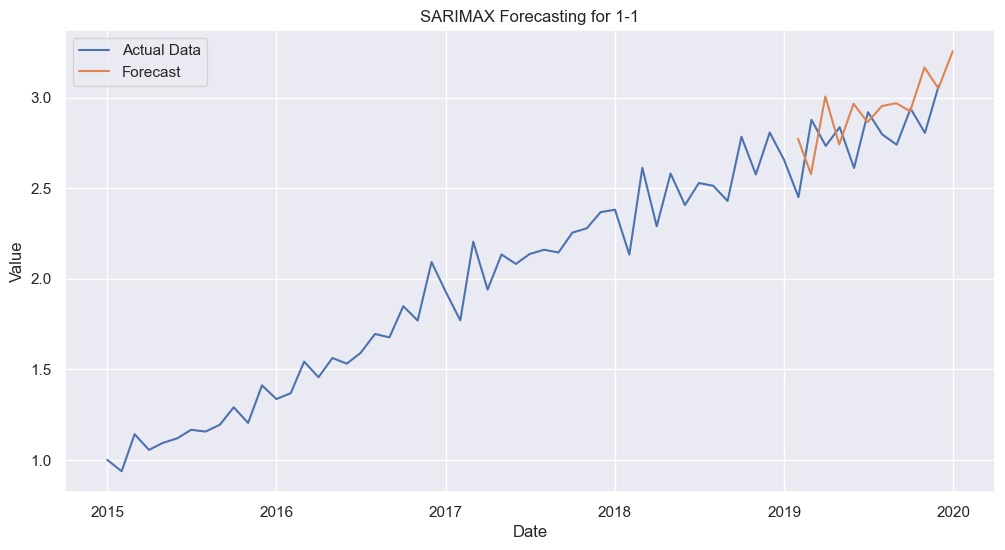

In [678]:
forecasts = []
smape_values = []

unique_division_names = df_train['division_name'].unique()
for division in unique_division_names:
    division_data = df_train[df_train['division_name'] == division]
    
    X_train = division_data[(division_data.index >= train_start) & (division_data.index <= train_end)]
    X_test = division_data[(division_data.index >= valid_start) & (division_data.index <= valid_end)]
    
    model = AutoARIMA(sp=12, suppress_warnings=True)
    model.fit(X_train['val'])
    
    forecast = model.predict(fh=np.arange(1, 13))
    
    forecast_df = pd.DataFrame({
        'report_dt': forecast.index,
        'division_name': division,
        'predicted_val': forecast.values
    })
    forecasts.append(forecast_df)
    
    actual_values = X_test['val'][:12]
    forecasted_values = forecast.values
    smape_value = smape(actual_values, forecasted_values)
    smape_values.append(smape_value)
    print(f'SMAPE for {division}: {smape_value:.4f}')

forecast_df = pd.concat(forecasts)

forecast_df.set_index('report_dt', inplace=True)

average_smape = np.mean(smape_values)
print(f'Average SMAPE across all divisions: {average_smape:.4f}')

example_division = unique_division_names[0]
plt.figure(figsize=(12, 6))

df_train_plot = df_train[df_train['division_name'] == example_division].copy()
df_train_plot.index = df_train_plot.index.to_timestamp()

plt.plot(df_train_plot.index, df_train_plot['val'], label='Actual Data')

forecast_plot = forecast_df[forecast_df['division_name'] == example_division]
plt.plot(forecast_plot.index, forecast_plot['predicted_val'], label='Forecast')

plt.xlabel('Date')
plt.ylabel('Value')
plt.title(f'ARIMA Forecasting for {example_division}')
plt.legend()
plt.show()

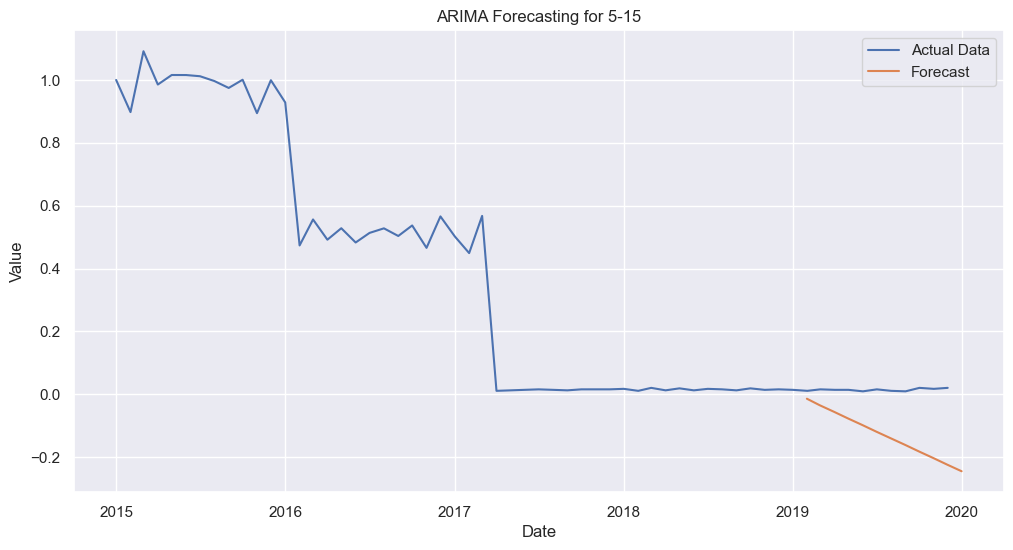

In [689]:
example_division = '5-15'
plt.figure(figsize=(12, 6))

df_train_plot = df_train[df_train['division_name'] == example_division].copy()
df_train_plot.index = df_train_plot.index.to_timestamp()

plt.plot(df_train_plot.index, df_train_plot['val'], label='Actual Data')

forecast_plot = forecast_df[forecast_df['division_name'] == example_division]
plt.plot(forecast_plot.index, forecast_plot['predicted_val'], label='Forecast')

plt.xlabel('Date')
plt.ylabel('Value')
plt.title(f'ARIMA Forecasting for {example_division}')
plt.legend()
plt.show()

Предсказания по всем дивизионам моделью Arima из библиотеки SKtime явлются относительно точными, кроме как для одного дивизиона. Начиная с марта 2017 года выручка стала двольно низкой и эти значения сохранались на низком уровне до 2020 года. Это необходимо учесть при итоговом прогнозе

Для того, чтобы протестировать другие модели будем использовтать только первые 1 - предсказаний. Посчитаем среднее значение smape для первых 10 пердсказаний.

In [691]:
division_for_test = ['1-1','1-2','1-3','1-4','1-5','1-6', '10-1', '10-2', '10-3', '10-4']

In [692]:
smape_values[:10]

[0.052668298705979257,
 0.04778359461319872,
 0.03804524443730633,
 0.07290461537205653,
 0.05433054013018551,
 0.04070831099940236,
 0.034446544041713476,
 0.03932271487244885,
 0.05830640721597056,
 0.023633827898078913]

In [694]:
arima_mean = np.round(np.mean(smape_values[:10]), 4)
arima_mean

0.0462

SMAPE for 1-1: 0.0313
SMAPE for 1-2: 0.0311
SMAPE for 1-3: 0.0219
SMAPE for 1-4: 0.0466
SMAPE for 1-5: 0.0478
SMAPE for 1-6: 0.0222
SMAPE for 10-1: 0.0417
SMAPE for 10-2: 0.0378
SMAPE for 10-3: 0.0876
SMAPE for 10-4: 0.0207
Average SMAPE across all divisions: 0.0389


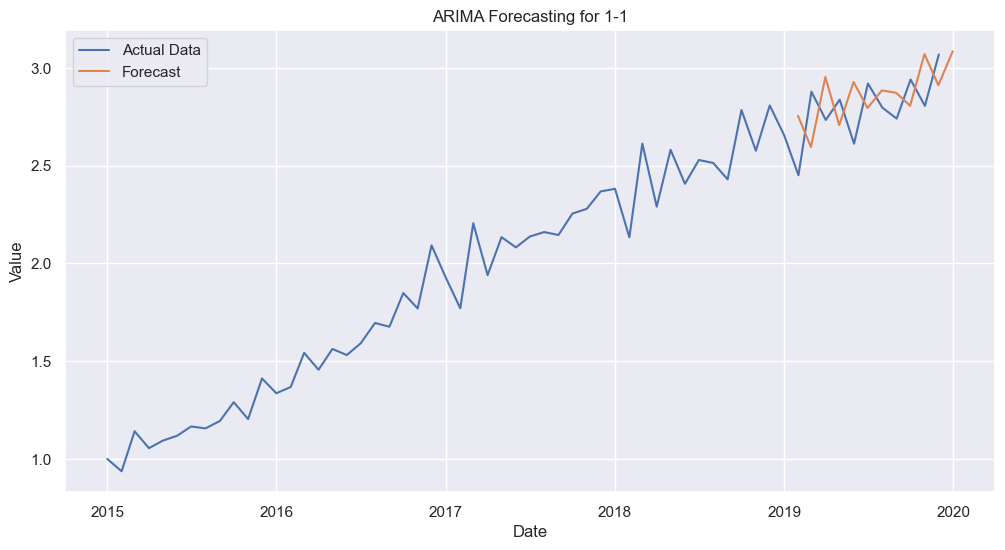

In [695]:
forecasts = []
smape_values = []

for division in division_for_test:
    division_data = df_train[df_train['division_name'] == division]
    
    X_train = division_data[(division_data.index >= train_start) & (division_data.index <= train_end)]
    X_test = division_data[(division_data.index >= valid_start) & (division_data.index <= valid_end)]
    
    model = AutoARIMA(sp=12, suppress_warnings=True)
    model.fit(y=X_train['val'], X=X_train[['rate']])
    
    forecast = model.predict(fh=np.arange(1, 13), X=X_test[['rate']])
    
    forecast_df = pd.DataFrame({
        'report_dt': forecast.index,
        'division_name': division,
        'predicted_val': forecast.values
    })
    forecasts.append(forecast_df)
    
    actual_values = X_test['val'][:12]
    forecasted_values = forecast.values
    smape_value = smape(actual_values, forecasted_values)
    smape_values.append(smape_value)
    print(f'SMAPE for {division}: {smape_value:.4f}')

forecast_df = pd.concat(forecasts)

forecast_df.set_index('report_dt', inplace=True)

average_smape = np.mean(smape_values)
print(f'Average SMAPE across all divisions: {average_smape:.4f}')

example_division = unique_division_names[0]
plt.figure(figsize=(12, 6))

df_train_plot = df_train[df_train['division_name'] == example_division].copy()
df_train_plot.index = df_train_plot.index.to_timestamp()

plt.plot(df_train_plot.index, df_train_plot['val'], label='Actual Data')

forecast_plot = forecast_df[forecast_df['division_name'] == example_division]
plt.plot(forecast_plot.index, forecast_plot['predicted_val'], label='Forecast')

plt.xlabel('Date')
plt.ylabel('Value')
plt.title(f'ARIMA Forecasting for {example_division}')
plt.legend()
plt.show()


In [696]:
best_params = {
    'order': (1, 1, 3),
    'seasonal_order': (0, 1, 2, 4)
}

SMAPE for 1-1: 0.0433
SMAPE for 1-2: 0.0275
SMAPE for 1-3: 0.0116
SMAPE for 1-4: 0.0285
SMAPE for 1-5: 0.0347
SMAPE for 1-6: 0.0263
SMAPE for 10-1: 0.0243
SMAPE for 10-2: 0.0412
SMAPE for 10-3: 0.0169
SMAPE for 10-4: 0.0391
Average SMAPE across 10 divisions: 0.0293


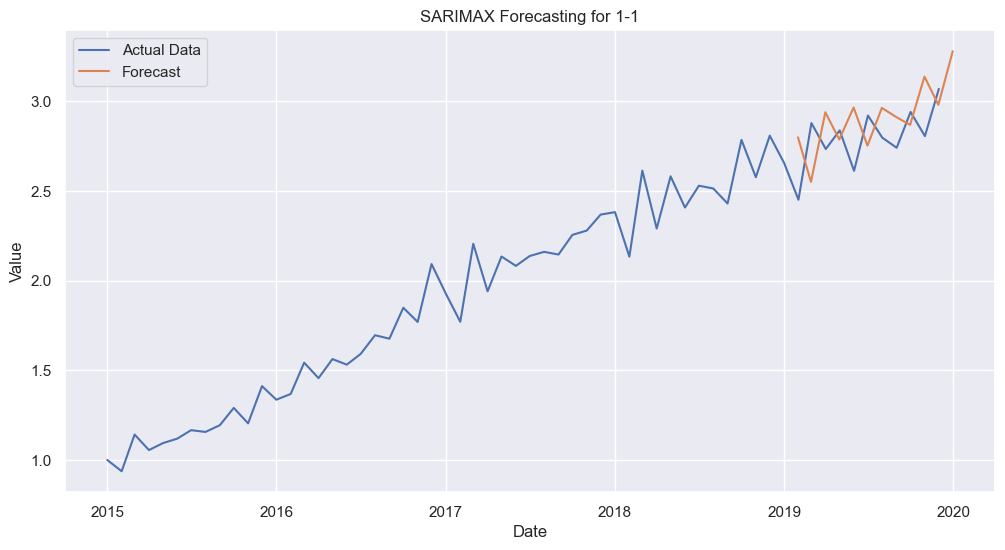

In [747]:
forecasts = []
smape_values = []

for division in division_for_test:
    division_data = df_train[df_train['division_name'] == division]
    
    X_train = division_data[(division_data.index >= train_start) & (division_data.index <= train_end)]
    X_test = division_data[(division_data.index >= valid_start) & (division_data.index <= valid_end)]
    
    forecaster = TransformedTargetForecaster([
        ("deseasonalise", Deseasonalizer(model="multiplicative", sp=12)),
        ("forecast", sktime_sarimax(order=best_params['order'], seasonal_order=best_params['seasonal_order']))
    ])
    
    forecaster.fit(y=X_train['val'])
    
    forecast = forecaster.predict(fh=np.arange(1, 13))
    
    forecast_df = pd.DataFrame({
        'report_dt': forecast.index,
        'division_name': division,
        'predicted_val': forecast.values
    })
    forecasts.append(forecast_df)
    
    actual_values = X_test['val'][:12]
    forecasted_values = forecast.values
    smape_value = smape(actual_values, forecasted_values, symmetric=True)
    smape_values.append(smape_value)
    print(f'SMAPE for {division}: {smape_value:.4f}')

forecast_df = pd.concat(forecasts)

forecast_df.set_index('report_dt', inplace=True)

average_smape = np.mean(smape_values)
print(f'Average SMAPE across 10 divisions: {average_smape:.4f}')

example_division = division_for_test[0]
plt.figure(figsize=(12, 6))

df_train_plot = df_train[df_train['division_name'] == example_division].copy()
df_train_plot.index = df_train_plot.index.to_timestamp()

plt.plot(df_train_plot.index, df_train_plot['val'], label='Actual Data')

forecast_plot = forecast_df[forecast_df['division_name'] == example_division]
plt.plot(forecast_plot.index, forecast_plot['predicted_val'], label='Forecast')

plt.xlabel('Date')
plt.ylabel('Value')
plt.title(f'SARIMAX Forecasting for {example_division}')
plt.legend()
plt.show()

SMAPE for 1-1: 0.0320
SMAPE for 1-2: 0.0153
SMAPE for 1-3: 0.0160
SMAPE for 1-4: 0.0173
SMAPE for 1-5: 0.0217
SMAPE for 1-6: 0.0162
SMAPE for 10-1: 0.0184
SMAPE for 10-2: 0.0236
SMAPE for 10-3: 0.0254
SMAPE for 10-4: 0.0202
Average SMAPE across 10 divisions: 0.0206


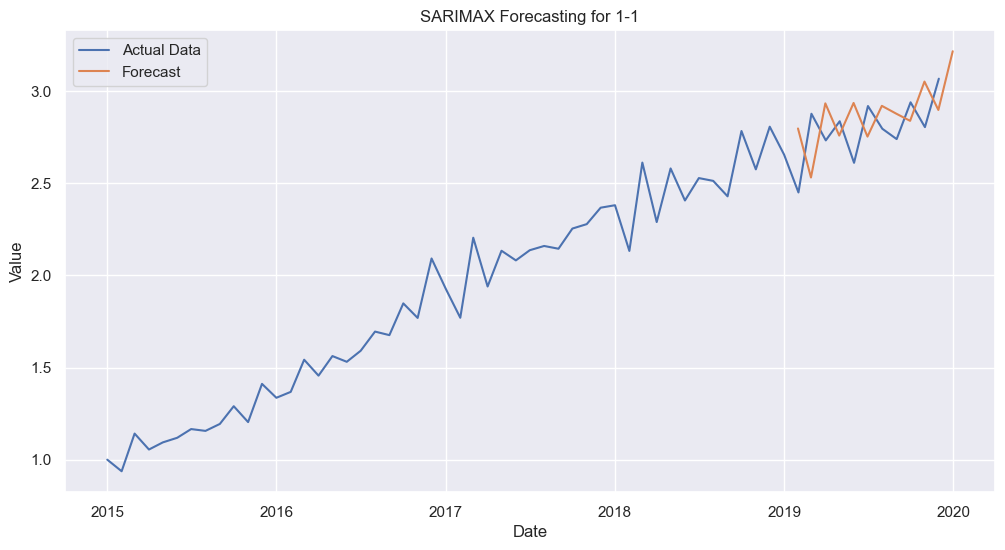

In [746]:
forecasts = []
smape_values = []

for division in division_for_test:
    division_data = df_train[df_train['division_name'] == division]
    
    X_train = division_data[(division_data.index >= train_start) & (division_data.index <= train_end)]
    X_test = division_data[(division_data.index >= valid_start) & (division_data.index <= valid_end)]

    forecaster = TransformedTargetForecaster([
        ("deseasonalise", Deseasonalizer(model="multiplicative", sp=12)),
        ("forecast", sktime_sarimax(order=best_params['order'], seasonal_order=best_params['seasonal_order']))
    ])
    
    forecaster.fit(y=X_train['val'], X=X_train[['rate']])
    
    forecast = forecaster.predict(fh=np.arange(1, 13), X=X_test[['rate']])
    
    forecast_df = pd.DataFrame({
        'report_dt': forecast.index,
        'division_name': division,
        'predicted_val': forecast.values
    })
    forecasts.append(forecast_df)

    actual_values = X_test['val'][:12]
    forecasted_values = forecast.values
    smape_value = smape(actual_values, forecasted_values, symmetric=True)
    smape_values.append(smape_value)
    print(f'SMAPE for {division}: {smape_value:.4f}')

forecast_df = pd.concat(forecasts)

forecast_df.set_index('report_dt', inplace=True)

average_smape = np.mean(smape_values)
print(f'Average SMAPE across 10 divisions: {average_smape:.4f}')

example_division = division_for_test[0]
plt.figure(figsize=(12, 6))

df_train_plot = df_train[df_train['division_name'] == example_division].copy()
df_train_plot.index = df_train_plot.index.to_timestamp()

plt.plot(df_train_plot.index, df_train_plot['val'], label='Actual Data')

forecast_plot = forecast_df[forecast_df['division_name'] == example_division]
plt.plot(forecast_plot.index, forecast_plot['predicted_val'], label='Forecast')

plt.xlabel('Date')
plt.ylabel('Value')
plt.title(f'SARIMAX Forecasting for {example_division}')
plt.legend()
plt.show()


In [765]:
df_train

division_name       val    rate report_dt
report_dt                                          
2015-01             1-1  1.000000  0.1700       NaT
2015-01             1-2  1.000000  0.1700       NaT
2015-01             1-3  1.000000  0.1700       NaT
2015-01             1-4  1.000000  0.1700       NaT
2015-01             1-5  1.000000  0.1700       NaT
...                 ...       ...     ...       ...
2019-12             9-4  2.812959  0.0625       NaT
2019-12             9-5  2.867635  0.0625       NaT
2019-12             9-6  3.270416  0.0625       NaT
2019-12             9-7  2.940419  0.0625       NaT
2019-12             9-8  2.914812  0.0625       NaT

[5400 rows x 4 columns]

In [814]:
train_start = '2015-01-01'
train_end = '2018-12-31'
valid_start = '2019-01-01'
valid_end = '2019-12-31'

In [815]:
df_train_p = df_train.copy()

In [816]:
df_train_p.index = df_train_p.index.to_timestamp()

In [817]:
df_train_p['report_dt'] = df_train_p.index
df_train_p = df_train_p.reset_index(drop=True)

In [828]:
df_train_p.head()

division_name  val  rate  report_dt
0           1-1  1.0  0.17 2015-01-01
1           1-2  1.0  0.17 2015-01-01
2           1-3  1.0  0.17 2015-01-01
3           1-4  1.0  0.17 2015-01-01
4           1-5  1.0  0.17 2015-01-01

17:43:22 - cmdstanpy - INFO - Chain [1] start processing
17:43:22 - cmdstanpy - INFO - Chain [1] done processing
17:43:22 - cmdstanpy - INFO - Chain [1] start processing


SMAPE for 1-1 (2019 forecast): 4.4158


17:43:22 - cmdstanpy - INFO - Chain [1] done processing
17:43:23 - cmdstanpy - INFO - Chain [1] start processing


SMAPE for 1-2 (2019 forecast): 3.9959


17:43:23 - cmdstanpy - INFO - Chain [1] done processing
17:43:23 - cmdstanpy - INFO - Chain [1] start processing


SMAPE for 1-3 (2019 forecast): 3.8185


17:43:23 - cmdstanpy - INFO - Chain [1] done processing
17:43:23 - cmdstanpy - INFO - Chain [1] start processing


SMAPE for 1-4 (2019 forecast): 5.2766


17:43:23 - cmdstanpy - INFO - Chain [1] done processing
17:43:23 - cmdstanpy - INFO - Chain [1] start processing


SMAPE for 1-5 (2019 forecast): 4.7624


17:43:24 - cmdstanpy - INFO - Chain [1] done processing
17:43:24 - cmdstanpy - INFO - Chain [1] start processing


SMAPE for 1-6 (2019 forecast): 3.6968


17:43:24 - cmdstanpy - INFO - Chain [1] done processing
17:43:24 - cmdstanpy - INFO - Chain [1] start processing


SMAPE for 10-1 (2019 forecast): 4.7429


17:43:24 - cmdstanpy - INFO - Chain [1] done processing
17:43:24 - cmdstanpy - INFO - Chain [1] start processing


SMAPE for 10-2 (2019 forecast): 5.4296


17:43:25 - cmdstanpy - INFO - Chain [1] done processing
17:43:25 - cmdstanpy - INFO - Chain [1] start processing


SMAPE for 10-3 (2019 forecast): 4.2283


17:43:25 - cmdstanpy - INFO - Chain [1] done processing


SMAPE for 10-4 (2019 forecast): 4.8326
Average SMAPE across all divisions (2019 forecast): 4.5199


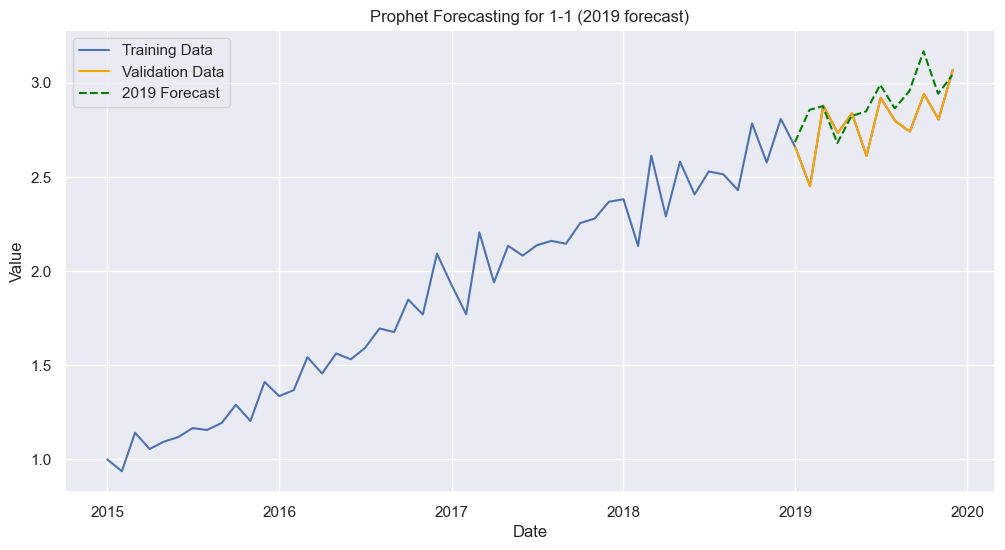

In [824]:
train_start = '2015-01-01'
train_end = '2018-12-31'
valid_start = '2019-01-01'
valid_end = '2019-12-31'

prophet_forecasts = []
prophet_smape_values = []

for division in division_for_test:
    division_data = df_train_p[df_train_p['division_name'] == division]

    prophet_data = division_data[['report_dt', 'val']].rename(columns={'report_dt': 'ds', 'val': 'y'})
    train_data = prophet_data[prophet_data['ds'] < valid_start]

    model = Prophet()
    model.fit(train_data)

    future = model.make_future_dataframe(periods=12, freq='M', include_history=False)
    forecast = model.predict(future)

    forecast_df = forecast[['ds', 'yhat']].rename(columns={'ds': 'report_dt', 'yhat': 'predicted_val'})
    forecast_df['division_name'] = division
    prophet_forecasts.append(forecast_df)

    actual_values = df_train_p[(df_train_p['division_name'] == division) & (df_train_p['report_dt'] >= valid_start) & (df_train_p['report_dt'] <= valid_end)]['val'].values

    forecasted_values = forecast_df['predicted_val'].values

    smape_value = smape(actual_values, forecasted_values)
    prophet_smape_values.append(smape_value)
    print(f'SMAPE for {division} (2019 forecast): {smape_value:.4f}')

prophet_forecast_df = pd.concat(prophet_forecasts)
prophet_forecast_df.set_index('report_dt', inplace=True)

prophet_average_smape = np.mean(prophet_smape_values)
print(f'Average SMAPE across all divisions (2019 forecast): {prophet_average_smape:.4f}')

example_division = division_for_test[0]
plt.figure(figsize=(12, 6))

df_train_plot = df_train[df_train['division_name'] == example_division].copy()
df_train_plot.index = df_train_plot.index.to_timestamp()
df_train_plot['report_dt'] = df_train_plot.index

plt.plot(df_train_plot.index, df_train_plot['val'], label='Training Data')

# Correct filtering 
df_valid_plot = df_train_plot[(df_train_plot['report_dt'] >= valid_start) & (df_train_plot['report_dt'] <= valid_end)]

plt.plot(df_valid_plot.index, df_valid_plot['val'], label='Validation Data', color='orange')

forecast_plot = prophet_forecast_df[prophet_forecast_df['division_name'] == example_division]
plt.plot(forecast_plot.index, forecast_plot['predicted_val'], label='2019 Forecast', linestyle='--', color='green')

plt.xlabel('Date')
plt.ylabel('Value')
plt.title(f'Prophet Forecasting for {example_division} (2019 forecast)')
plt.legend()
plt.show()

In [837]:
prophet_forecasts = []
prophet_smape_values = []

for division in division_for_test:
    division_data = df_train_p[df_train_p['division_name'] == division]

    prophet_data = division_data[['report_dt', 'val', 'rate']].rename(columns={'report_dt': 'ds', 'val': 'y'})

    train_data = prophet_data[prophet_data['ds'] < valid_start]

    model = Prophet(weekly_seasonality=False, daily_seasonality=False)
    model.add_regressor('rate')

    model.fit(train_data)
    future = model.make_future_dataframe(periods=12, freq='M', include_history=False)
    future_rate = division_data[(division_data['report_dt'] >= valid_start) & (division_data['report_dt'] <= valid_end)]['rate'].reset_index(drop=True)
    future['rate'] = future_rate
    forecast = model.predict(future)

    forecast_df = forecast[['ds', 'yhat']].rename(columns={'ds': 'report_dt', 'yhat': 'predicted_val'})
    forecast_df['division_name'] = division
    prophet_forecasts.append(forecast_df)

    actual_values = df_train_p[(df_train_p['division_name'] == division) & (df_train_p['report_dt'] >= valid_start) & (df_train_p['report_dt'] <= valid_end)]['val'].values
    forecasted_values = forecast_df['predicted_val'].values
    smape_value = smape(actual_values, forecasted_values)
    prophet_smape_values.append(smape_value)
    print(f'SMAPE for {division} (2019 forecast): {smape_value:.4f}')

# Concatenate all forecasts into a single DataFrame
prophet_forecast_df = pd.concat(prophet_forecasts)
prophet_forecast_df.set_index('report_dt', inplace=True)

# Calculate average SMAPE across all divisions
prophet_average_smape = np.mean(prophet_smape_values)
print(f'Average SMAPE across all divisions (2019 forecast): {prophet_average_smape:.4f}')

18:02:53 - cmdstanpy - INFO - Chain [1] start processing
18:02:53 - cmdstanpy - INFO - Chain [1] done processing
18:02:53 - cmdstanpy - INFO - Chain [1] start processing


SMAPE for 1-1 (2019 forecast): 4.6606


18:02:53 - cmdstanpy - INFO - Chain [1] done processing
18:02:53 - cmdstanpy - INFO - Chain [1] start processing


SMAPE for 1-2 (2019 forecast): 4.1798


18:02:54 - cmdstanpy - INFO - Chain [1] done processing
18:02:54 - cmdstanpy - INFO - Chain [1] start processing


SMAPE for 1-3 (2019 forecast): 3.7897


18:02:54 - cmdstanpy - INFO - Chain [1] done processing
18:02:54 - cmdstanpy - INFO - Chain [1] start processing


SMAPE for 1-4 (2019 forecast): 5.3220


18:02:54 - cmdstanpy - INFO - Chain [1] done processing
18:02:54 - cmdstanpy - INFO - Chain [1] start processing


SMAPE for 1-5 (2019 forecast): 4.9453


18:02:54 - cmdstanpy - INFO - Chain [1] done processing
18:02:55 - cmdstanpy - INFO - Chain [1] start processing


SMAPE for 1-6 (2019 forecast): 3.7251


18:02:55 - cmdstanpy - INFO - Chain [1] done processing
18:02:55 - cmdstanpy - INFO - Chain [1] start processing


SMAPE for 10-1 (2019 forecast): 4.9647


18:02:55 - cmdstanpy - INFO - Chain [1] done processing
18:02:55 - cmdstanpy - INFO - Chain [1] start processing


SMAPE for 10-2 (2019 forecast): 5.9789


18:02:55 - cmdstanpy - INFO - Chain [1] done processing
18:02:55 - cmdstanpy - INFO - Chain [1] start processing


SMAPE for 10-3 (2019 forecast): 4.1884


18:02:56 - cmdstanpy - INFO - Chain [1] done processing


SMAPE for 10-4 (2019 forecast): 5.0454
Average SMAPE across all divisions (2019 forecast): 4.6800


### Из рассмотренных моделей лучший результат показала модель SARIMAX из SKtime
### c подобранными гиперпараметрами и с внешней переменной rate (ставка ЦБРФ на конец месяца) c результатом smape = 0.0206 или 2,06%


Теперь сделаем обучим модель на всех имеющихся данных и сделаем прогноз на 2020 год. Но для начала преобразуем данные для дивизиона 5-15.

In [21]:
df_train[(df_train['division_name'] == '5-15') & (df_train.index <= '2017-03')]['val'] = df_train[(df_train['division_name'] == '5-15') & (df_train.index > '2017-03')]['val'][:27]

In [23]:
mask_update = (df_train['division_name'] == '5-15') & (df_train.index <= '2017-03')
mask_source = (df_train['division_name'] == '5-15') & (df_train.index > '2017-03')
source_values = df_train.loc[mask_source, 'val'][:27].values
df_train.loc[mask_update, 'val'] = source_values

In [25]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 5400 entries, 2015-01 to 2019-12
Freq: M
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   division_name  5400 non-null   object 
 1   val            5400 non-null   float64
 2   rate           5400 non-null   float64
dtypes: float64(2), object(1)
memory usage: 168.8+ KB


In [26]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 1080 entries, 2020-01 to 2020-12
Freq: M
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   division_name  1080 non-null   object 
 1   val            0 non-null      float64
 2   rate           1080 non-null   float64
dtypes: float64(2), object(1)
memory usage: 33.8+ KB


In [ ]:
best_params = {
    'order': (0, 1, 4),
    'seasonal_order': (0, 1, 2, 6)
}

forecasts = []
smape_values = []

for division in df_train['division_name'].unique():

    X_train = df_train[df_train['division_name'] == division]
    X_test = df_test[df_train['division_name'] == division]
    
    forecaster = TransformedTargetForecaster([
        ("deseasonalise", Deseasonalizer(model="multiplicative", sp=12)),
        ("forecast", sktime_sarimax(order=best_params['order'], seasonal_order=best_params['seasonal_order']))
    ])
    
    forecaster.fit(y=X_train['val'], X=X_train[['rate']])
    
    forecast = forecaster.predict(fh=np.arange(1, 13), X=X_test[['rate']])
    
    forecast_df = pd.DataFrame({
        'report_dt': forecast.index,
        'division_name': division,
        'predicted_val': forecast.values
    })
    forecasts.append(forecast_df)   

forecast_df = pd.concat(forecasts)
forecast_df.set_index('report_dt', inplace=True)

example_division = division_for_test[0]
plt.figure(figsize=(12, 6))

df_train_plot = df_train[df_train['division_name'] == example_division].copy()
df_train_plot.index = df_train_plot.index.to_timestamp()
plt.plot(df_train_plot.index, df_train_plot['val'], label='Actual Data')

forecast_plot = forecast_df[forecast_df['division_name'] == example_division]
plt.plot(forecast_plot.index, forecast_plot['predicted_val'], label='Forecast')

plt.xlabel('Date')
plt.ylabel('Value')
plt.title(f'SARIMAX Forecasting for {example_division}')
plt.legend()
plt.show()

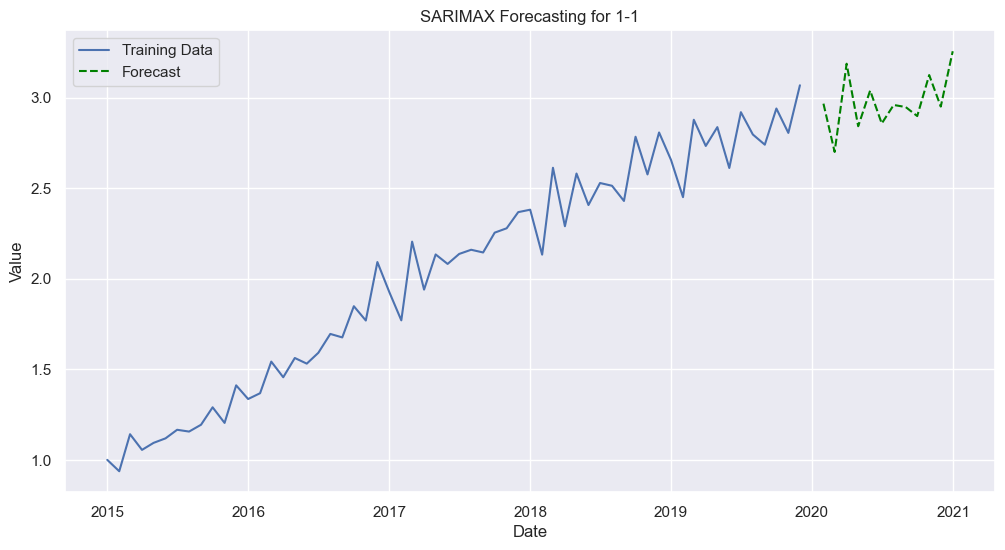

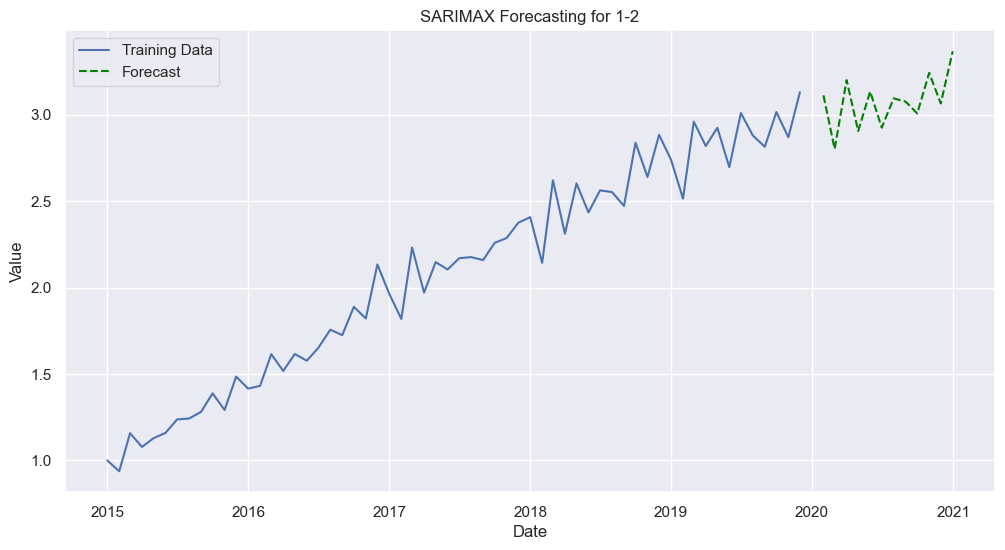

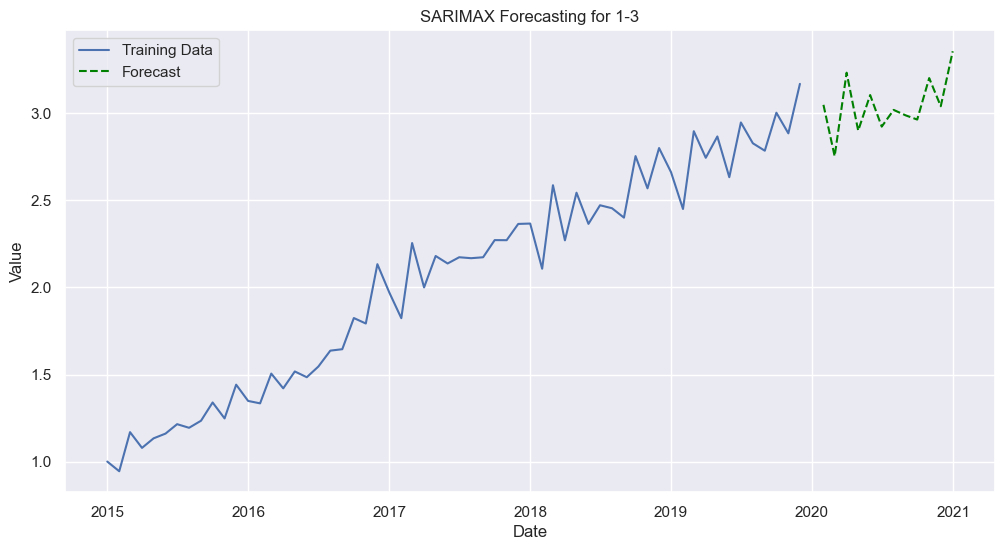

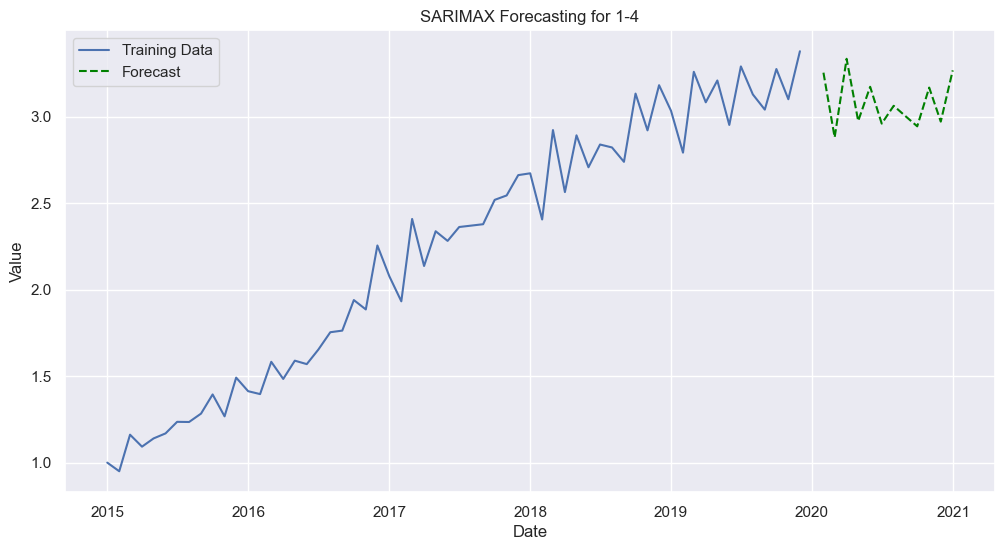

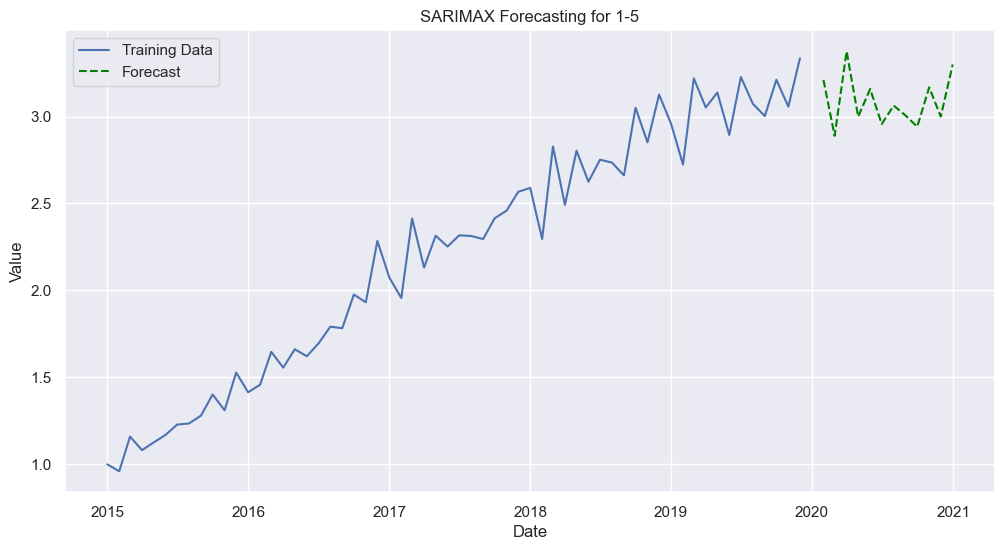

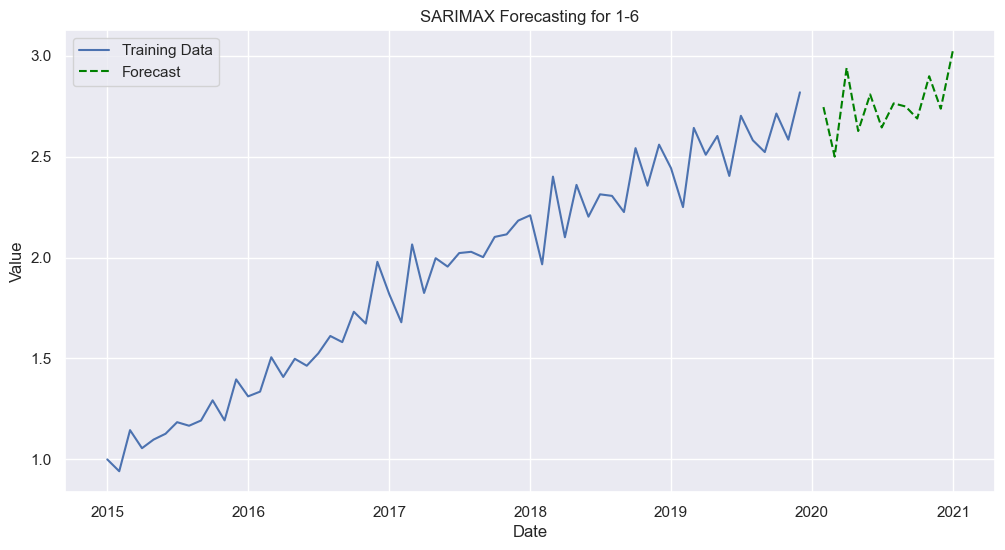

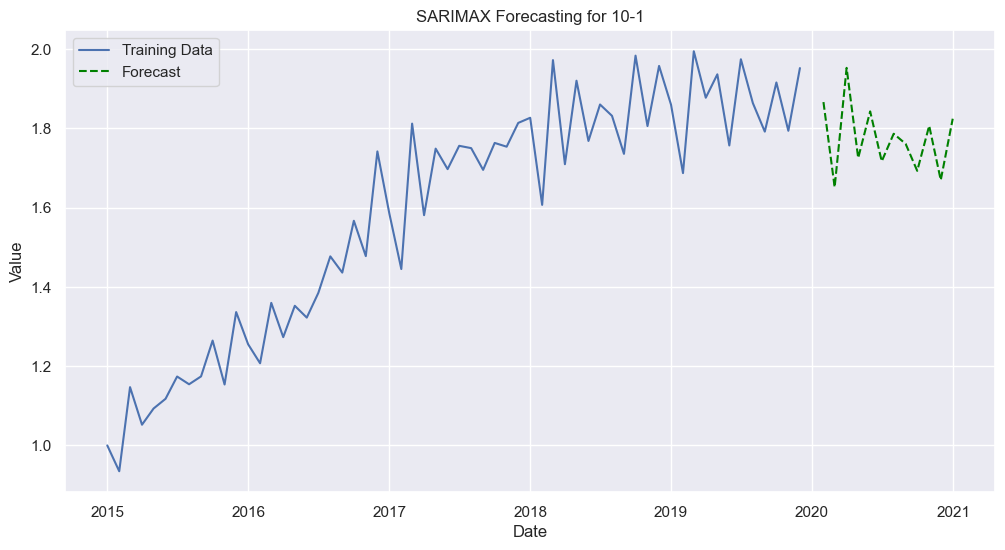

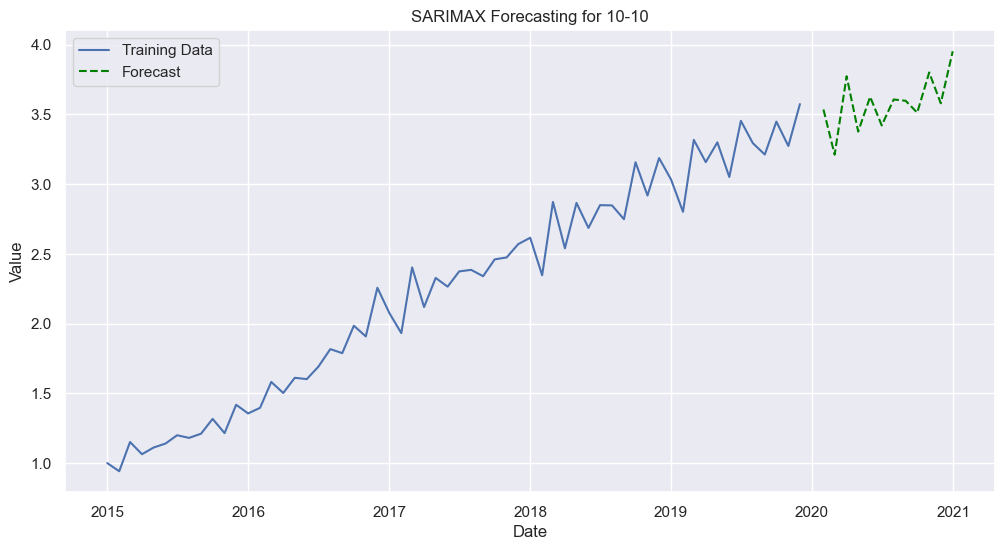

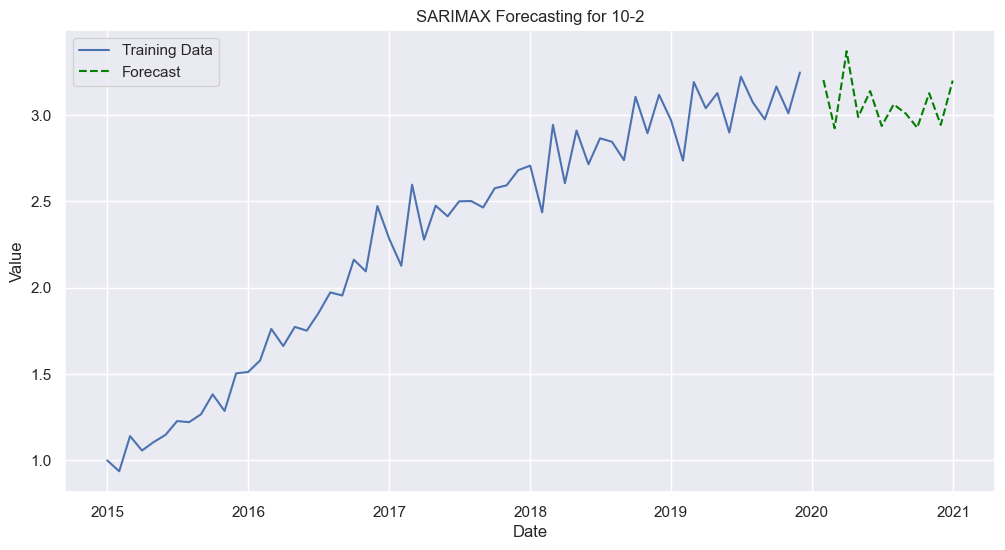

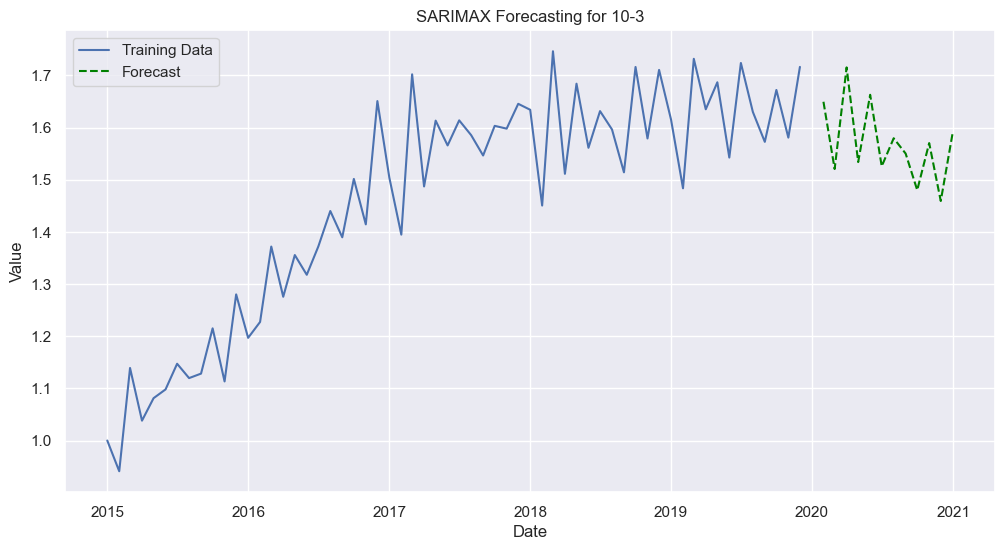

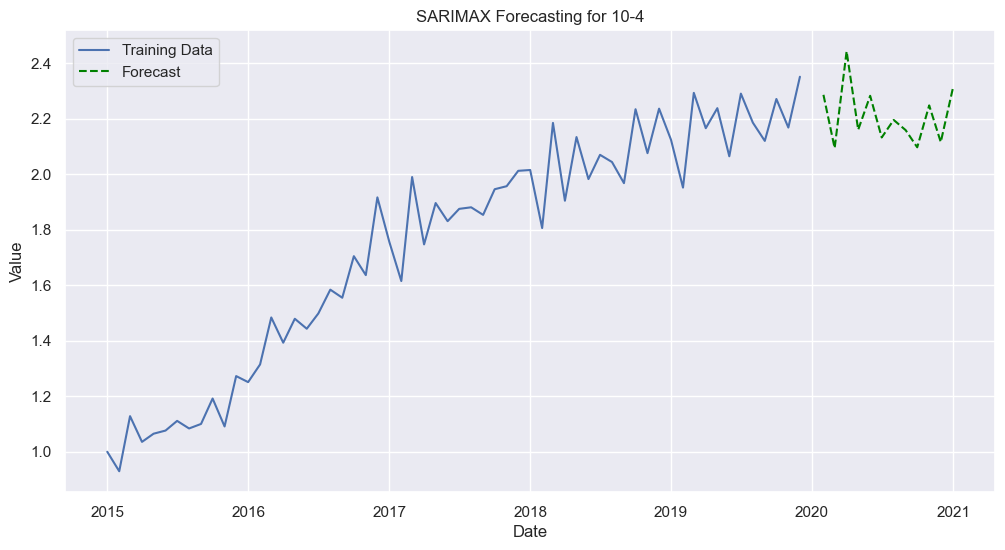

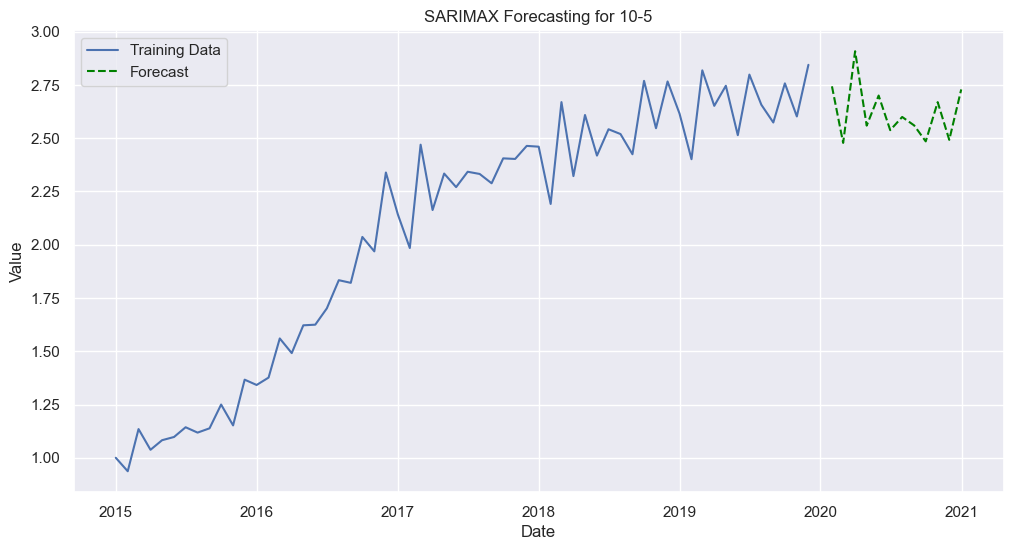

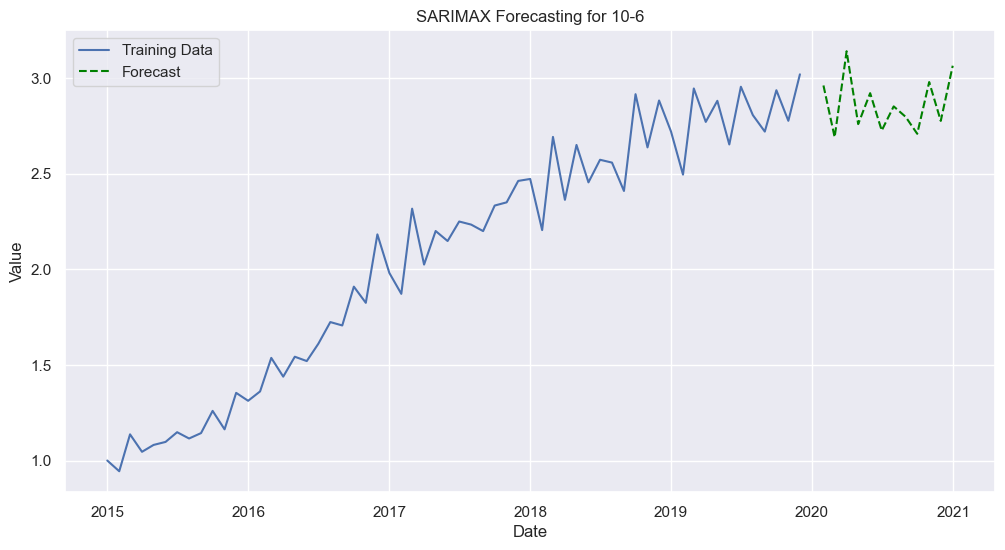

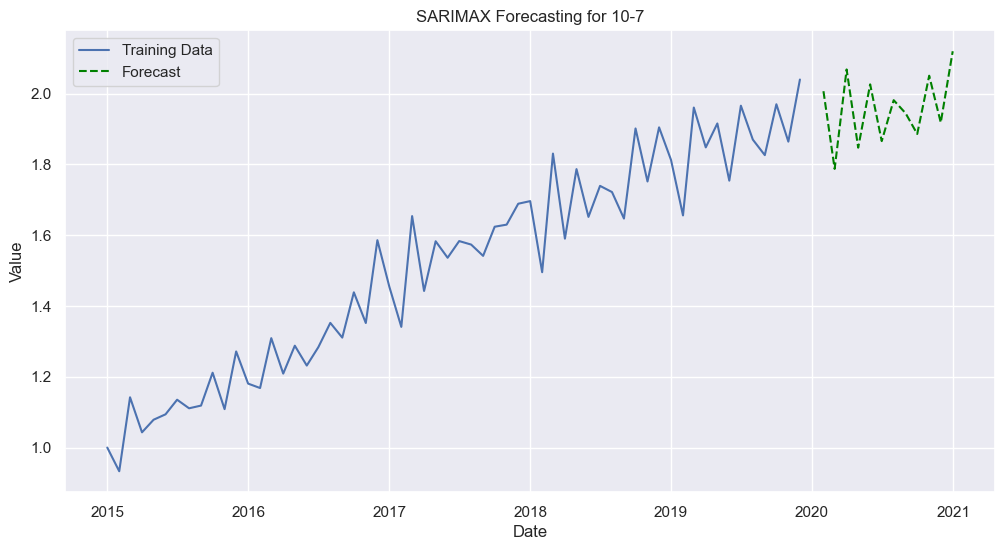

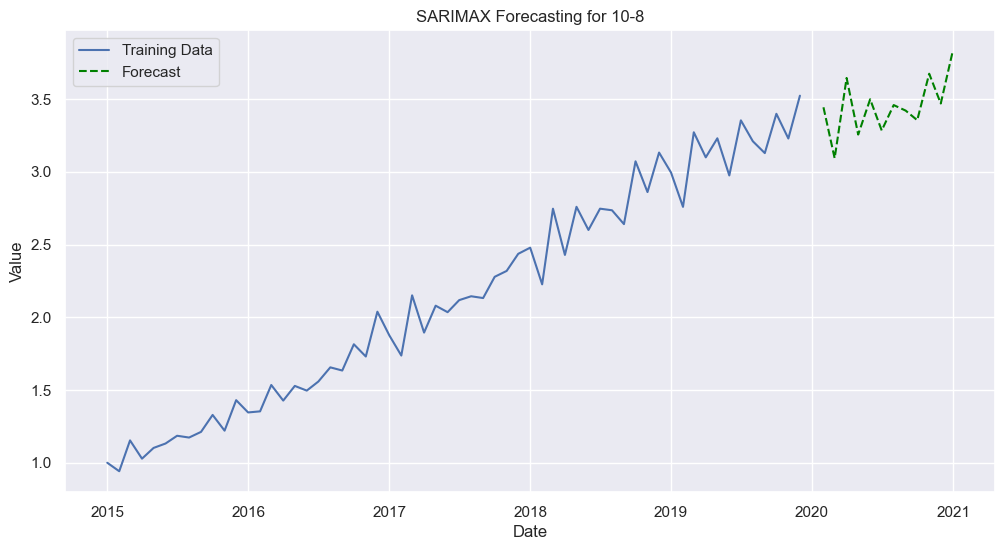

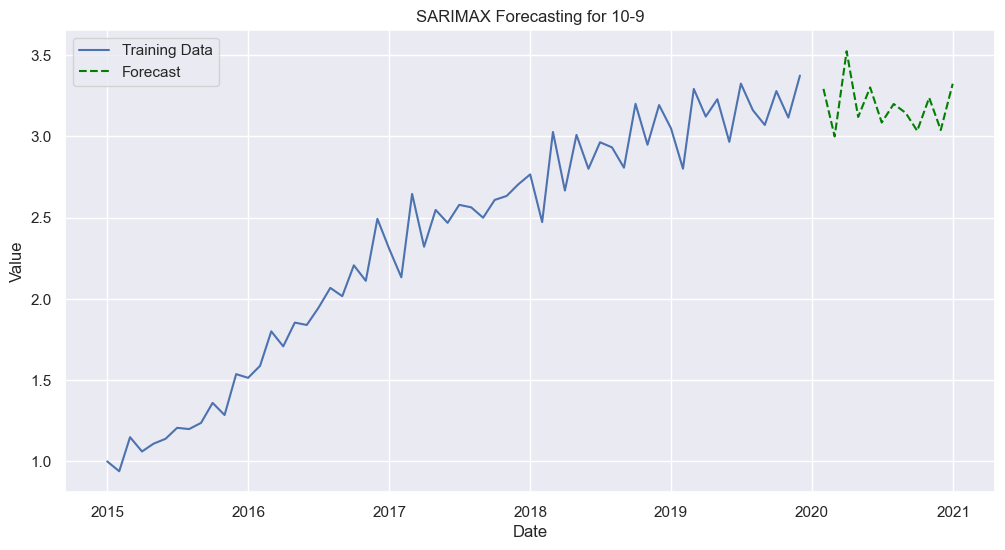

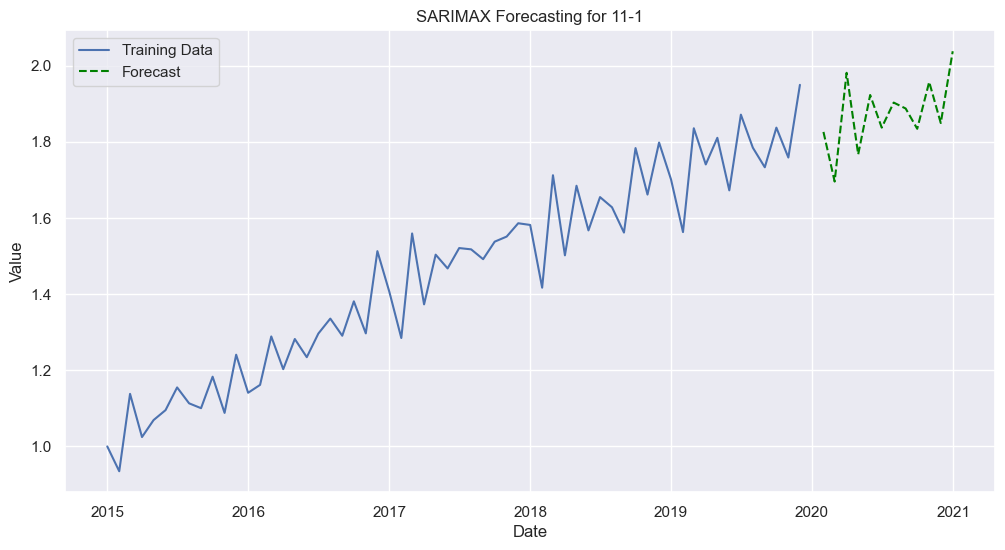

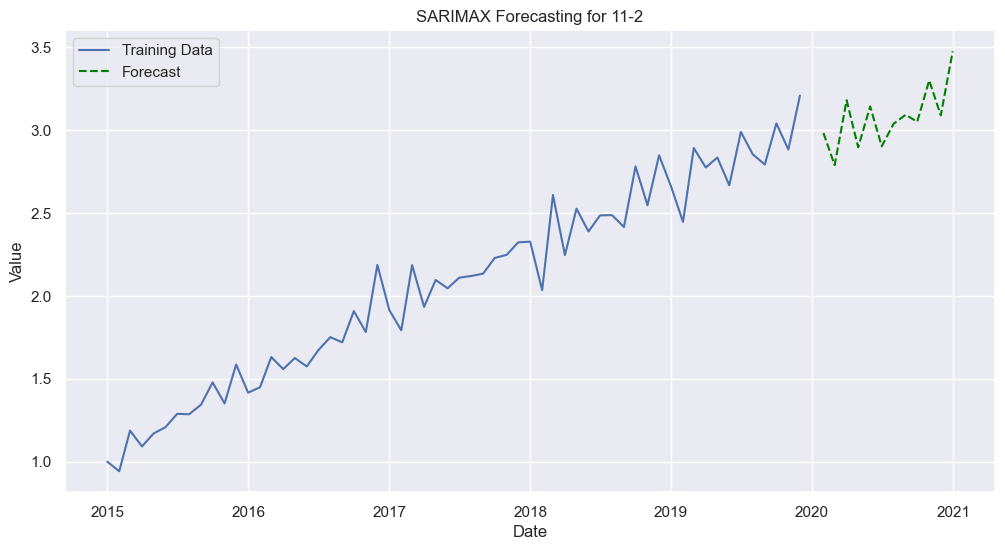

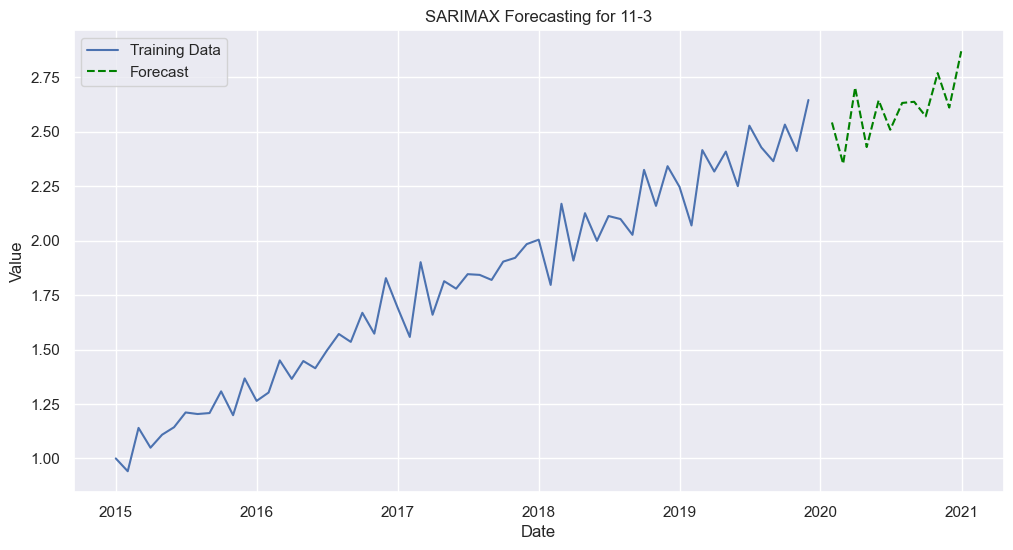

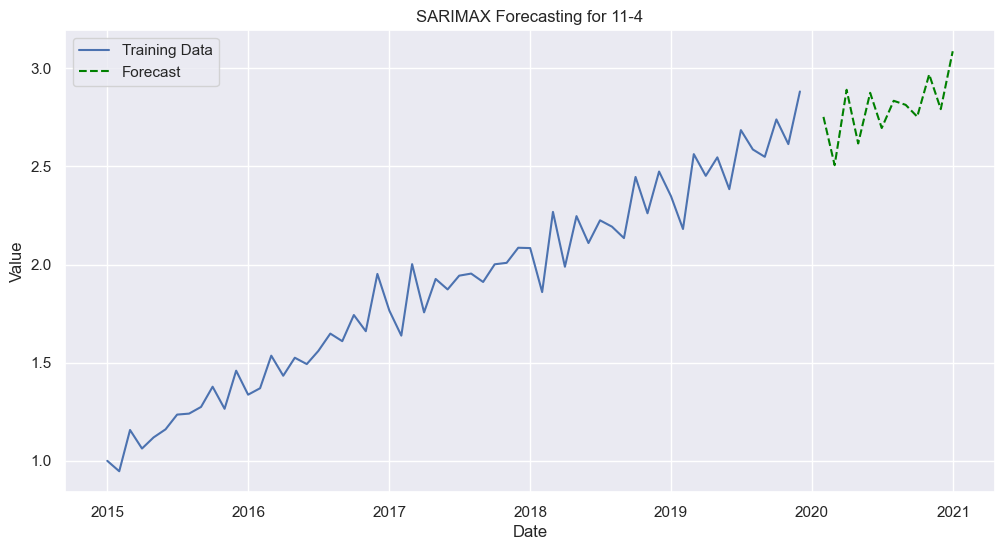

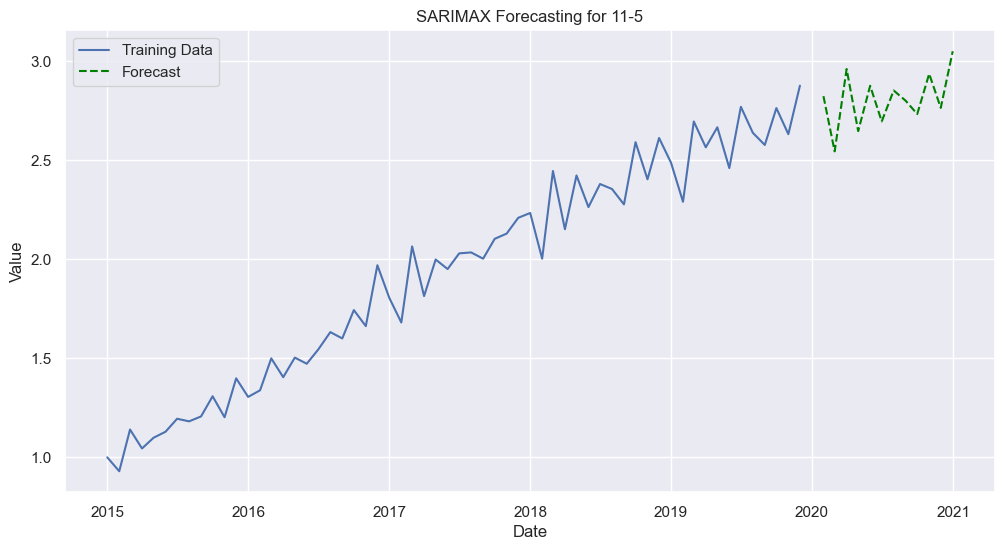

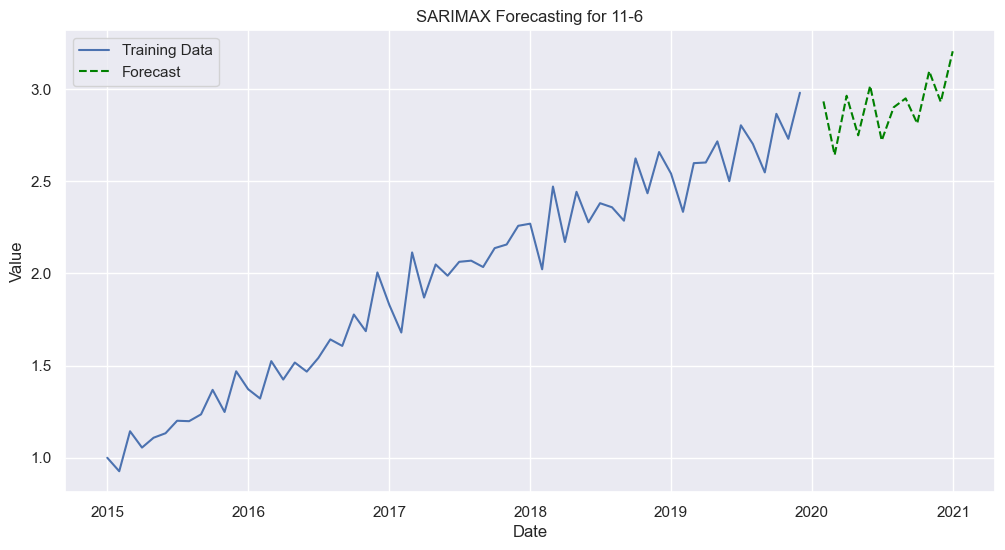

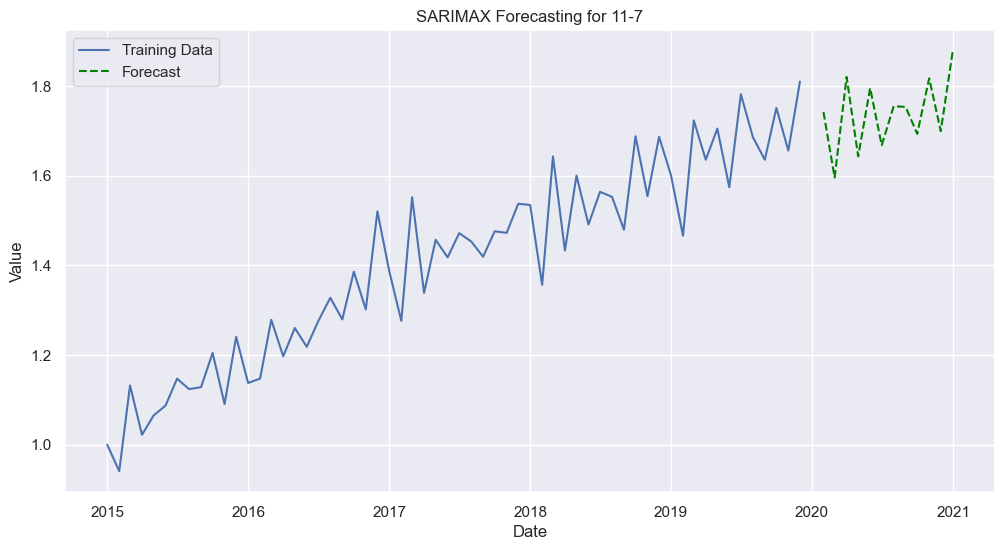

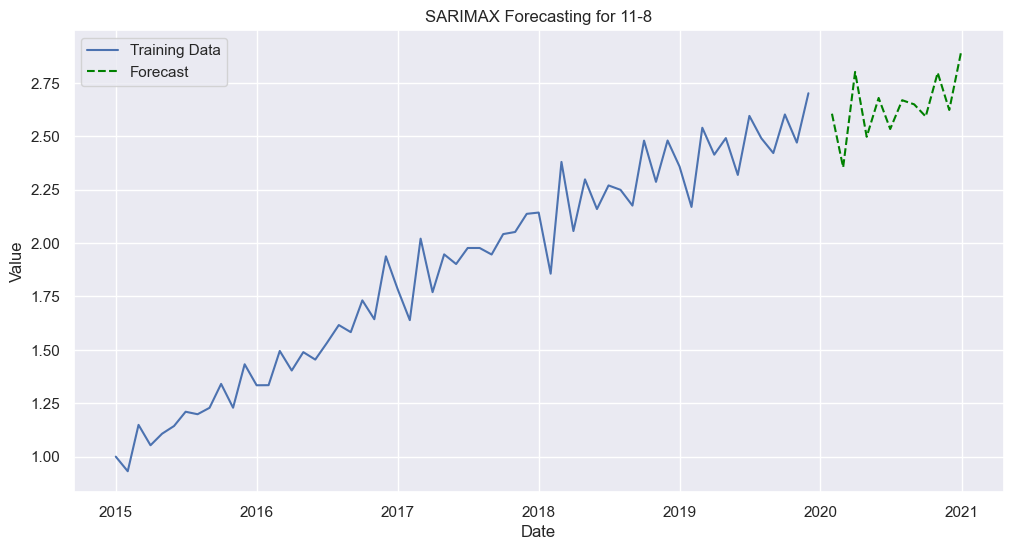

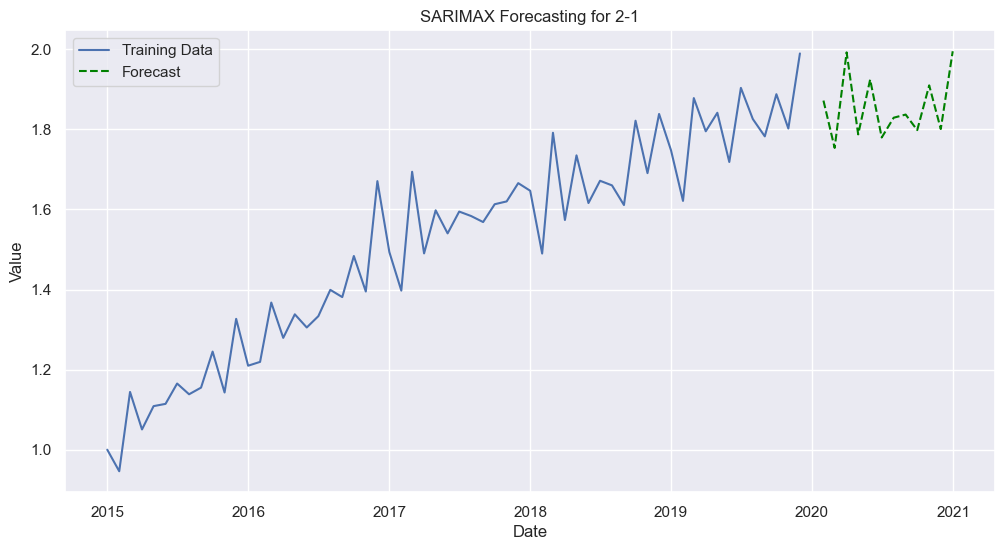

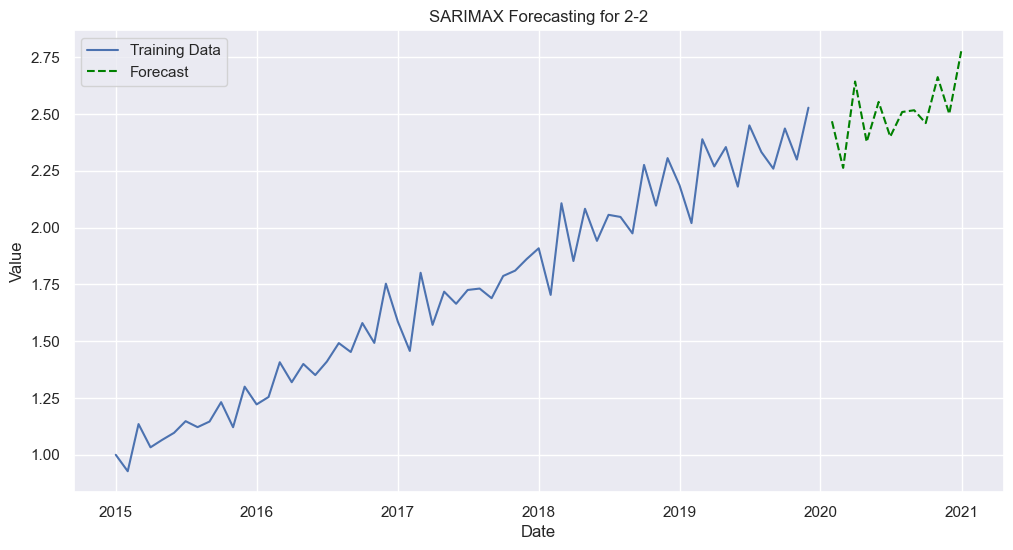

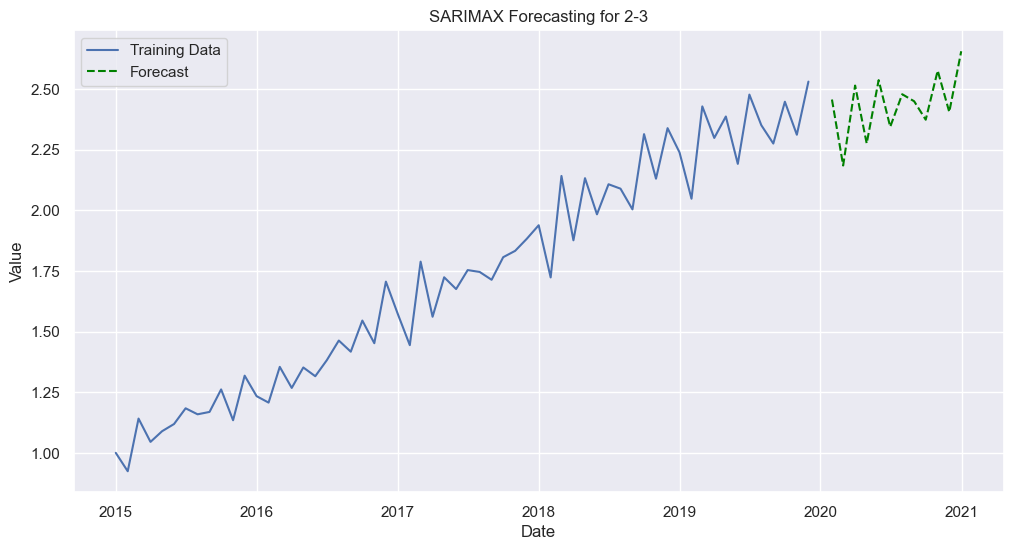

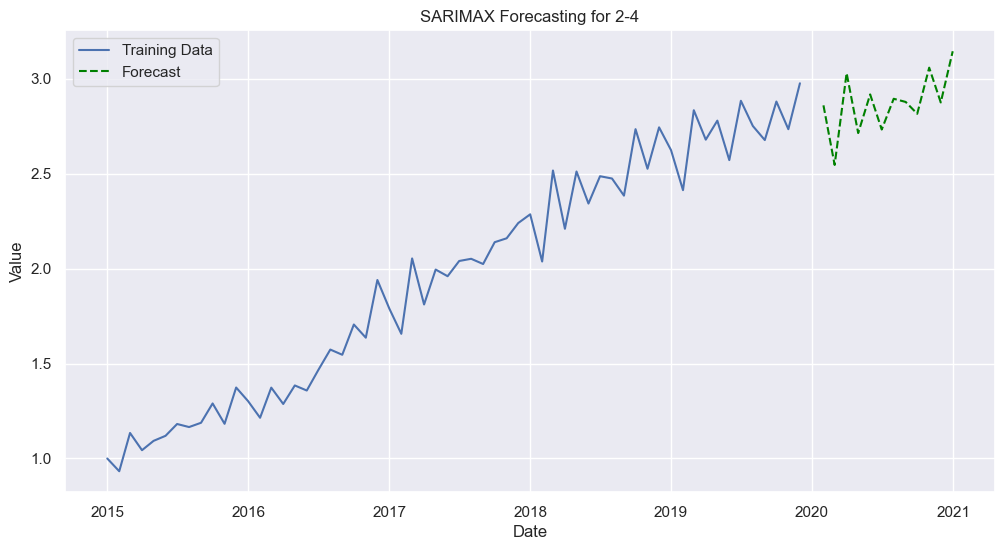

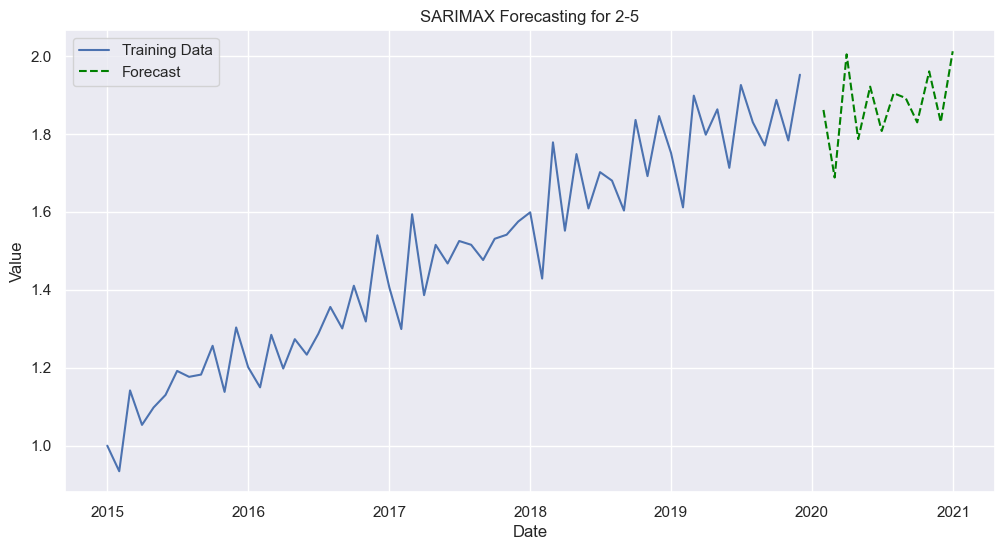

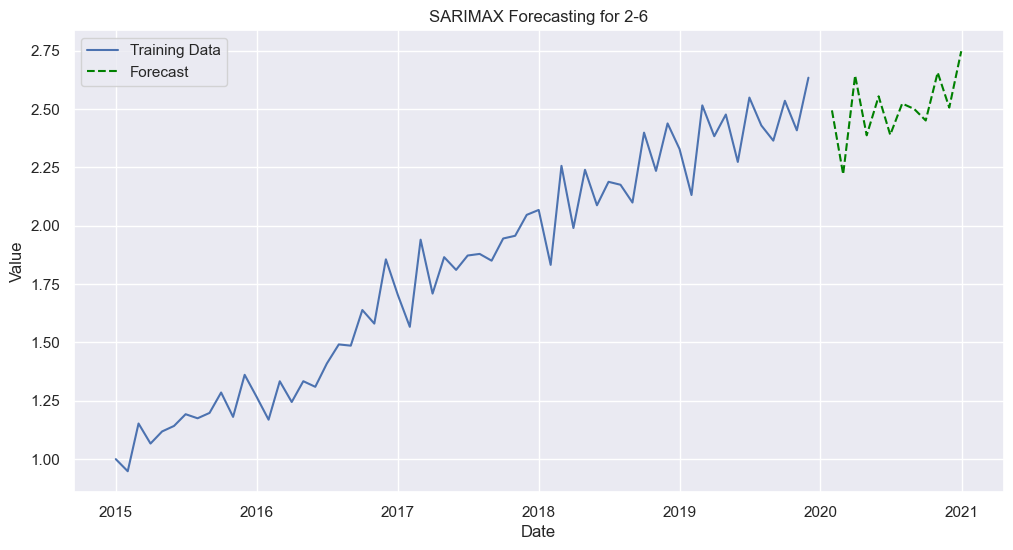

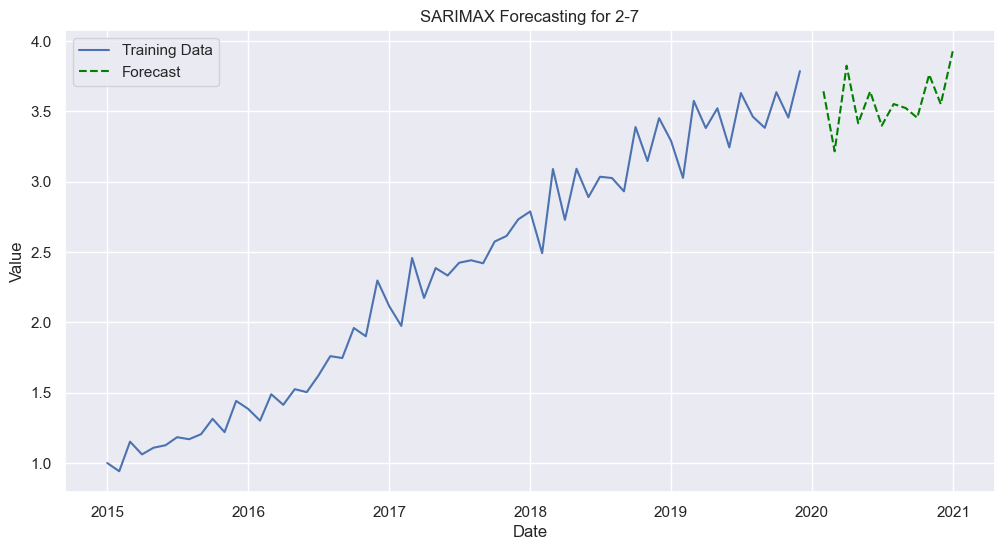

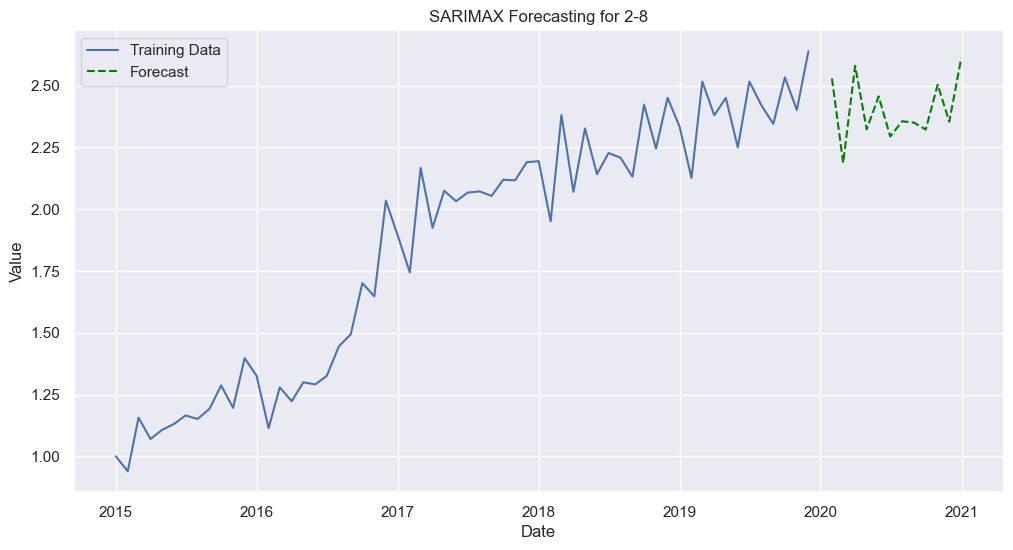

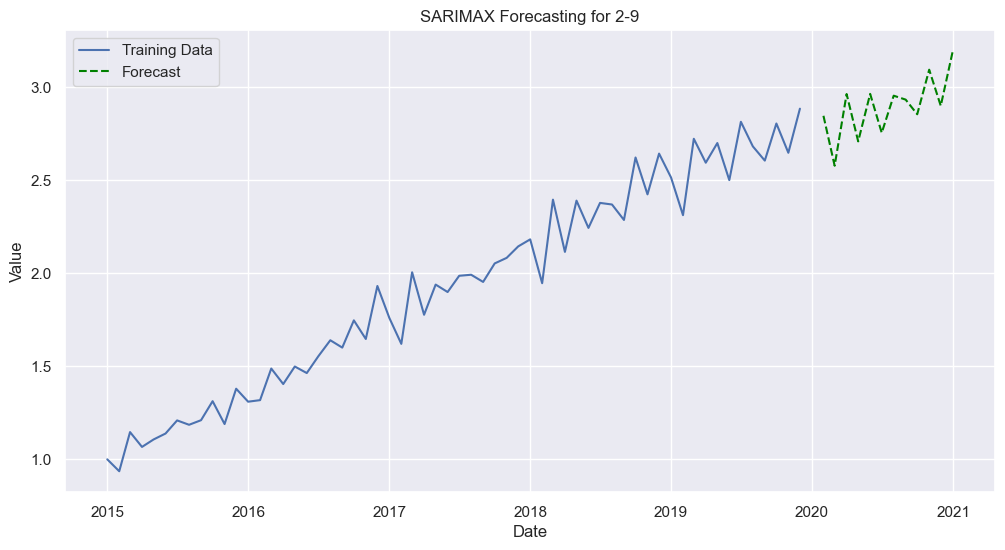

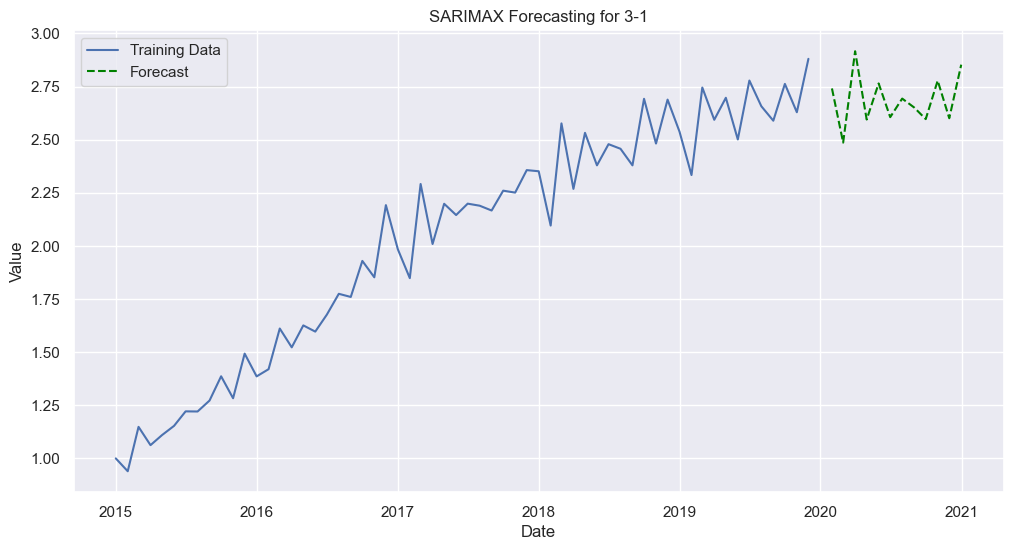

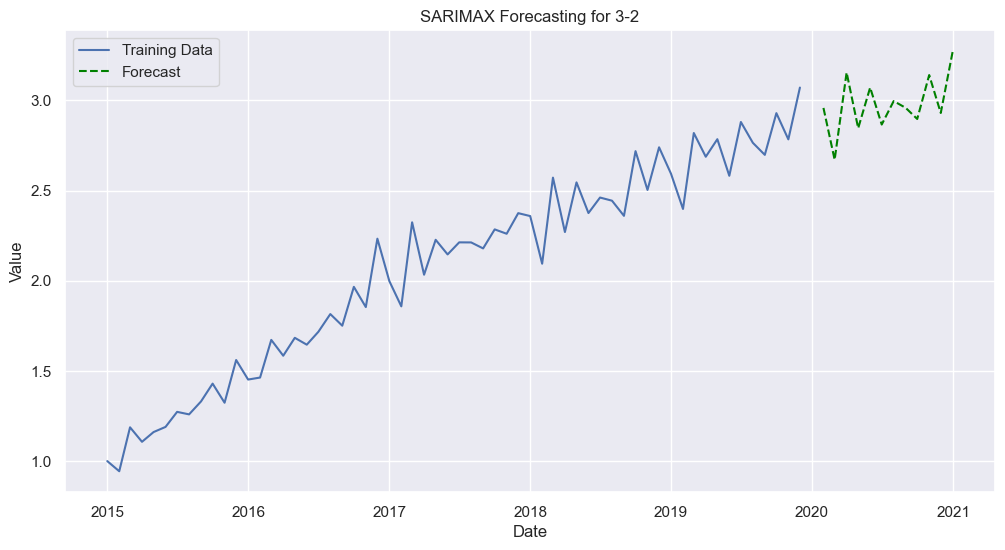

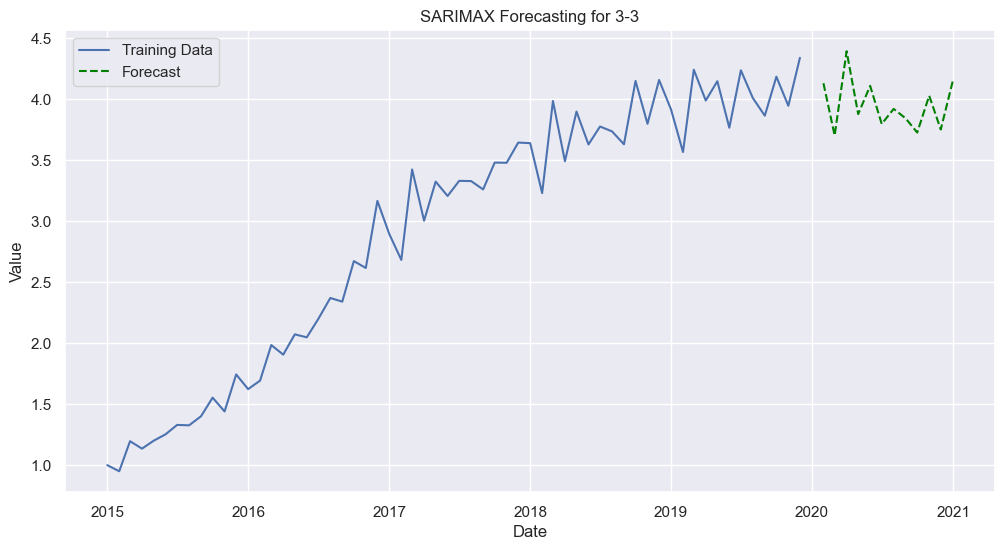

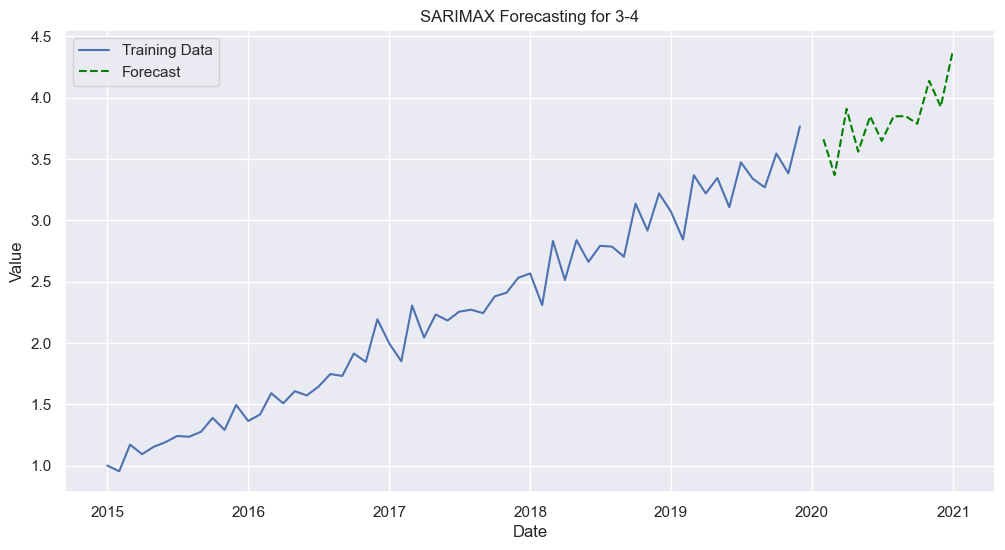

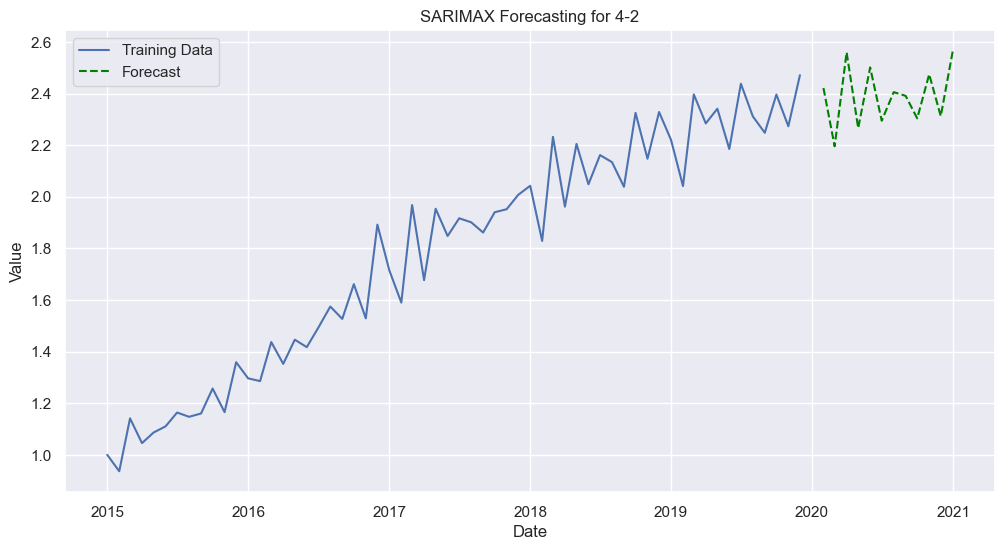

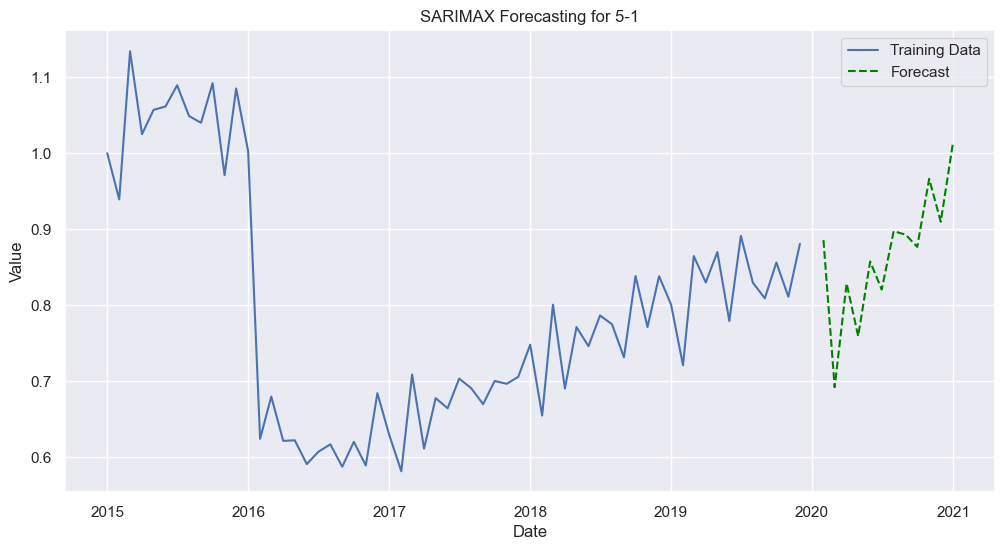

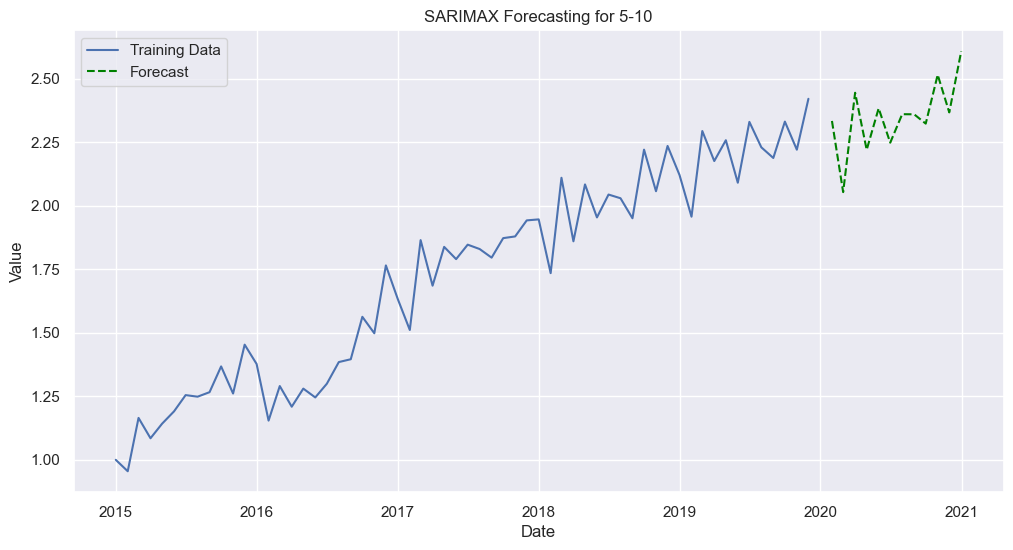

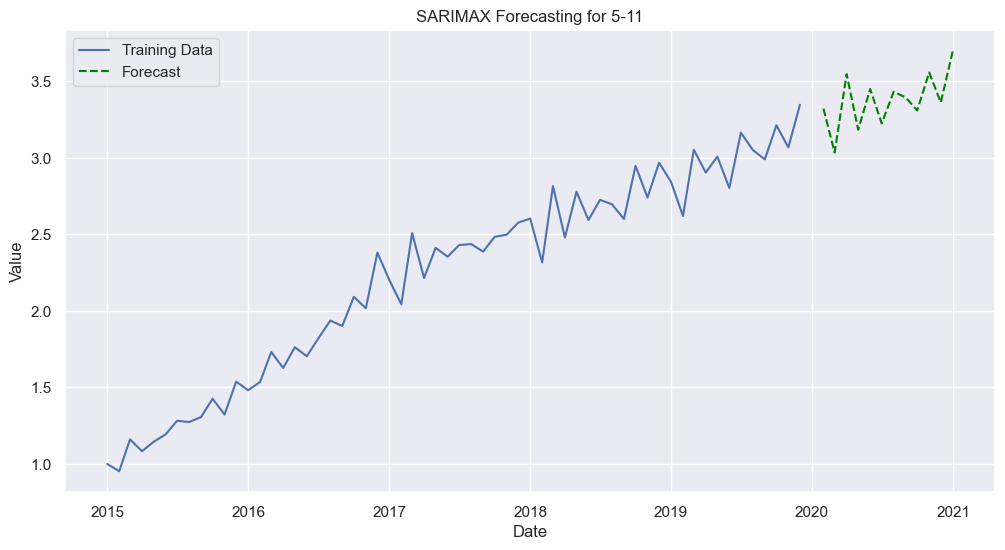

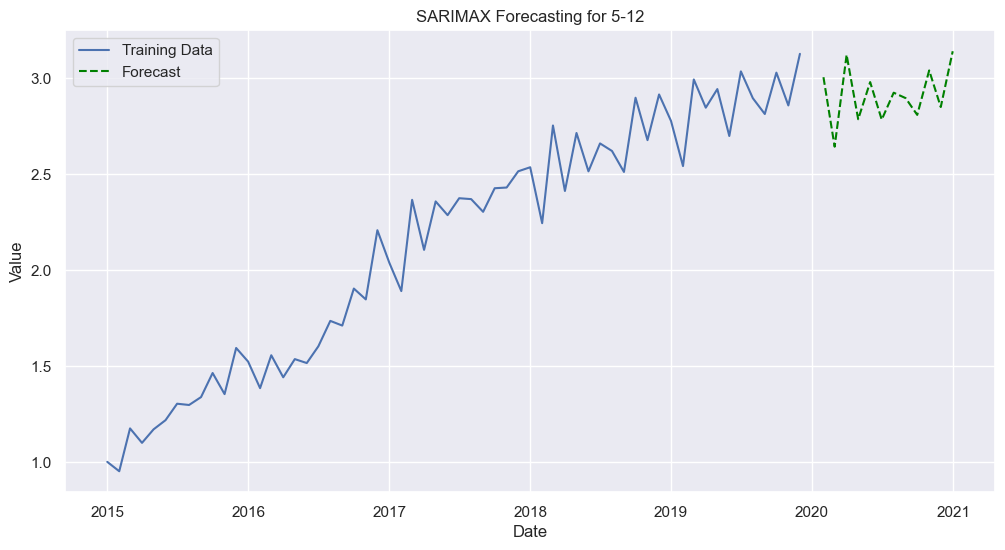

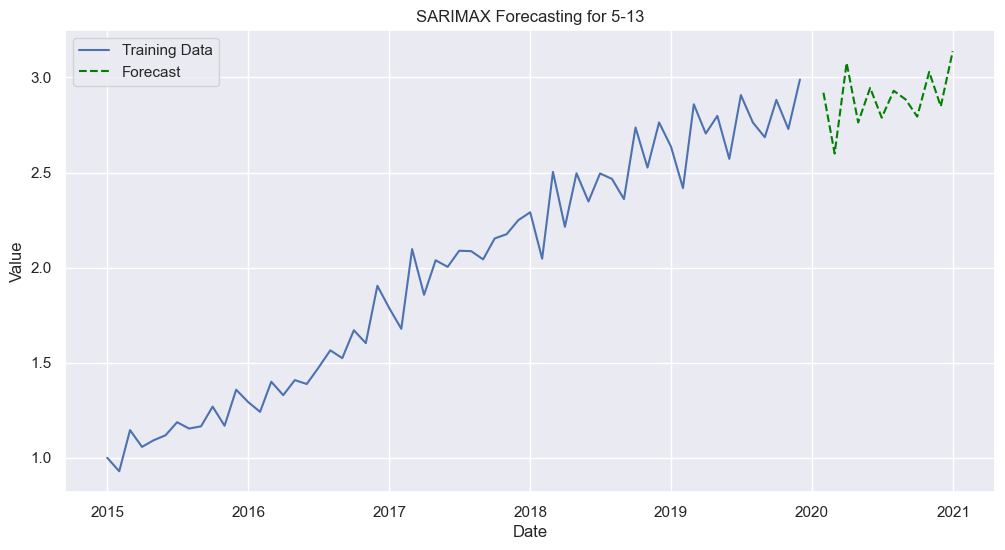

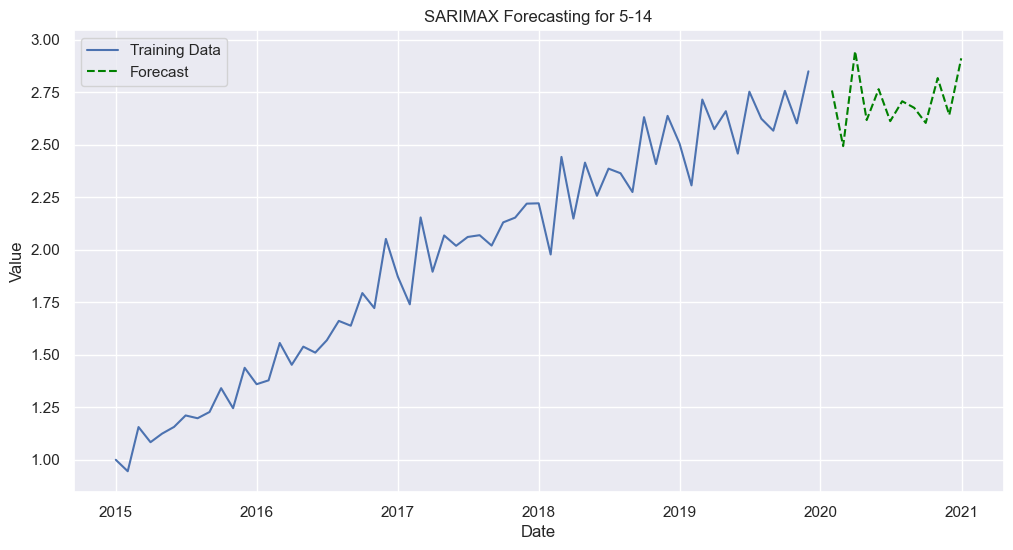

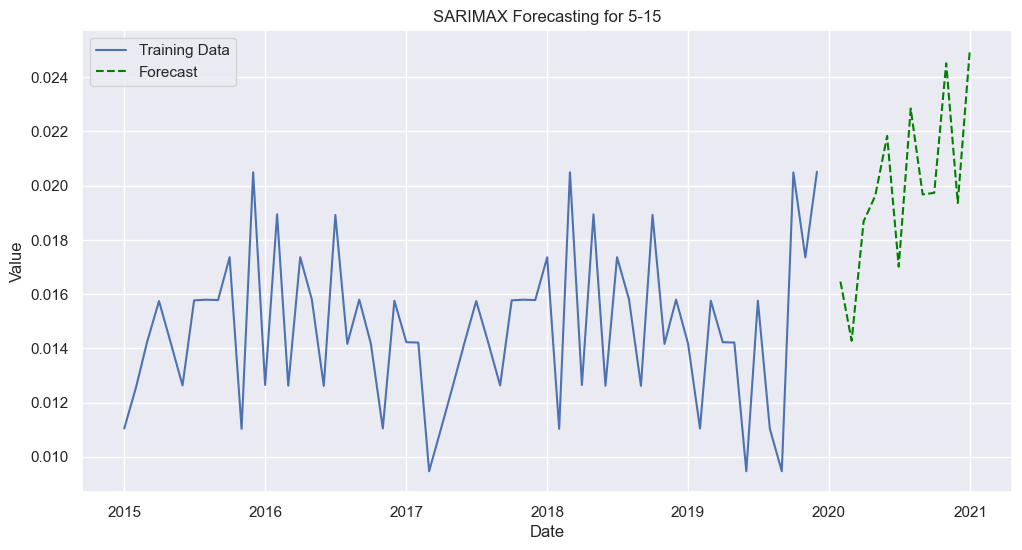

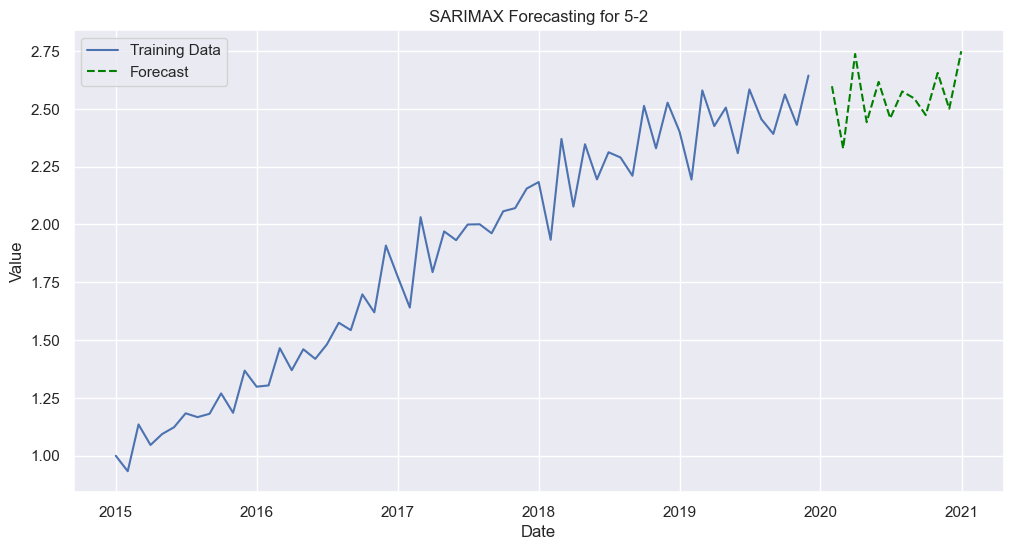

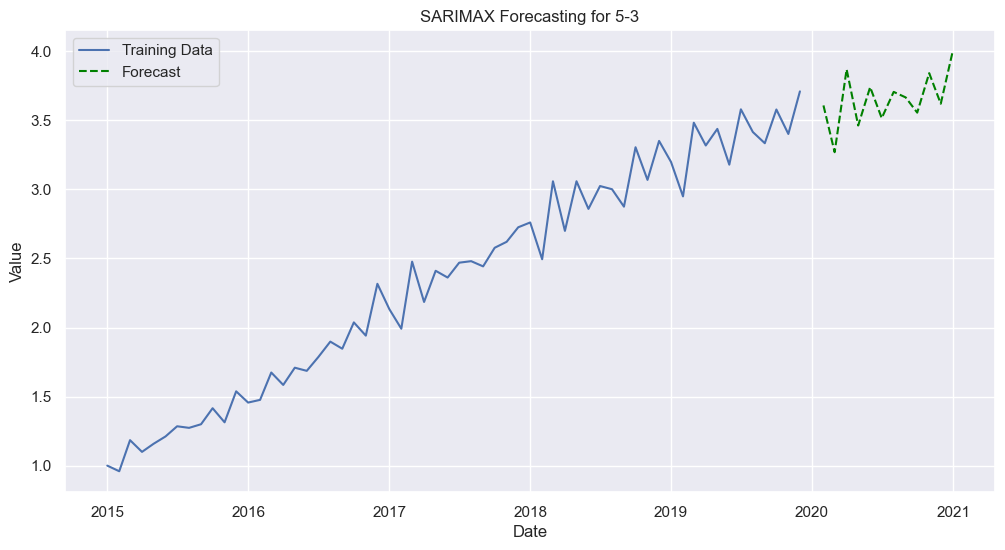

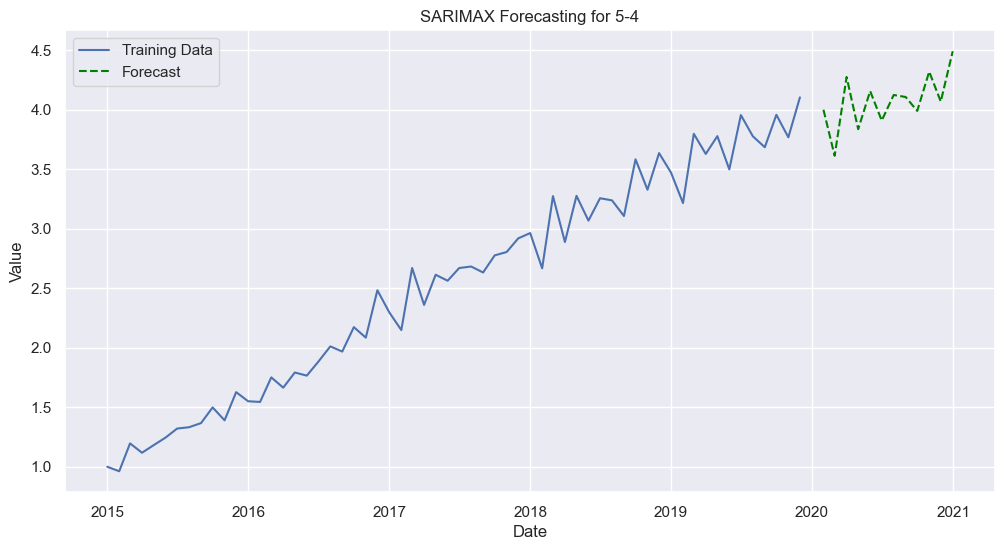

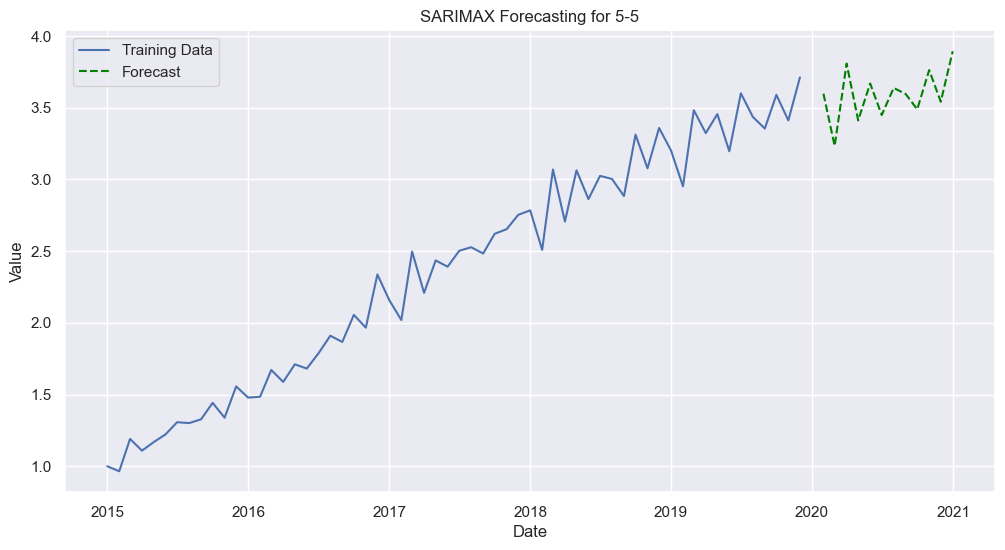

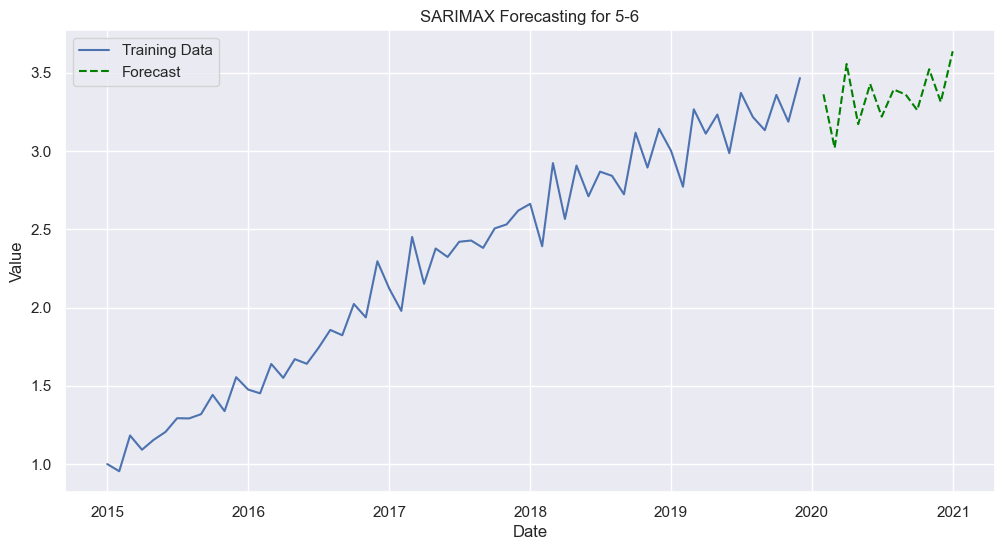

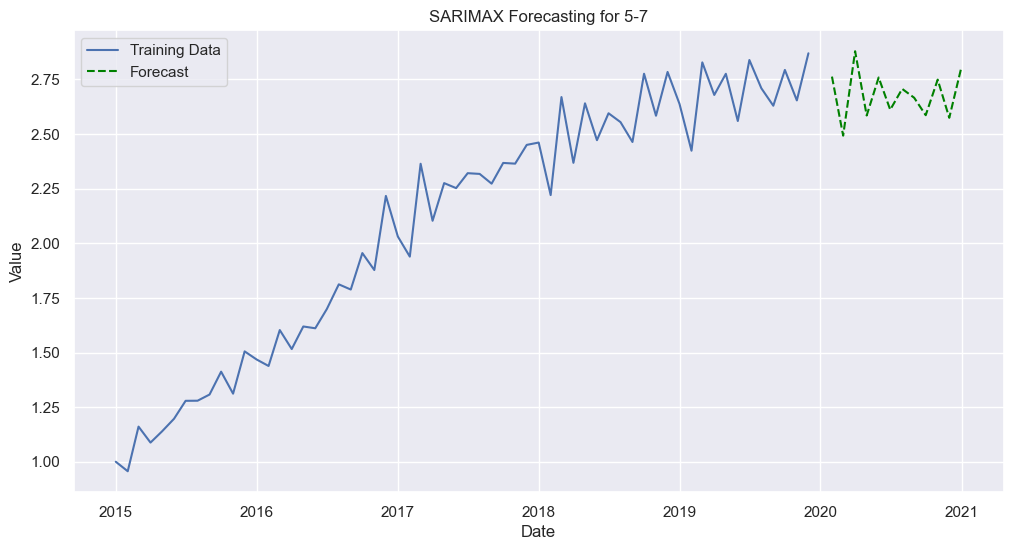

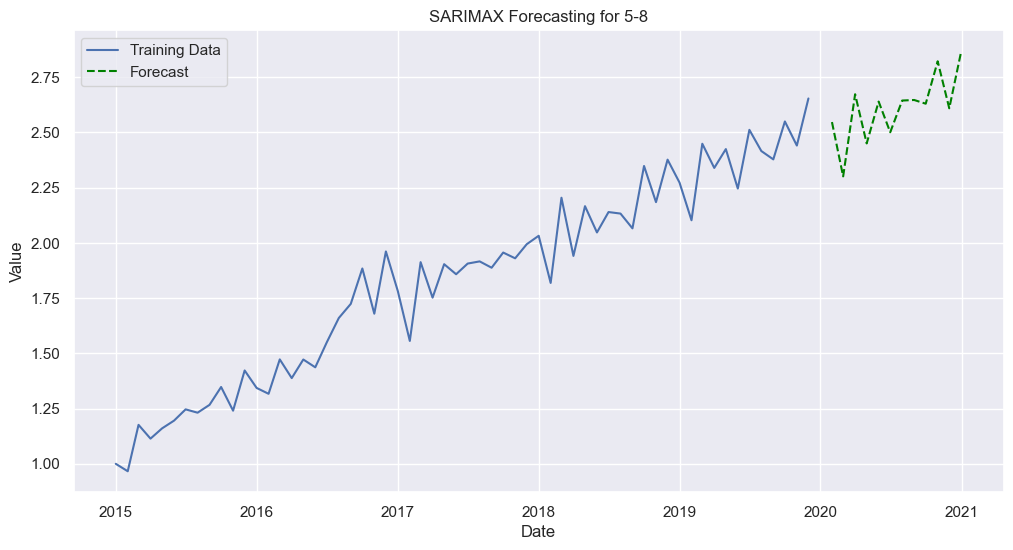

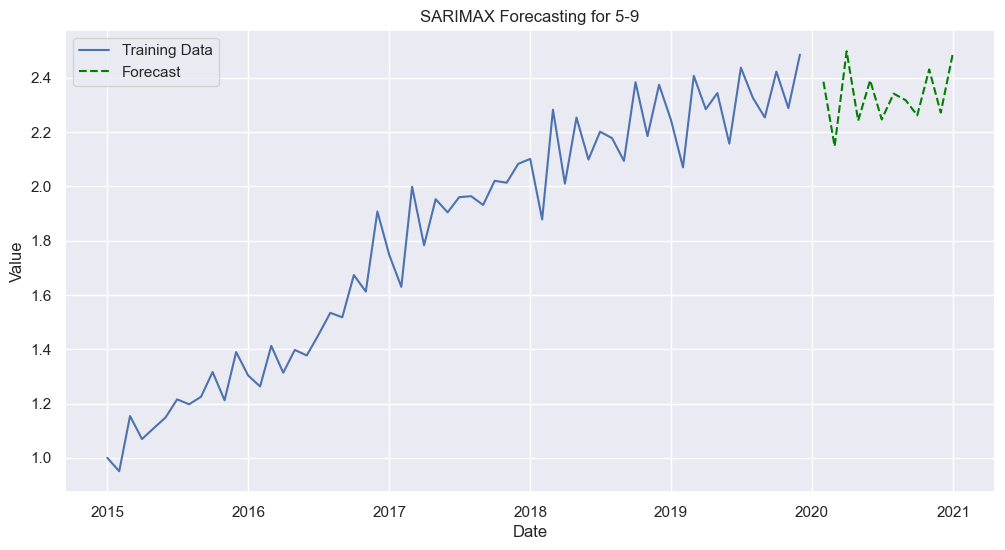

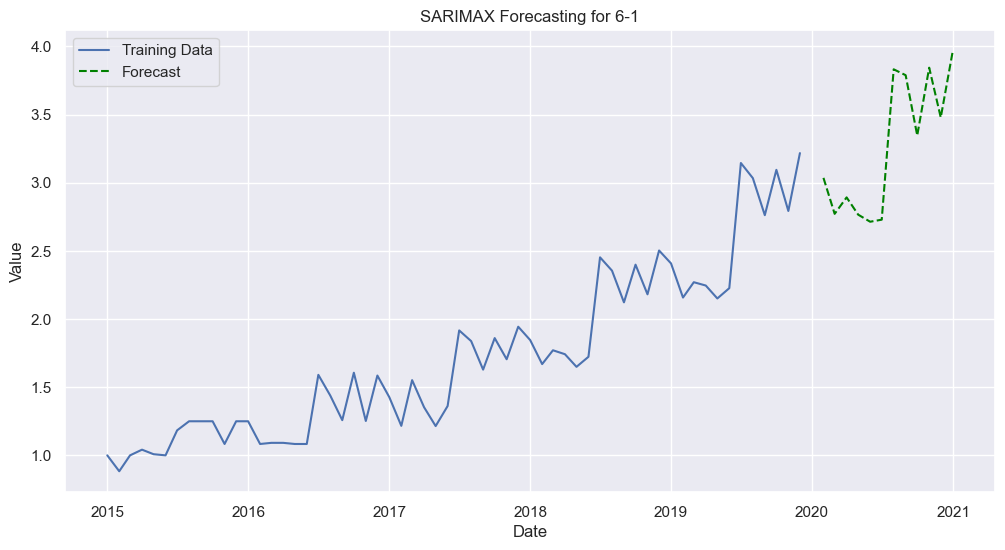

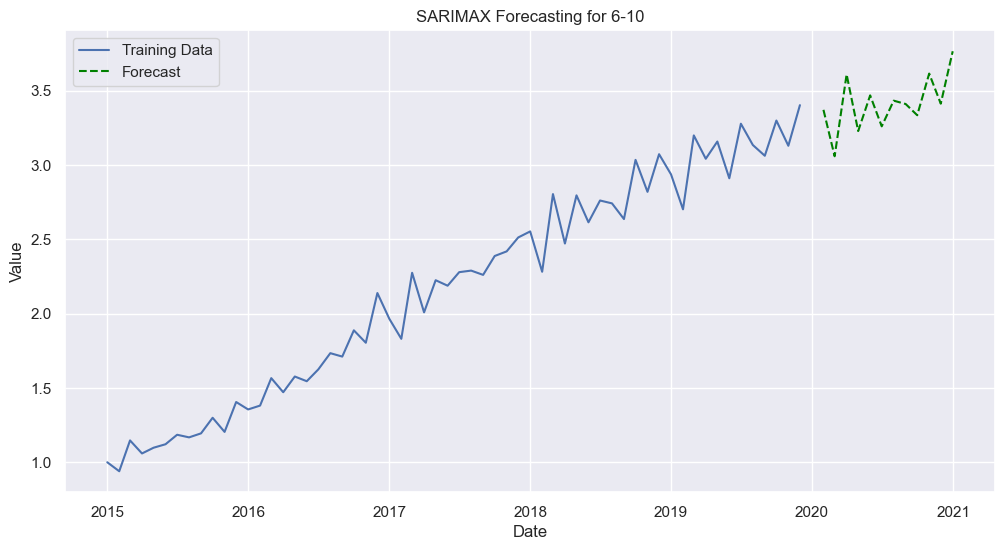

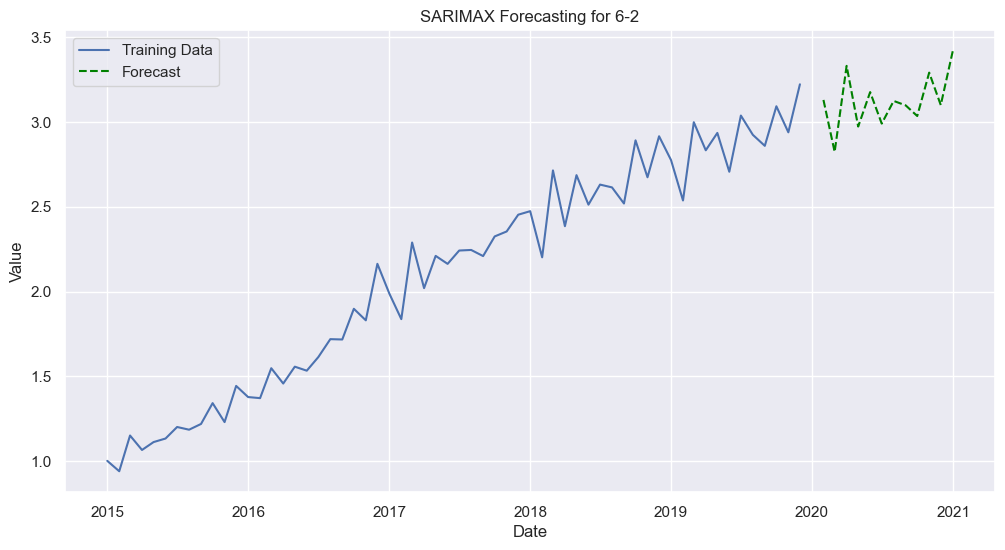

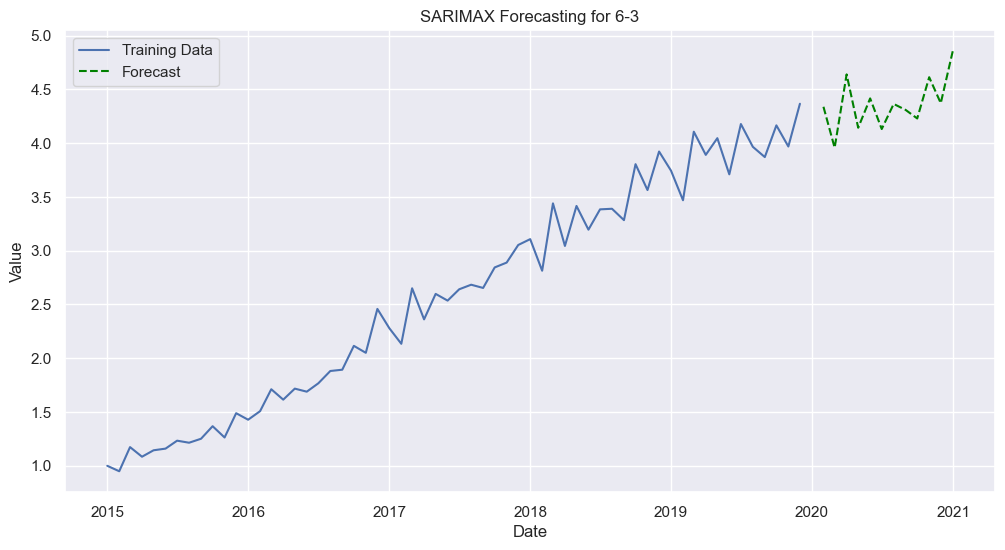

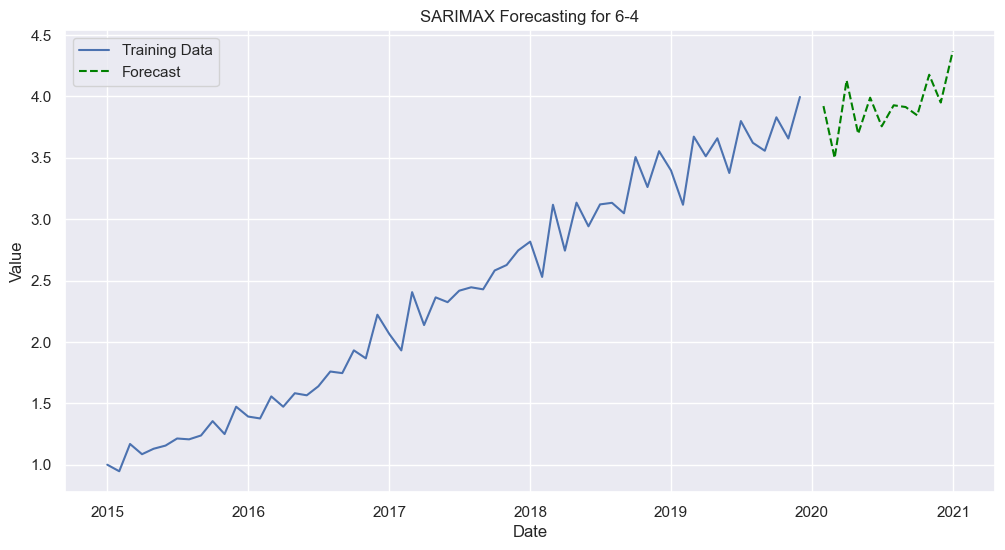

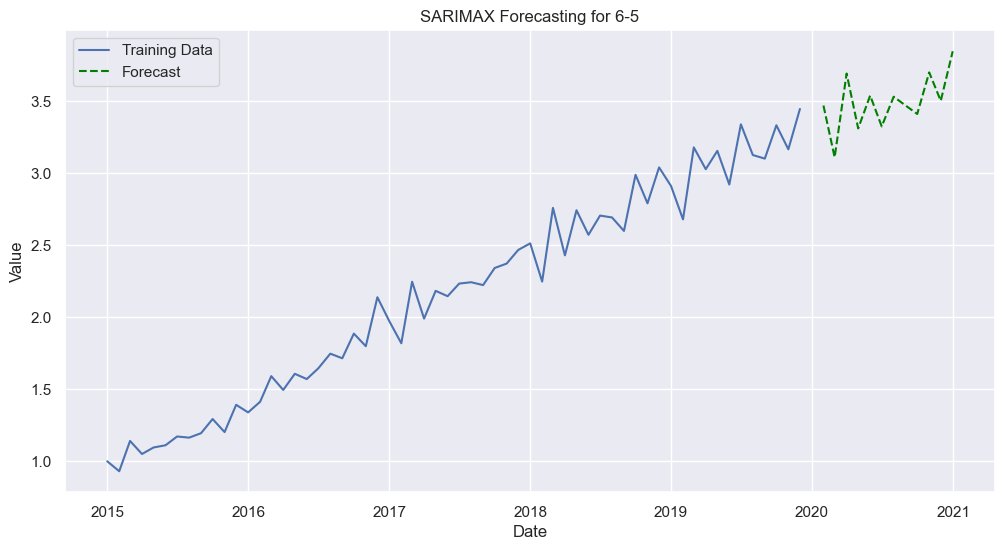

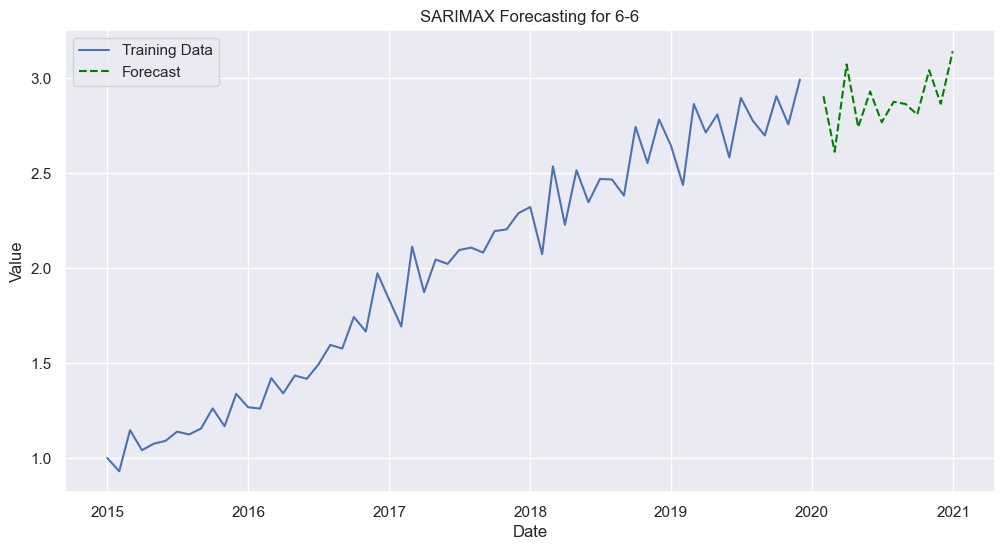

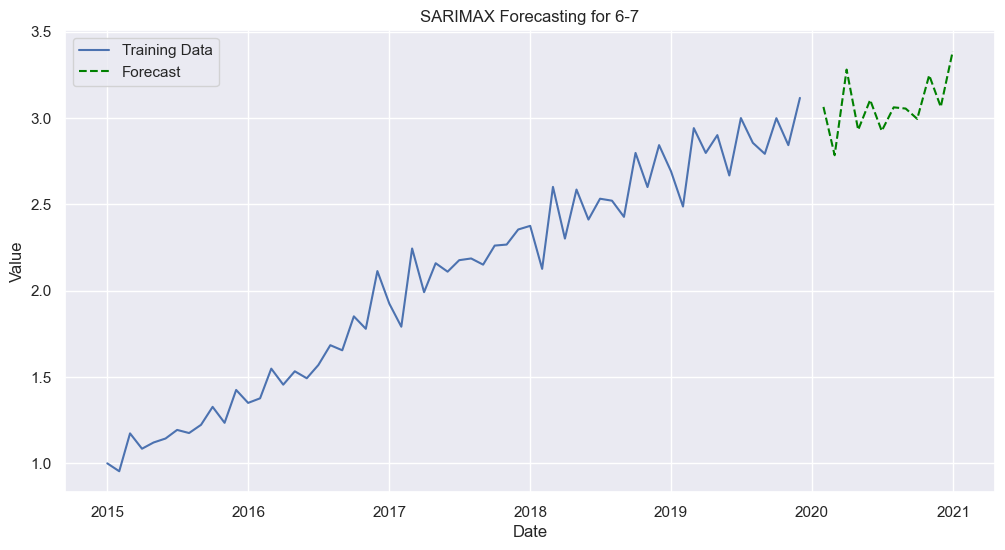

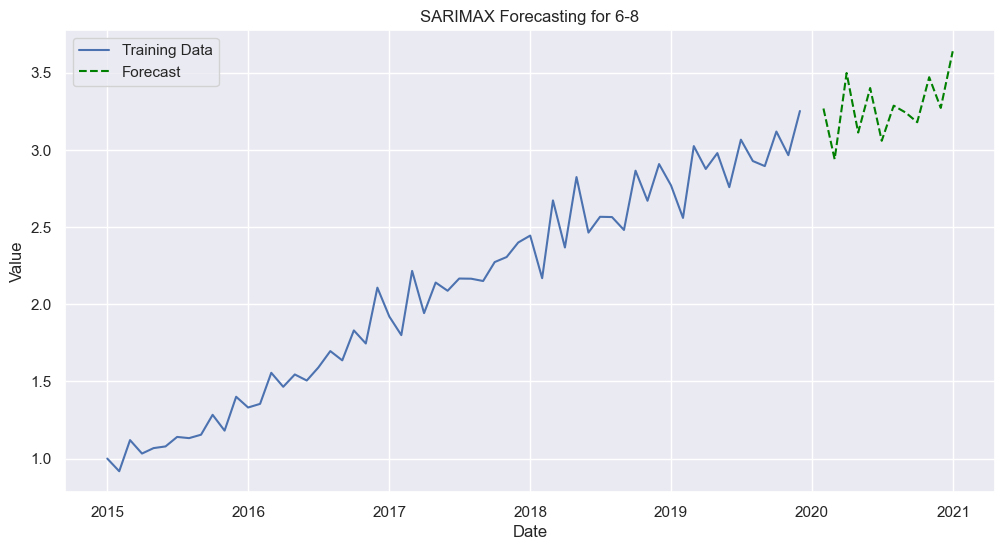

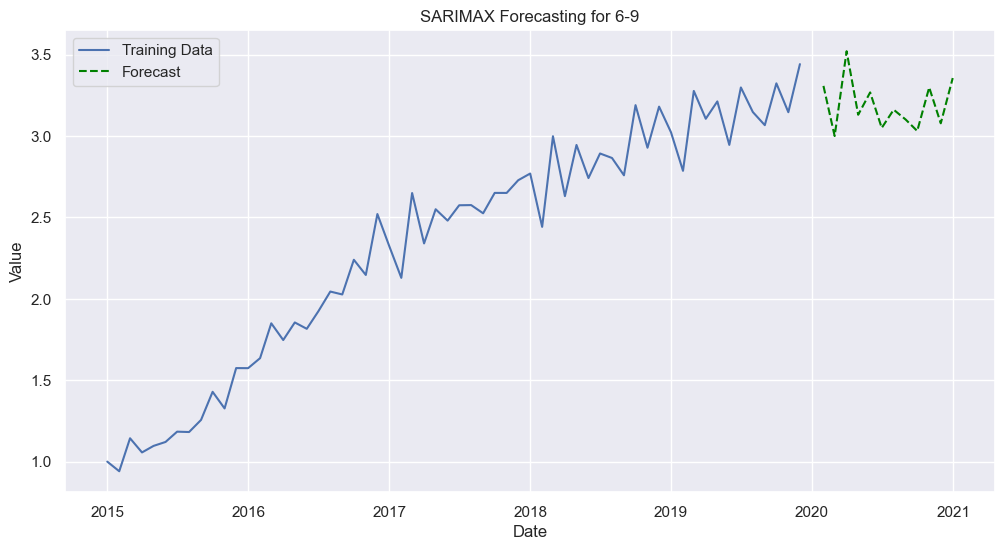

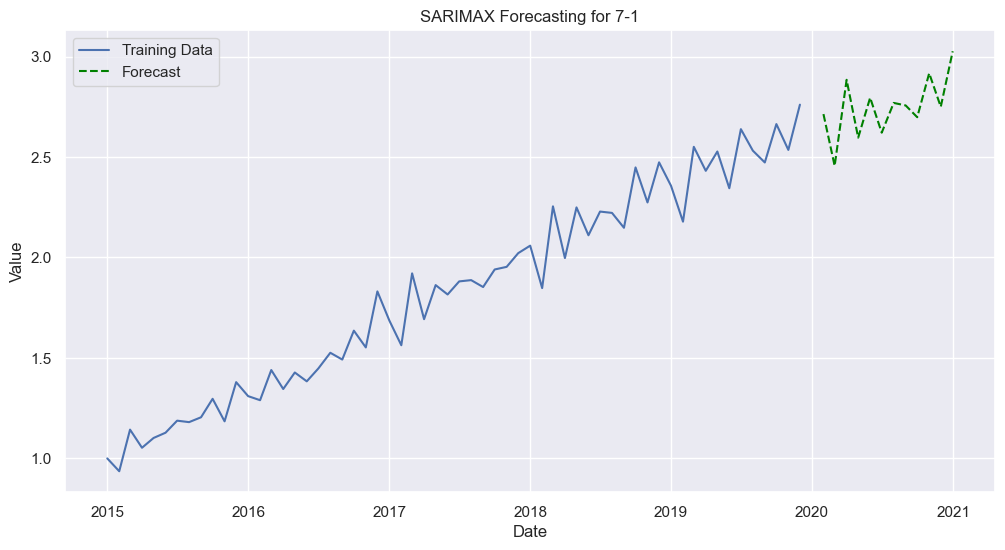

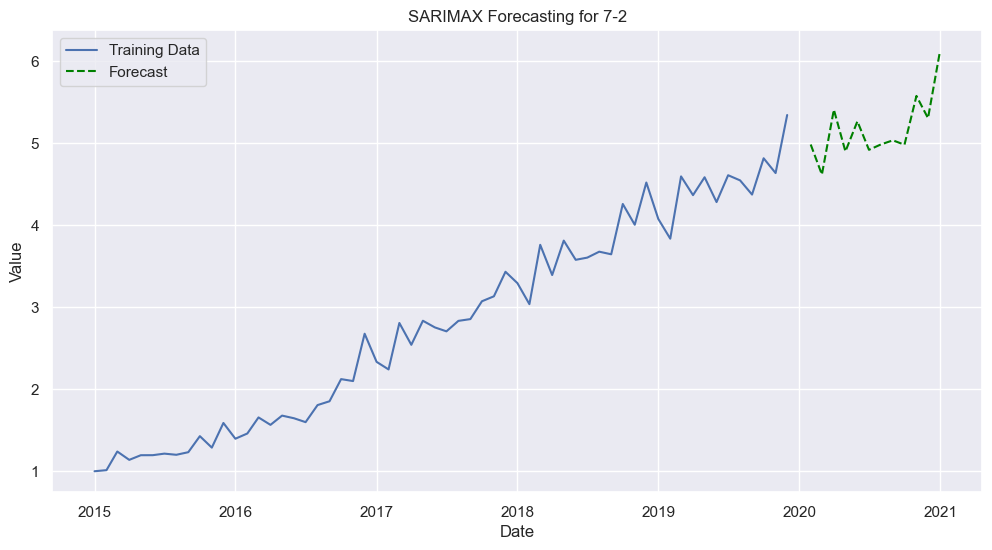

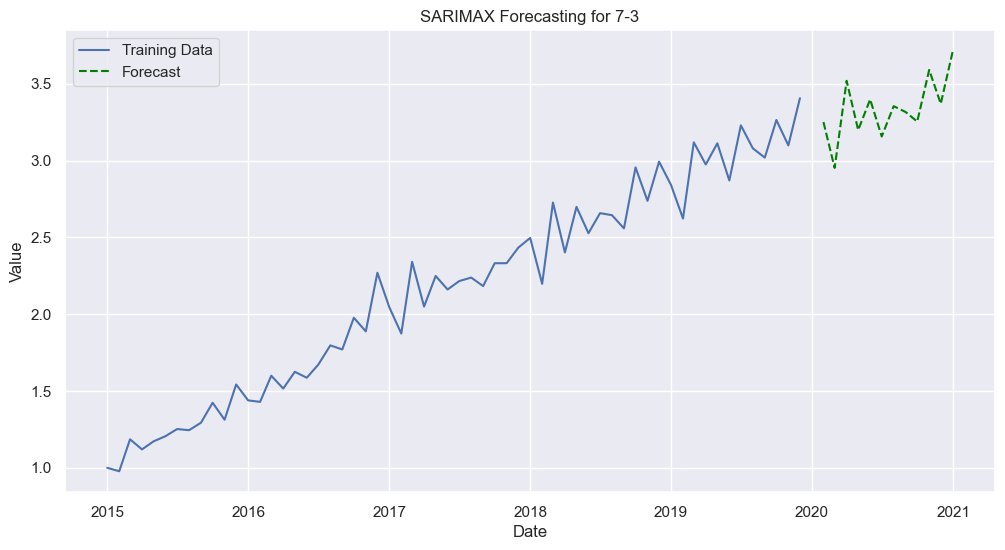

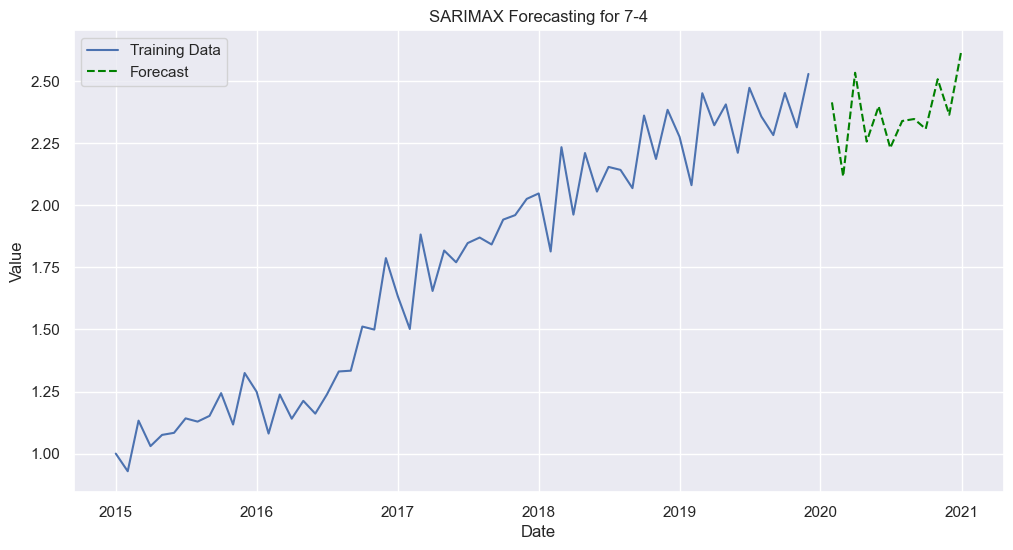

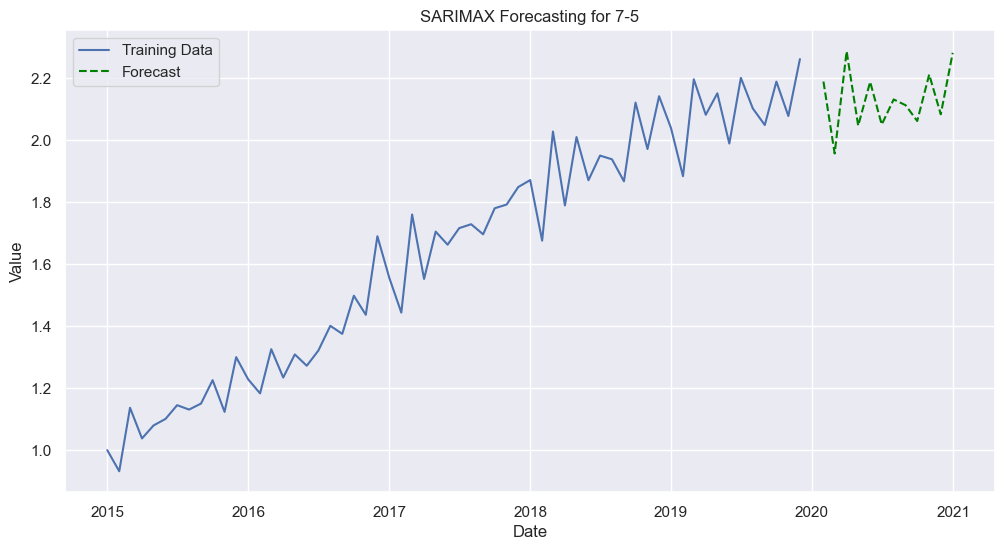

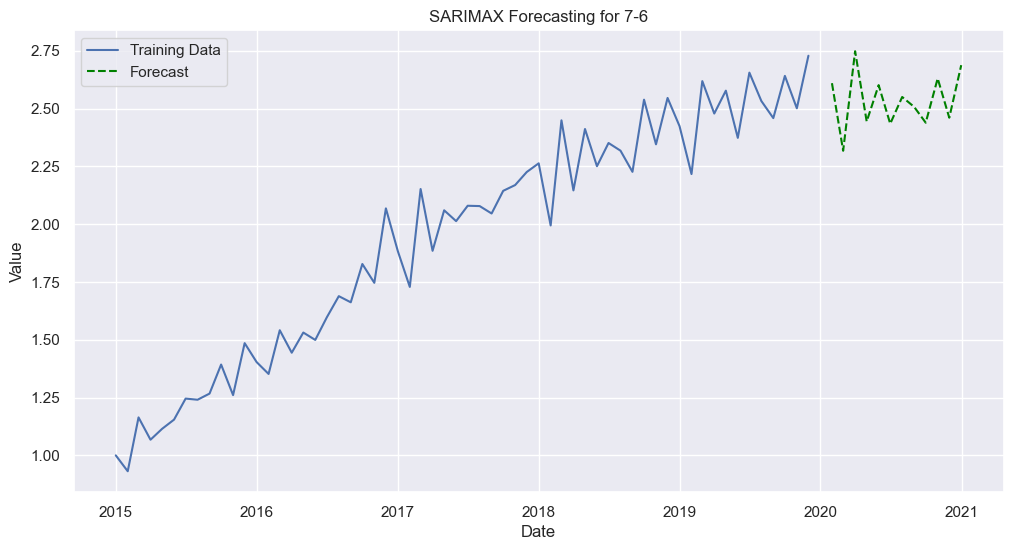

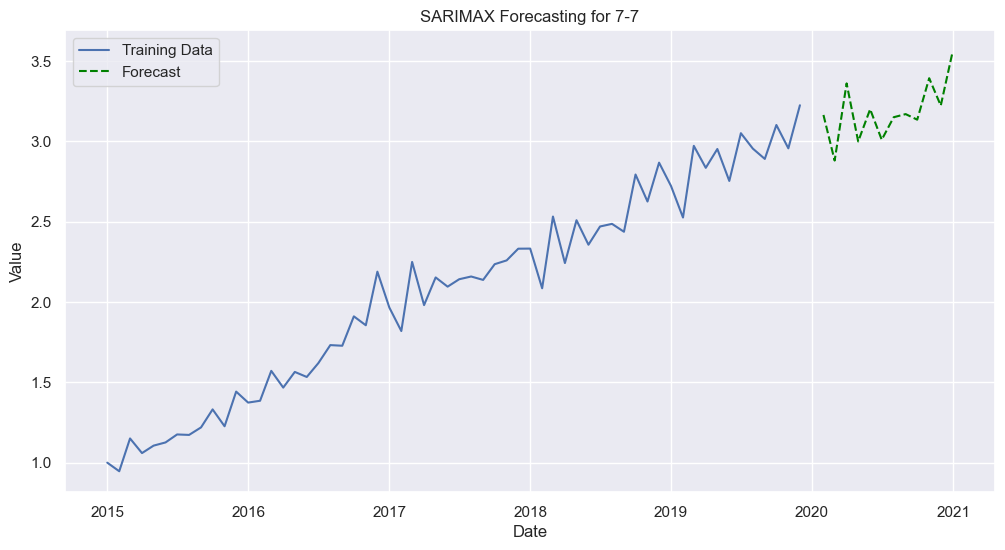

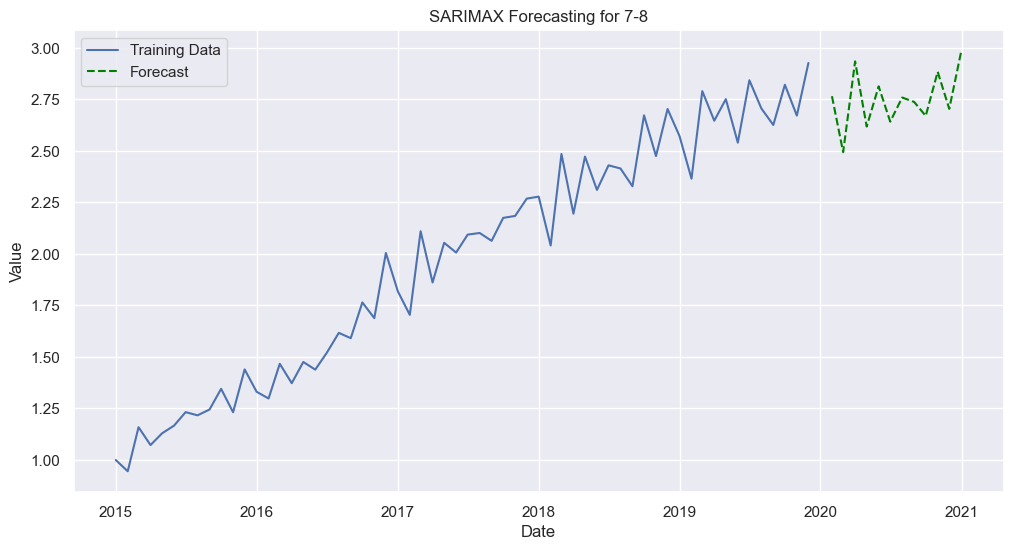

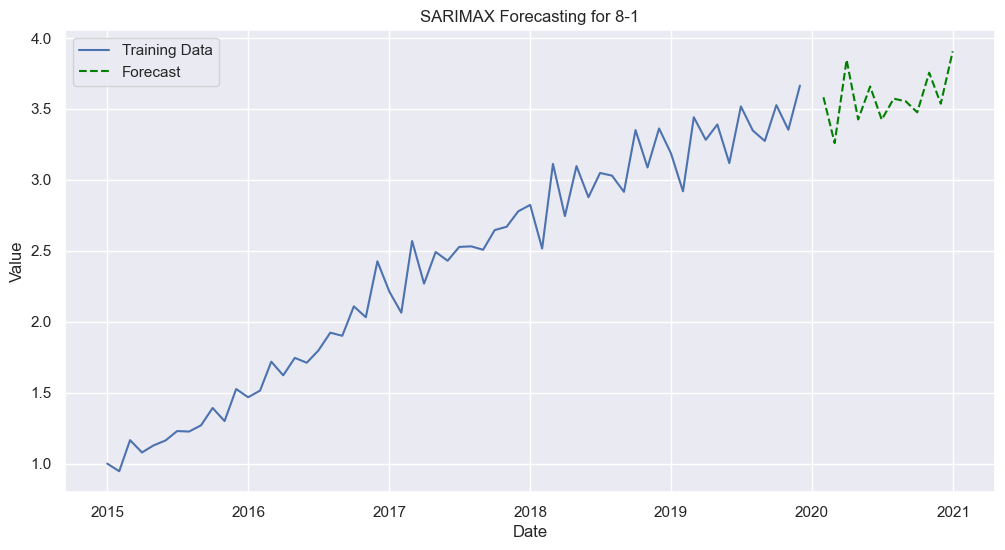

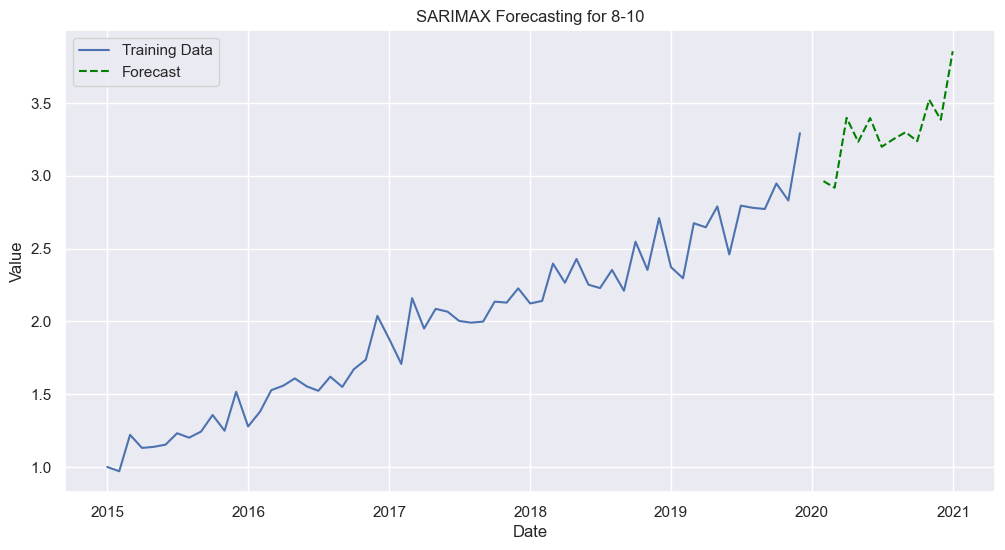

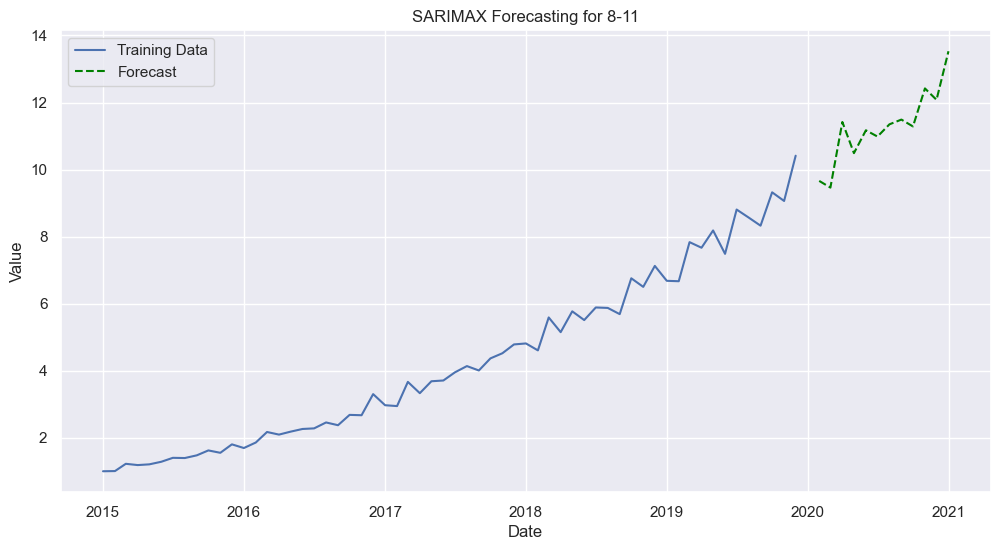

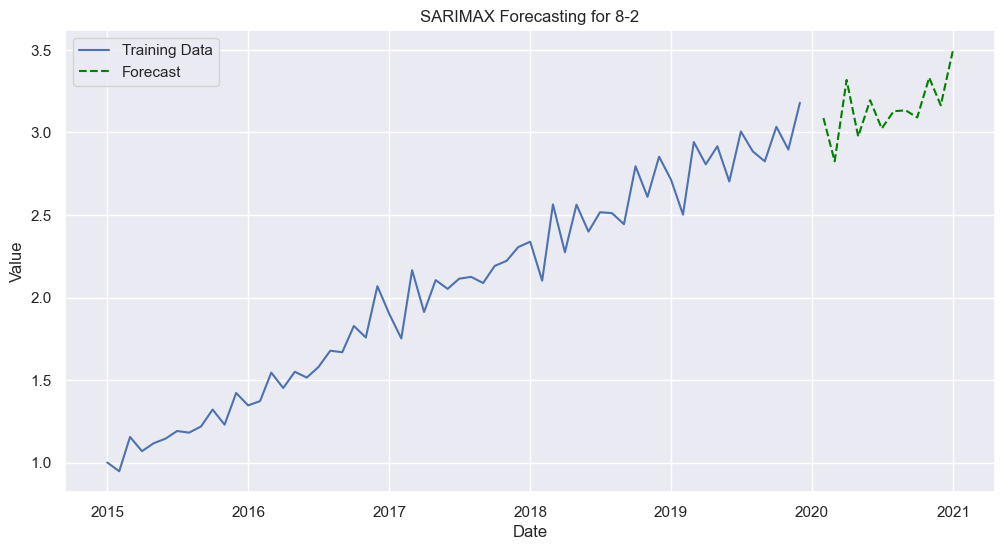

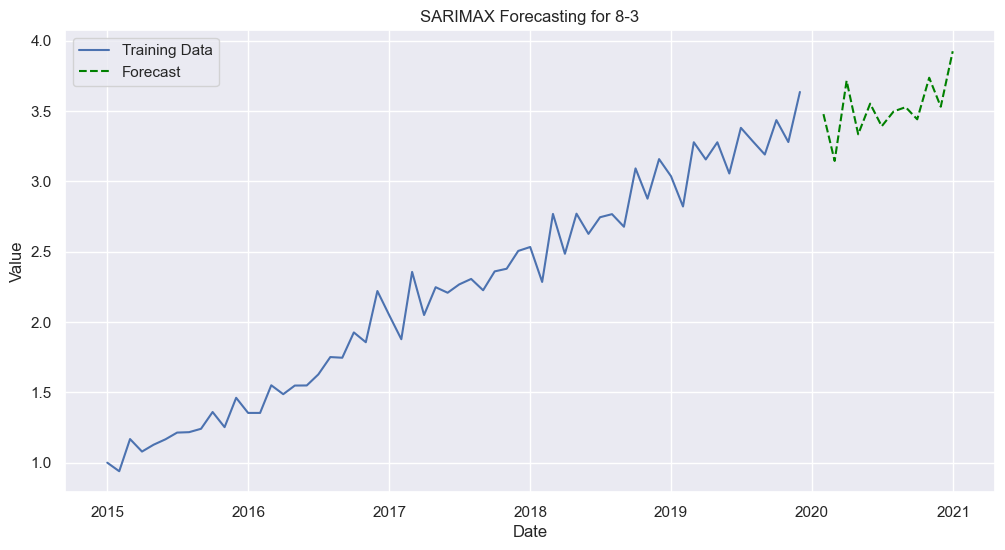

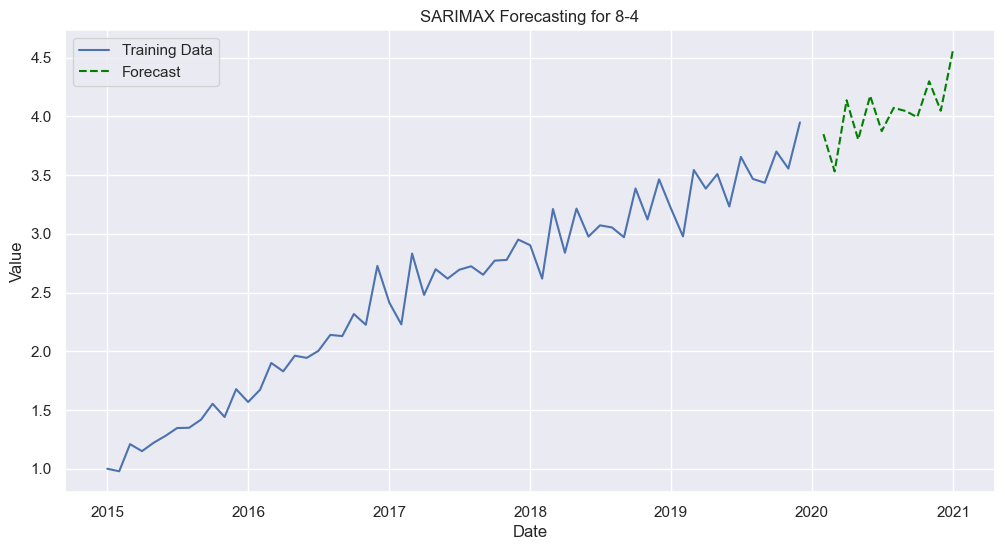

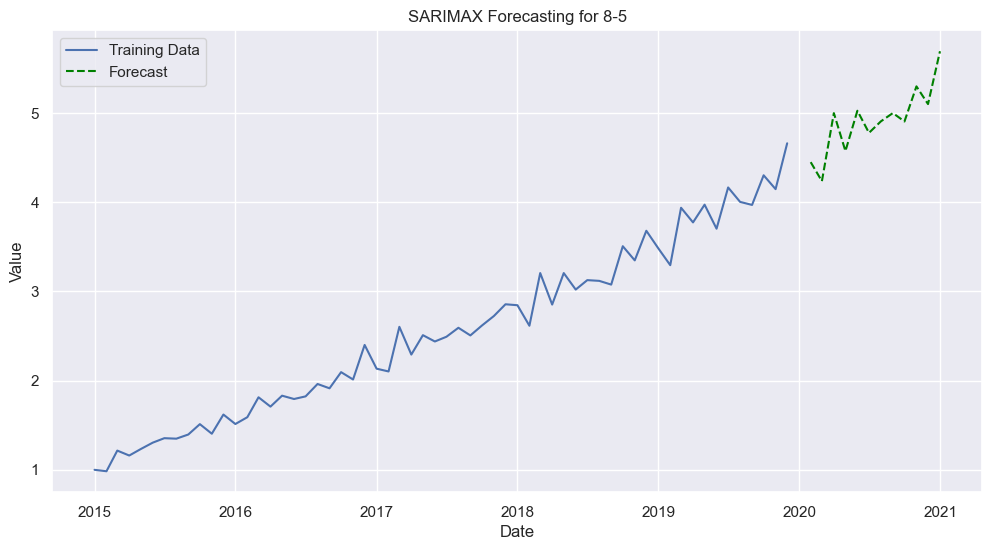

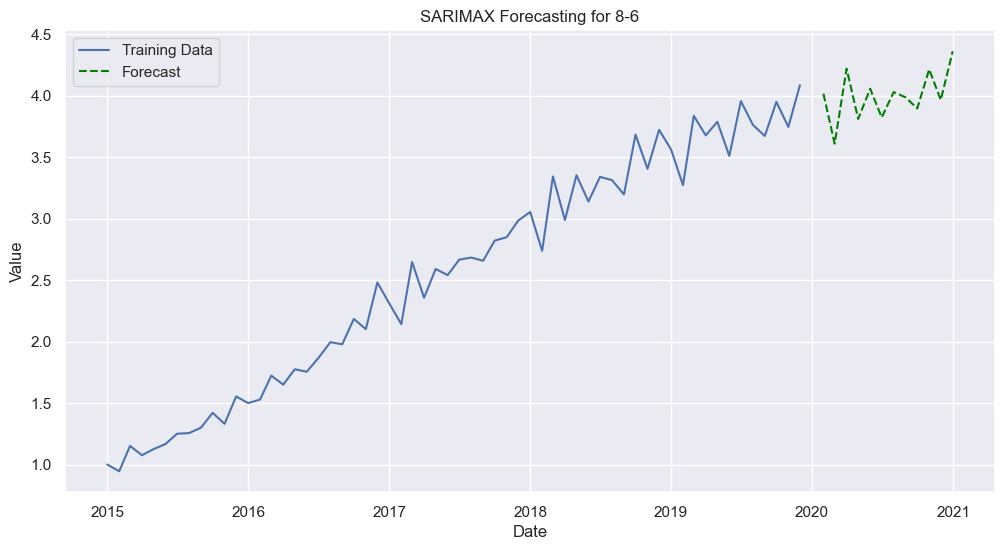

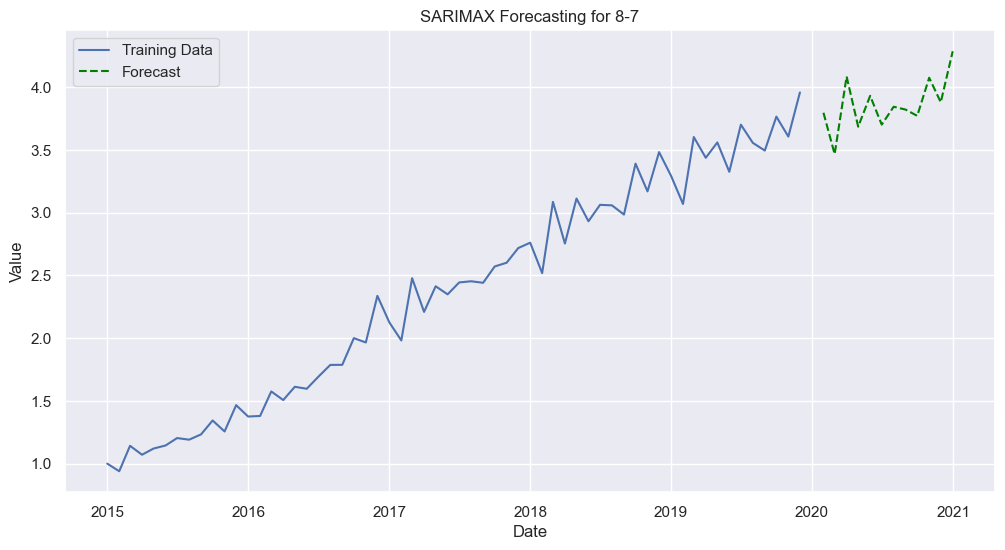

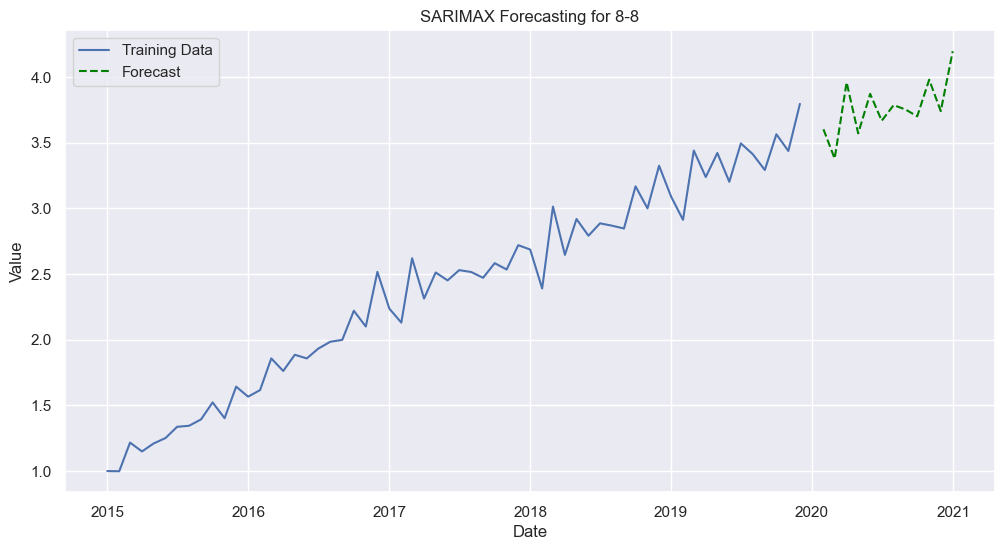

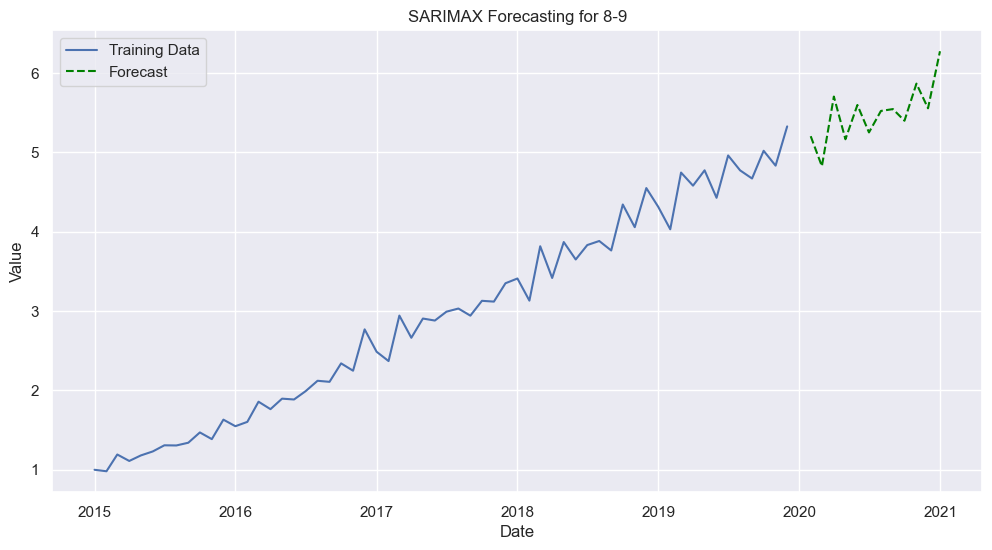

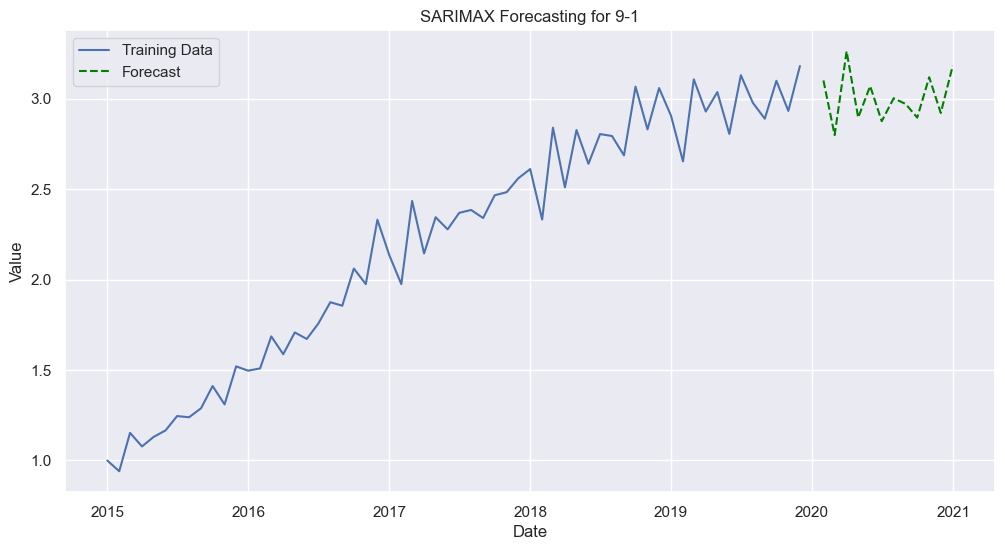

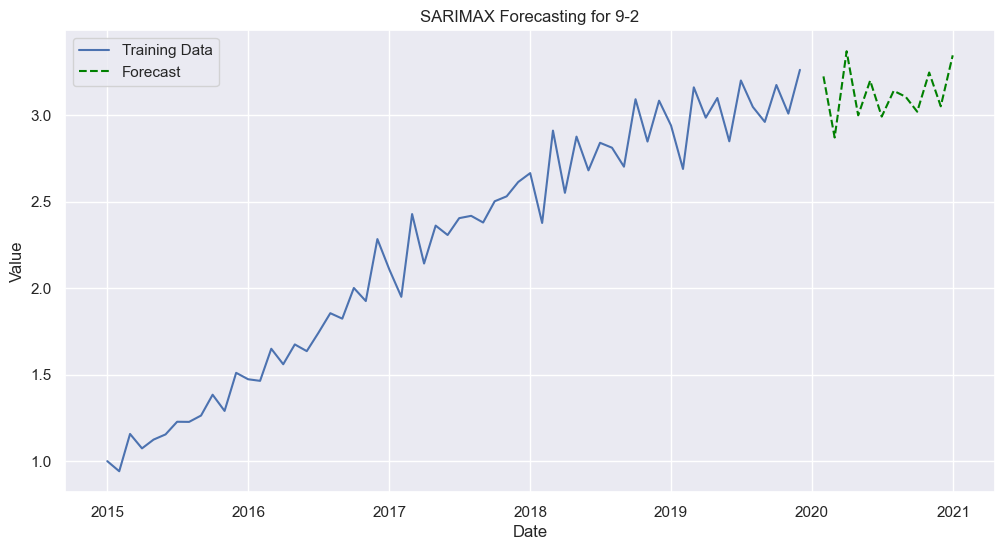

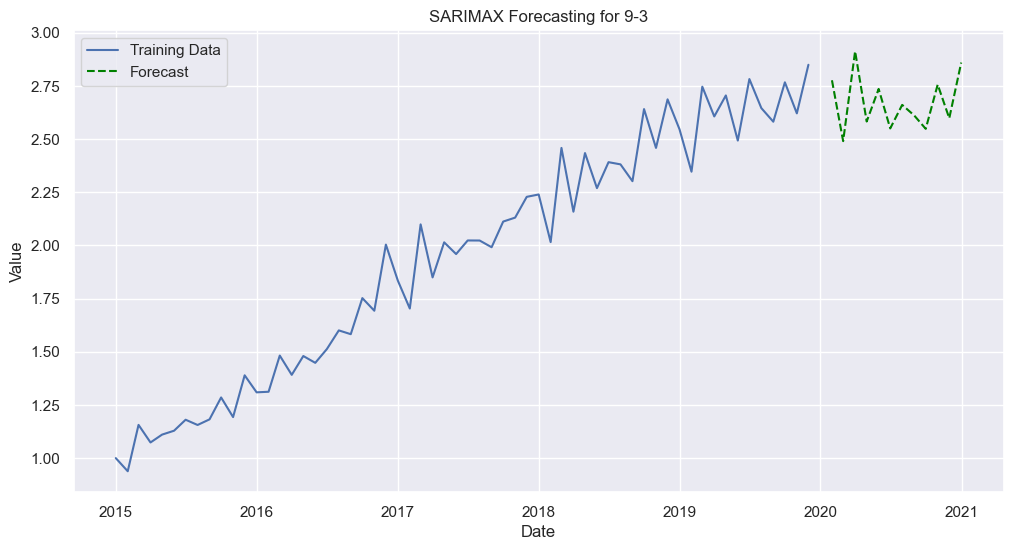

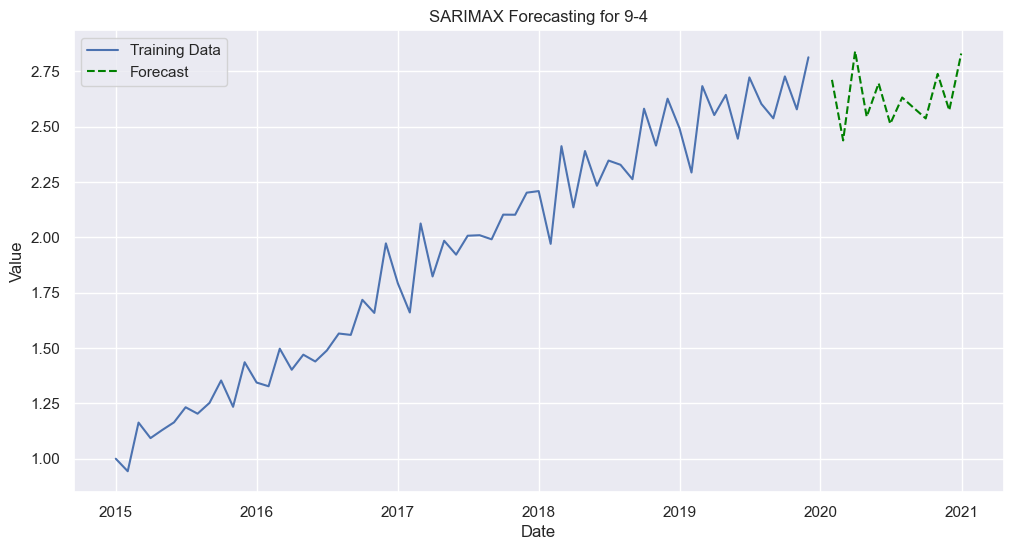

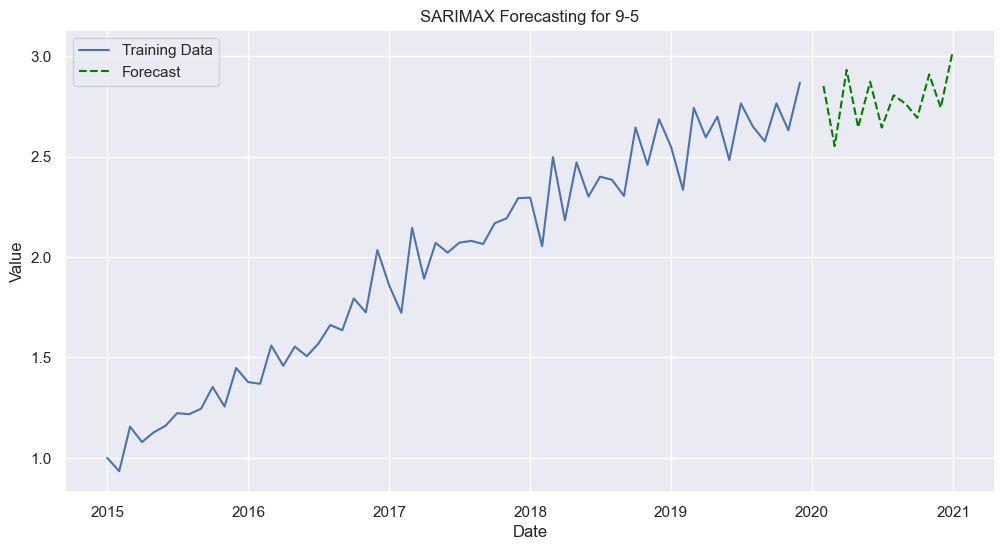

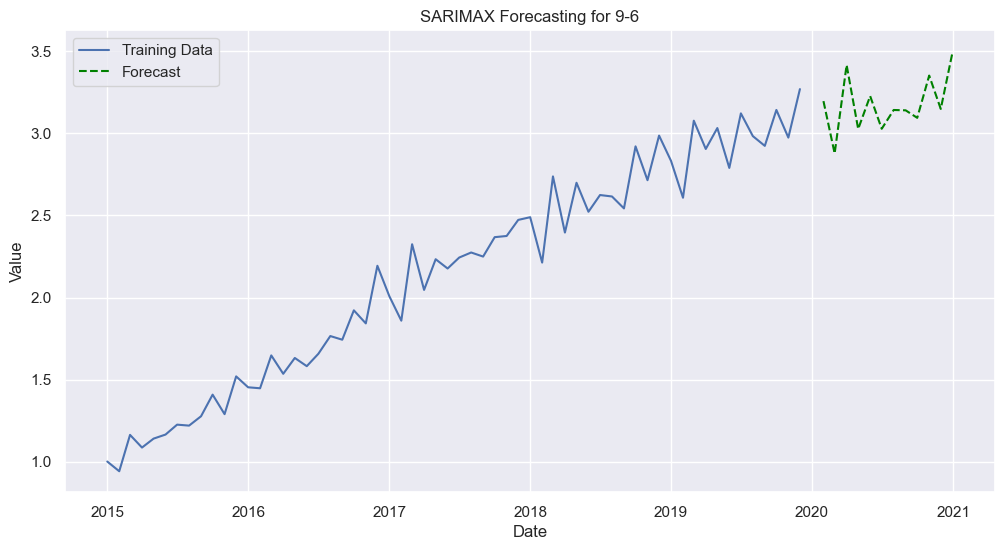

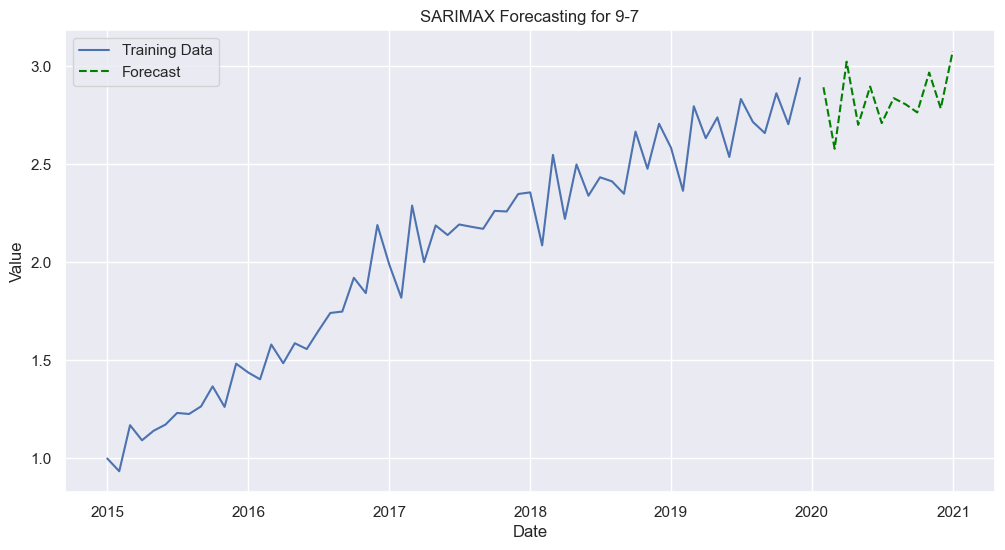

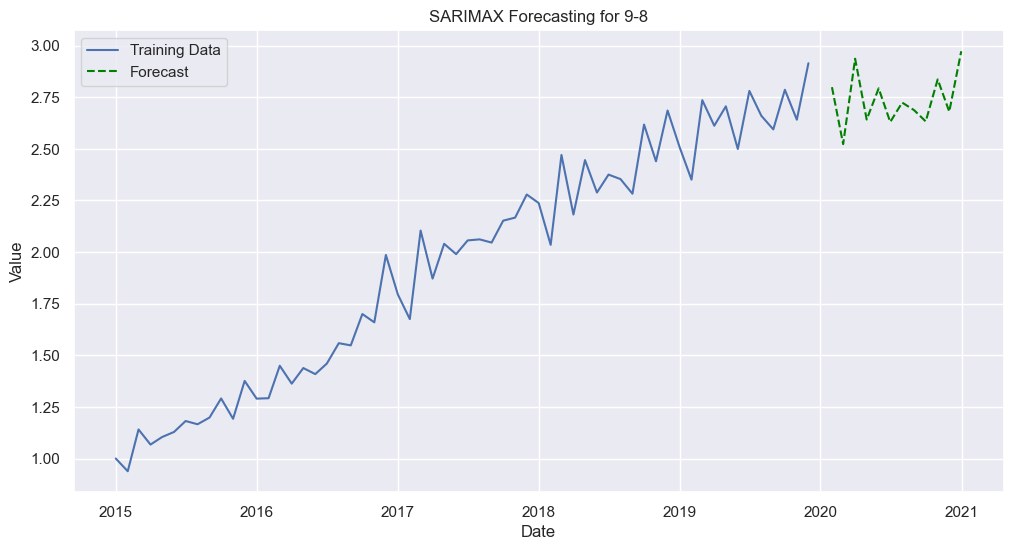

In [29]:
best_params = {
    'order': (0, 1, 4),
    'seasonal_order': (0, 1, 2, 6)
}

forecasts = []
smape_values = []

for division in df_train['division_name'].unique():
    X_train = df_train[df_train['division_name'] == division]
    X_test = df_test[df_test['division_name'] == division]
    
    forecaster = TransformedTargetForecaster([
        ("deseasonalise", Deseasonalizer(model="multiplicative", sp=12)),
        ("forecast", sktime_sarimax(order=best_params['order'], seasonal_order=best_params['seasonal_order']))
    ])
    
    forecaster.fit(y=X_train['val'], X=X_train[['rate']])
    
    forecast = forecaster.predict(fh=np.arange(1, 13), X=X_test[['rate']])
    
    forecast_df = pd.DataFrame({
        'report_dt': forecast.index,
        'division_name': division,
        'predicted_val': forecast.values
    })
    forecasts.append(forecast_df)

forecast_df = pd.concat(forecasts)
forecast_df.set_index('report_dt', inplace=True)

for division in df_train['division_name'].unique():
    plt.figure(figsize=(12, 6))
    
    df_train_plot = df_train[df_train['division_name'] == division].copy()
    df_train_plot.index = df_train_plot.index.to_timestamp()
    plt.plot(df_train_plot.index, df_train_plot['val'], label='Training Data')
    
    forecast_plot = forecast_df[forecast_df['division_name'] == division]
    plt.plot(forecast_plot.index, forecast_plot['predicted_val'], label='Forecast', linestyle='--', color='green')
    
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.title(f'SARIMAX Forecasting for {division}')
    plt.legend()
    plt.show()
